# <span style='color:SteelBlue'>P6 - Segmentez des clients d'un site e-commerce</span>

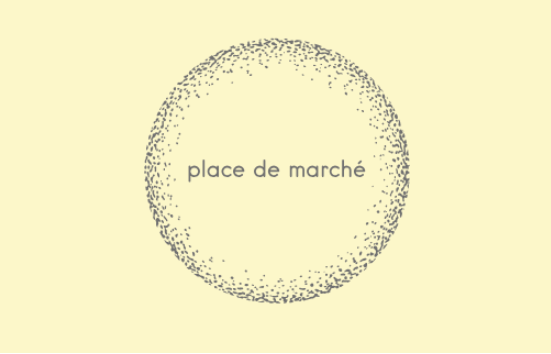

# <span class='bg-primary'>P6_03 - NLP - Données Textuelles - Classification supervisée</span>

# <span class='bg-primary'>P6_01_04 - Texts Embeddings</span>

## <span style='background:Thistle'>Sommaire du notebook</span> 

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

Ce Notebook traite le NLP avec les méthodes text embedding avec classification supervisée.

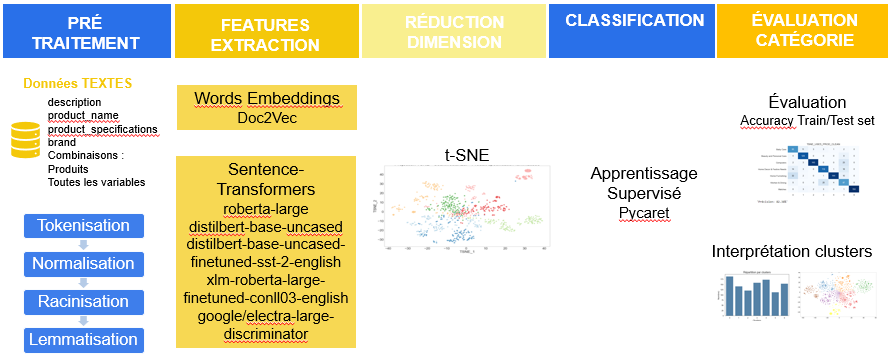

Les meilleurs résultats sont obtenus avec :

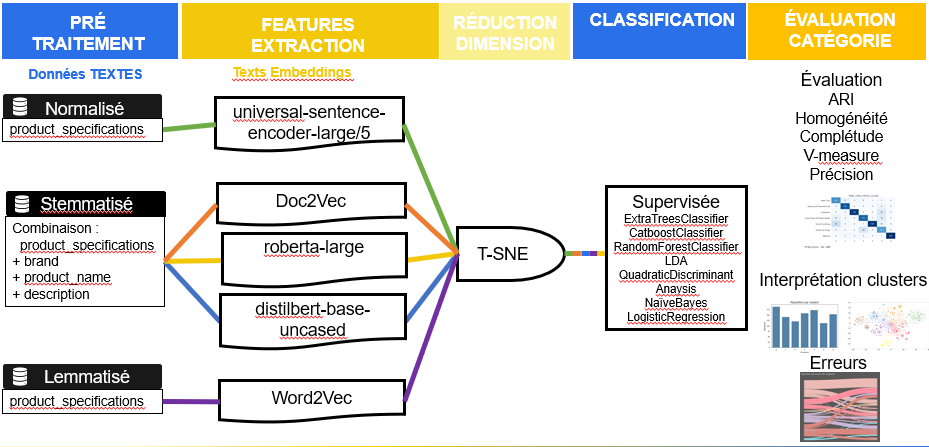

## <span style='background:Thistle'>1. Introduction</span>

**Mission**
*****
Réaliser une première **étude de faisabilité** d'un moteur de **classification d'articles** basé sur une **image et une description** pour l'**automatisation** de l'attribution de la **catégorie de l'article**.

**Objectifs**
*****
- analyser le jeu de données,
- réaliser :
    - un prétraitement des images,
    - un prétraitement des descriptions des produits
    - une réduction de dimension, 
    - puis un clustering. 

La représentation graphique aidera à convaincre que cette approche de modélisation permettra bien de regrouper des produits de même catégorie.

**Contraintes**
***
Afin d’extraire les features, mettre en œuvre a minima un algorithme de type SIFT / ORB / SURF (un algorithme de type CNN Transfer Learning peut éventuellement être utilisé en complément, s’il peut apporter un éclairage supplémentaire à la démonstration).

**Sources**
*****
- [Jeu de données](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Textimage+DAS+V2/Dataset+projet+pre%CC%81traitement+textes+images.zip)

In [1]:
# Chargement des librairies
import datetime
import time
import sys
import warnings
from datetime import datetime
import jyquickhelper
import numpy as np
import pandas as pd
import outils_data
import outils_nlp
import multiprocessing
from gensim.models import doc2vec
# import outils_visu
import outils_acp
import outils_segmentation
# Plotly Libraries
import plotly
import plotly.express as px
import plotly.graph_objects as go
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import matplotlib as mpl
import matplotlib.pyplot as plt
# Feature extraction
import seaborn as sns
# BERT
import transformers
from sentence_transformers import SentenceTransformer
# USE
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.manifold import TSNE
# Clustering
from sklearn.cluster import KMeans
from pycaret.classification import *
# Warnings
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

%matplotlib inline
# Chargement à chaud des librairies personnelles
%load_ext autoreload
%autoreload 2
# Valide code pep8
%load_ext pycodestyle_magic
%pycodestyle_on
# %pycodestyle_off

# Versions
print('Version des librairies utilisées :')
print('jyquickhelper         : ' + jyquickhelper.__version__)
print('Python                : ' + sys.version)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Matplotlib            : ' + mpl.__version__)
print('Seaborn               : ' + sns.__version__)
print('Outils dataframe      : ' + outils_data.__version__)
print('Outils NLP            : ' + outils_nlp.__version__)
print('Outils ACP            : ' + outils_acp.__version__)
print('Outils SEGMENTATION   : ' + outils_segmentation.__version__)
now = datetime.now().isoformat()
print('Lancé le           : ' + now)

Version des librairies utilisées :
jyquickhelper         : 0.4.220
Python                : 3.8.8 (default, Feb 24 2021, 15:54:32) [MSC v.1928 64 bit (AMD64)]
NumPy                 : 1.19.5
Pandas                : 1.2.4
Matplotlib            : 3.3.4
Seaborn               : 0.11.0
Outils dataframe      : 0.0.2
Outils NLP            : 0.0.0
Outils ACP            : 0.0.1
Outils SEGMENTATION   : 0.0.0
Lancé le           : 2021-06-30T10:42:16.881502


In [2]:
dico_pd_option = {
    'display.max_rows': 400,
    'display.max_column': 200,
    'display.width': 300,
    'display.precision': 5,
    'display.max_colwidth': 1000,
    'mode.chained_assignment': None
}
for cle, val in dico_pd_option.items():
    pd.set_option(cle, val)

## <span style='background:Thistle'>2. Chargement du jeu de données</span>

In [3]:
# Nombre aléatoire pour la reproductibilité des résultats
seed = 21

In [4]:
# Chargement du jeu de données
data = pd.read_csv('data_clean.csv')
# Supprime varaible Unnamed: 0
data.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
data_cat = data['Categorie_1']

In [6]:
# Taille : nombre de lignes/colonnes
nRow, nVar = data.shape
print(f'Le jeu de données contient {nRow} lignes et {nVar} variables.')

Le jeu de données contient 1050 lignes et 23 variables.


In [7]:
# 2 premières lignes
data.head(2)

product_name     brand                                 image                                                                                                                  product_category_tree  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain  Elegance  55b85ea15a1536d46b7190ad6fff8ce7.jpg                           Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do...   
1                                  Sathiyas Cotton Bath Towel  Sathiyas  7b72c92c2f6c40268628ec5f14c6d590.jpg  Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y...   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that ...   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel   

                                                                                                                                                                                                                                                                                             

In [41]:
# Dataframe de sauvegarde des résultats des scores
# df_accuracy_class = pd.DataFrame()
# Chargement des données de sauvegarde des résultats des métriques KMeans
df_accuracy_class = pd.read_csv('data_accuracy_classification.csv')

In [6]:
cols = ['VAR1', 'VAR2']

## <span style='background:Thistle'>3. Feature extraction - Paragraphes embeddings</span>

### <span style='background:PowderBlue'>3.1. Doc2vec</span>

In [11]:
# Compte le nombre de coeur du processeur
cores = multiprocessing.cpu_count()

In [12]:
text_dim = 300

<span style='background:Moccasin'>**3.1.1. description** - originale (non nettoyée)</span>

**Modélisation**

In [13]:
# Création corpus
corpus_desc_orig = outils_nlp.read_corpus(data, 'description')
corpus_desc_orig = list(corpus_desc_orig)
# Instanciation du modèle
doc2v_model_desc_orig = doc2vec.Doc2Vec(min_count=5, window=3,
                                        size=text_dim, workers=cores-1,
                                        dm=0, dbow_words=1, epochs=100,
                                        dm_mean=0, seed=seed)
# Construit le vocabulaire à partir d'une séquence de mots et
# initialise ainsi le modèle.
doc2v_model_desc_orig.build_vocab(corpus_desc_orig,
                                  progress_per=10000)
# Entraînement du modèle
doc2v_model_desc_orig.train(corpus_desc_orig,
                            total_examples=doc2v_model_desc_orig.corpus_count,
                            epochs=doc2v_model_desc_orig.epochs,
                            report_delay=1)
# Vectorisation
vector_doc2v_desc_orig = doc2v_model_desc_orig.docvecs.vectors_docs

**Classification PyCaret**

In [42]:
titre = 'TSNE_DOC2V_DESC_ORIG'

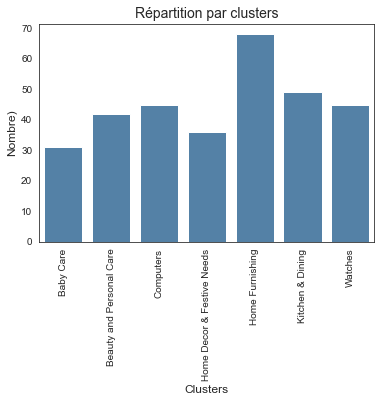

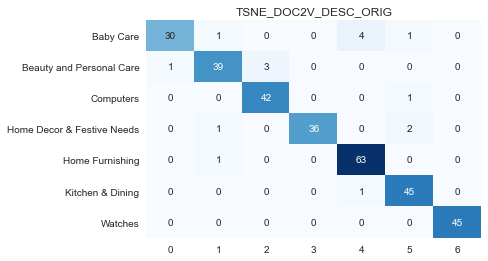

'Précision: 94.94%'

                            precision    recall  f1-score   support

                 Baby Care       0.97      0.83      0.90        36
  Beauty and Personal Care       0.93      0.91      0.92        43
                 Computers       0.93      0.98      0.95        43
Home Decor & Festive Needs       1.00      0.92      0.96        39
           Home Furnishing       0.93      0.98      0.95        64
          Kitchen & Dining       0.92      0.98      0.95        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.95       316
                 macro avg       0.95      0.94      0.95       316
              weighted avg       0.95      0.95      0.95       316


In [44]:
outils_nlp.classifier_pycaret(data_cat, vector_doc2v_desc_orig, titre)

In [98]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.9126', '0.9494', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
0  TSNE_DOC2V_DESC_ORIG         0.9086        0.9430

<span style='background:Moccasin'>**3.1.2. description** - nettoyée non racinisée ni lemmatisée</span>

**Modélisation**

In [91]:
# Création corpus
corpus_desc_clean = outils_nlp.read_corpus(data, 'description_clean')
corpus_desc_clean = list(corpus_desc_clean)
# Instanciation du modèle
doc2v_model_desc_clean = doc2vec.Doc2Vec(min_count=5, window=3,
                                         size=text_dim, workers=cores-1,
                                         dm=0, dbow_words=1, epochs=100,
                                         dm_mean=0, seed=seed)
# Construit le vocabulaire à partir d'une séquence de mots et
# initialise ainsi le modèle.
doc2v_model_desc_clean.build_vocab(corpus_desc_clean,
                                   progress_per=10000)
# Entraînement du modèle
doc2v_model_desc_clean.train(corpus_desc_clean,
                             total_examples=doc2v_model_desc_clean
                             .corpus_count,
                             epochs=doc2v_model_desc_clean.epochs,
                             report_delay=1)
# Vectorisation
vector_doc2v_desc_clean = doc2v_model_desc_clean.docvecs.vectors_docs

**Classification PyCaret**

In [99]:
titre = 'TSNE_DOC2V_DESC_CLEAN'

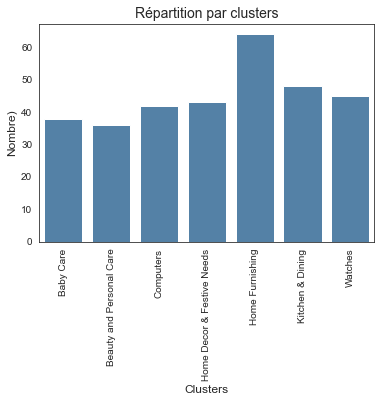

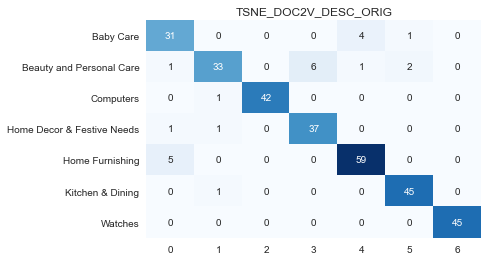

'Précision: 92.41%'

                            precision    recall  f1-score   support

                 Baby Care       0.82      0.86      0.84        36
  Beauty and Personal Care       0.92      0.77      0.84        43
                 Computers       1.00      0.98      0.99        43
Home Decor & Festive Needs       0.86      0.95      0.90        39
           Home Furnishing       0.92      0.92      0.92        64
          Kitchen & Dining       0.94      0.98      0.96        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.92       316
                 macro avg       0.92      0.92      0.92       316
              weighted avg       0.93      0.92      0.92       316


In [93]:
outils_nlp.classifier_pycaret(data_cat, vector_doc2v_desc_clean, titre)

In [100]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.8977', '0.9241', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
1  TSNE_DOC2V_DESC_CLEAN         0.8977        0.9241

<span style='background:Moccasin'>**3.1.3. description** - lemmatisée</span>

**Modélisation**

In [101]:
data['description_clean_lemma'] = \
    data['description_clean_lemma'].fillna('').astype(str)

In [102]:
# Création corpus
corpus_desc_lem = outils_nlp.read_corpus(data, 'description_clean_lemma')
corpus_desc_lem = list(corpus_desc_lem)
# Instanciation du modèle
doc2v_model_desc_lem = doc2vec.Doc2Vec(min_count=5, window=3,
                                       size=text_dim, workers=cores-1,
                                       dm=0, dbow_words=1, epochs=100,
                                       dm_mean=0, seed=seed)
# Construit le vocabulaire à partir d'une séquence de mots et
# initialise ainsi le modèle.
doc2v_model_desc_lem.build_vocab(corpus_desc_lem,
                                 progress_per=10000)
# Entraînement du modèle
doc2v_model_desc_lem.train(corpus_desc_lem,
                           total_examples=doc2v_model_desc_lem
                           .corpus_count,
                           epochs=doc2v_model_desc_lem.epochs,
                           report_delay=1)
# Vectorisation
vector_doc2v_desc_lem = doc2v_model_desc_lem.docvecs.vectors_docs

In [104]:
titre = 'TSNE_DOC2V_DESC_LEM'

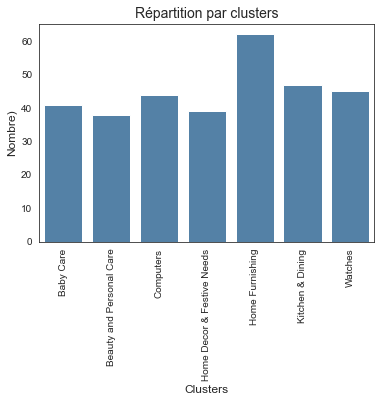

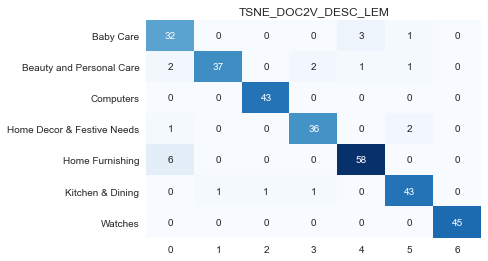

'Précision: 93.04%'

                            precision    recall  f1-score   support

                 Baby Care       0.78      0.89      0.83        36
  Beauty and Personal Care       0.97      0.86      0.91        43
                 Computers       0.98      1.00      0.99        43
Home Decor & Festive Needs       0.92      0.92      0.92        39
           Home Furnishing       0.94      0.91      0.92        64
          Kitchen & Dining       0.91      0.93      0.92        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.93       316
                 macro avg       0.93      0.93      0.93       316
              weighted avg       0.93      0.93      0.93       316


In [105]:
outils_nlp.classifier_pycaret(data_cat, vector_doc2v_desc_lem, titre)

In [106]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.8882', '0.9304', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
2  TSNE_DOC2V_DESC_LEM         0.8882        0.9304

<span style='background:Moccasin'>**3.1.4. description** - stemmatisée</span>

**Modélisation**

In [107]:
data['description_clean_stem'] = \
    data['description_clean_stem'].fillna('').astype(str)

In [108]:
# Création corpus
corpus_desc_stem = outils_nlp.read_corpus(data, 'description_clean_stem')
corpus_desc_stem = list(corpus_desc_stem)
# Instanciation du modèle
doc2v_model_desc_stem = doc2vec.Doc2Vec(min_count=5, window=3,
                                        size=text_dim, workers=cores-1,
                                        dm=0, dbow_words=1, epochs=100,
                                        dm_mean=0, seed=seed)
# Construit le vocabulaire à partir d'une séquence de mots et
# initialise ainsi le modèle.
doc2v_model_desc_stem.build_vocab(corpus_desc_stem,
                                  progress_per=10000)
# Entraînement du modèle
doc2v_model_desc_stem.train(corpus_desc_stem,
                            total_examples=doc2v_model_desc_stem
                            .corpus_count,
                            epochs=doc2v_model_desc_stem.epochs,
                            report_delay=1)
# Vectorisation
vector_doc2v_desc_stem = doc2v_model_desc_stem.docvecs.vectors_docs

In [111]:
titre = 'TSNE_DOC2V_DESC_STEM'

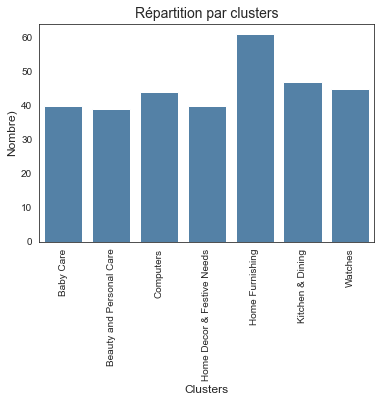

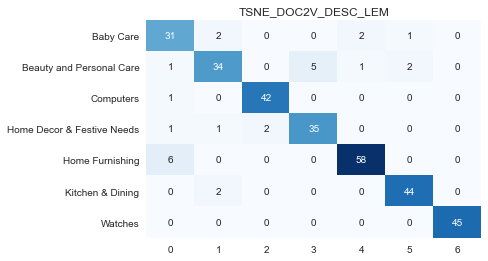

'Précision: 91.46%'

                            precision    recall  f1-score   support

                 Baby Care       0.78      0.86      0.82        36
  Beauty and Personal Care       0.87      0.79      0.83        43
                 Computers       0.95      0.98      0.97        43
Home Decor & Festive Needs       0.88      0.90      0.89        39
           Home Furnishing       0.95      0.91      0.93        64
          Kitchen & Dining       0.94      0.96      0.95        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.91       316
                 macro avg       0.91      0.91      0.91       316
              weighted avg       0.92      0.91      0.91       316


In [109]:
outils_nlp.classifier_pycaret(data_cat, vector_doc2v_desc_stem, titre)

In [113]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.8937', '0.9146', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
3  TSNE_DOC2V_DESC_STEM         0.8937        0.9146

<span style='background:Moccasin'>**3.1.5. product_specifications** - originale (non nettoyée)</span>

**Modélisation**

In [114]:
data['product_specifications'] = \
    data['product_specifications'].fillna('').astype(str)

In [115]:
# Création corpus
corpus_prod_orig = outils_nlp.read_corpus(data, 'product_specifications')
corpus_prod_orig = list(corpus_prod_orig)
# Instanciation du modèle
doc2v_model_prod_orig = doc2vec.Doc2Vec(min_count=5, window=3,
                                        size=text_dim, workers=cores-1,
                                        dm=0, dbow_words=1, epochs=100,
                                        dm_mean=0, seed=seed)
# Construit le vocabulaire à partir d'une séquence de mots et
# initialise ainsi le modèle.
doc2v_model_prod_orig.build_vocab(corpus_prod_orig,
                                  progress_per=10000)
# Entraînement du modèle
doc2v_model_prod_orig.train(corpus_prod_orig,
                            total_examples=doc2v_model_prod_orig
                            .corpus_count,
                            epochs=doc2v_model_prod_orig.epochs,
                            report_delay=1)
# Vectorisation
vector_doc2v_prod_orig = doc2v_model_prod_orig.docvecs.vectors_docs

In [116]:
titre = 'TSNE_DOC2V_PROD_SPECIF_ORIG'

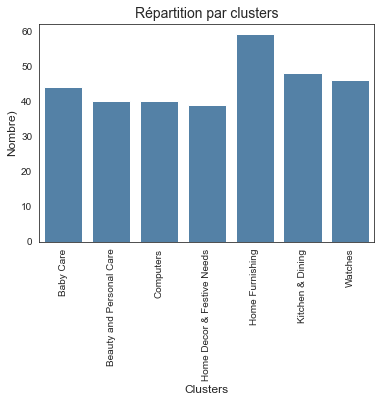

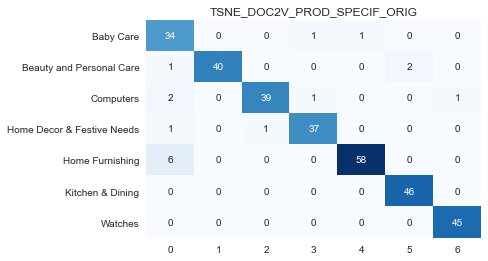

'Précision: 94.62%'

                            precision    recall  f1-score   support

                 Baby Care       0.77      0.94      0.85        36
  Beauty and Personal Care       1.00      0.93      0.96        43
                 Computers       0.97      0.91      0.94        43
Home Decor & Festive Needs       0.95      0.95      0.95        39
           Home Furnishing       0.98      0.91      0.94        64
          Kitchen & Dining       0.96      1.00      0.98        46
                   Watches       0.98      1.00      0.99        45

                  accuracy                           0.95       316
                 macro avg       0.95      0.95      0.94       316
              weighted avg       0.95      0.95      0.95       316


In [117]:
outils_nlp.classifier_pycaret(data_cat, vector_doc2v_prod_orig, titre)

In [118]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.9346', '0.9462', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
4  TSNE_DOC2V_PROD_SPECIF_ORIG         0.9346        0.9462

<span style='background:Moccasin'>**3.1.6. product_specifications** - lemmatisée</span>

**Modélisation**

In [119]:
data['product_specifications_clean'] = \
    data['product_specifications_clean'].fillna('').astype(str)

In [120]:
# Création corpus
corpus_prod_clean = outils_nlp.read_corpus(data,
                                           'product_specifications_clean')
corpus_prod_clean = list(corpus_prod_clean)
# Instanciation du modèle
doc2v_model_prod_clean = doc2vec.Doc2Vec(min_count=5, window=3,
                                         size=text_dim, workers=cores-1,
                                         dm=0, dbow_words=1, epochs=100,
                                         dm_mean=0, seed=seed)
# Construit le vocabulaire à partir d'une séquence de mots et
# initialise ainsi le modèle.
doc2v_model_prod_clean.build_vocab(corpus_prod_clean,
                                   progress_per=10000)
# Entraînement du modèle
doc2v_model_prod_clean.train(corpus_prod_clean,
                             total_examples=doc2v_model_prod_clean
                             .corpus_count,
                             epochs=doc2v_model_prod_clean.epochs,
                             report_delay=1)
# Vectorisation
vector_doc2v_prod_clean = doc2v_model_prod_clean.docvecs.vectors_docs

In [121]:
titre = 'TSNE_DOC2V_PROD_SPECIF_CLEAN'

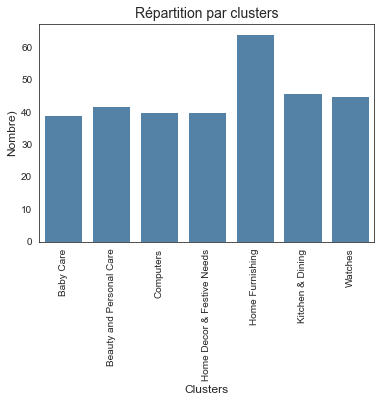

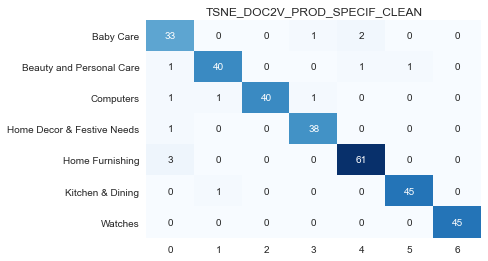

'Précision: 95.57%'

                            precision    recall  f1-score   support

                 Baby Care       0.85      0.92      0.88        36
  Beauty and Personal Care       0.95      0.93      0.94        43
                 Computers       1.00      0.93      0.96        43
Home Decor & Festive Needs       0.95      0.97      0.96        39
           Home Furnishing       0.95      0.95      0.95        64
          Kitchen & Dining       0.98      0.98      0.98        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.96       316
                 macro avg       0.95      0.95      0.95       316
              weighted avg       0.96      0.96      0.96       316


In [122]:
outils_nlp.classifier_pycaret(data_cat, vector_doc2v_prod_clean, titre)

In [123]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.9155', '0.9557', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
5  TSNE_DOC2V_PROD_SPECIF_CLEAN         0.9155        0.9557

<span style='background:Moccasin'>**3.1.7. product_specifications** - lemmatisée</span>

**Modélisation**

In [124]:
data['product_specifications_lemma'] = \
    data['product_specifications_lemma'].fillna('').astype(str)

In [125]:
# Création corpus
corpus_prod_lem = outils_nlp.read_corpus(data, 'product_specifications_lemma')
corpus_prod_lem = list(corpus_prod_lem)
# Instanciation du modèle
doc2v_model_prod_lem = doc2vec.Doc2Vec(min_count=5, window=3,
                                       size=text_dim, workers=cores-1,
                                       dm=0, dbow_words=1, epochs=100,
                                       dm_mean=0, seed=seed)
# Construit le vocabulaire à partir d'une séquence de mots et
# initialise ainsi le modèle.
doc2v_model_prod_lem.build_vocab(corpus_prod_lem,
                                 progress_per=10000)
# Entraînement du modèle
doc2v_model_prod_lem.train(corpus_prod_lem,
                           total_examples=doc2v_model_prod_lem
                           .corpus_count,
                           epochs=doc2v_model_prod_lem.epochs,
                           report_delay=1)
# Vectorisation
vector_doc2v_prod_lem = doc2v_model_prod_lem.docvecs.vectors_docs

In [126]:
titre = 'TSNE_DOC2V_PROD_SPECIF_LEM'

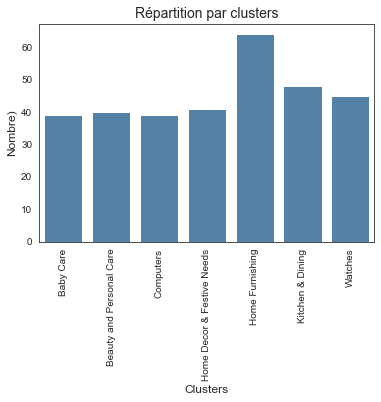

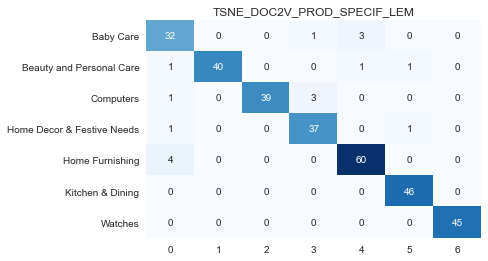

'Précision: 94.62%'

                            precision    recall  f1-score   support

                 Baby Care       0.82      0.89      0.85        36
  Beauty and Personal Care       1.00      0.93      0.96        43
                 Computers       1.00      0.91      0.95        43
Home Decor & Festive Needs       0.90      0.95      0.92        39
           Home Furnishing       0.94      0.94      0.94        64
          Kitchen & Dining       0.96      1.00      0.98        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.95       316
                 macro avg       0.95      0.94      0.94       316
              weighted avg       0.95      0.95      0.95       316


In [127]:
outils_nlp.classifier_pycaret(data_cat, vector_doc2v_prod_lem, titre)

In [128]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.9182', '0.9462', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
6  TSNE_DOC2V_PROD_SPECIF_LEM         0.9182        0.9462

<span style='background:Moccasin'>**3.1.8. product_specifications** - stemmatisée</span>

**Modélisation**

In [129]:
data['product_specifications_stem'] = \
    data['product_specifications_stem'].fillna('').astype(str)

In [130]:
# Création corpus
corpus_prod_stem = outils_nlp.read_corpus(data, 'product_specifications_stem')
corpus_prod_stem = list(corpus_prod_stem)
# Instanciation du modèle
doc2v_model_prod_stem = doc2vec.Doc2Vec(min_count=5, window=3,
                                        size=text_dim, workers=cores-1,
                                        dm=0, dbow_words=1, epochs=100,
                                        dm_mean=0, seed=seed)
# Construit le vocabulaire à partir d'une séquence de mots et
# initialise ainsi le modèle.
doc2v_model_prod_stem.build_vocab(corpus_prod_stem,
                                  progress_per=10000)
# Entraînement du modèle
doc2v_model_prod_stem.train(corpus_prod_stem,
                            total_examples=doc2v_model_prod_stem
                            .corpus_count,
                            epochs=doc2v_model_prod_stem.epochs,
                            report_delay=1)
# Vectorisation
vector_doc2v_prod_stem = doc2v_model_prod_stem.docvecs.vectors_docs

In [131]:
titre = 'TSNE_DOC2V_PROD_SPECIF_STEM'

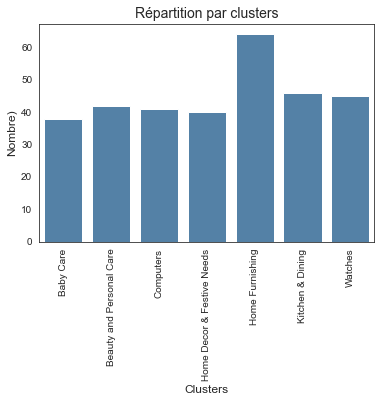

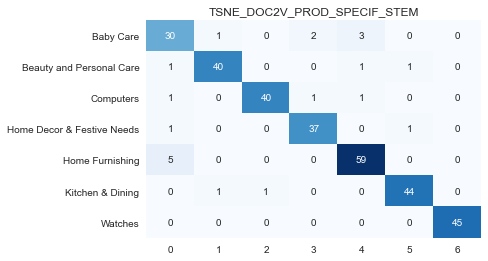

'Précision: 93.35%'

                            precision    recall  f1-score   support

                 Baby Care       0.79      0.83      0.81        36
  Beauty and Personal Care       0.95      0.93      0.94        43
                 Computers       0.98      0.93      0.95        43
Home Decor & Festive Needs       0.93      0.95      0.94        39
           Home Furnishing       0.92      0.92      0.92        64
          Kitchen & Dining       0.96      0.96      0.96        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.93       316
                 macro avg       0.93      0.93      0.93       316
              weighted avg       0.93      0.93      0.93       316


In [132]:
outils_nlp.classifier_pycaret(data_cat, vector_doc2v_prod_stem, titre)

In [133]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.9115', '0.9335', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
7  TSNE_DOC2V_PROD_SPECIF_STEM         0.9115        0.9335

<span style='background:Moccasin'>**3.1.9. brand** - originale (non nettoyée)</span>

**Modélisation**

In [135]:
data['brand'] = \
    data['brand'].fillna('').astype(str)

In [136]:
# Création corpus
corpus_brand_orig = outils_nlp.read_corpus(data, 'brand')
corpus_brand_orig = list(corpus_brand_orig)
# Instanciation du modèle
doc2v_model_brand_orig = doc2vec.Doc2Vec(min_count=5, window=3,
                                         size=text_dim, workers=cores-1,
                                         dm=0, dbow_words=1, epochs=100,
                                         dm_mean=0, seed=seed)
# Construit le vocabulaire à partir d'une séquence de mots et
# initialise ainsi le modèle.
doc2v_model_brand_orig.build_vocab(corpus_brand_orig,
                                   progress_per=10000)
# Entraînement du modèle
doc2v_model_brand_orig.train(corpus_brand_orig,
                             total_examples=doc2v_model_brand_orig
                             .corpus_count,
                             epochs=doc2v_model_brand_orig.epochs,
                             report_delay=1)
# Vectorisation
vector_doc2v_brand_orig = doc2v_model_brand_orig.docvecs.vectors_docs

In [137]:
titre = 'TSNE_DOC2V_BRAND_ORIG'

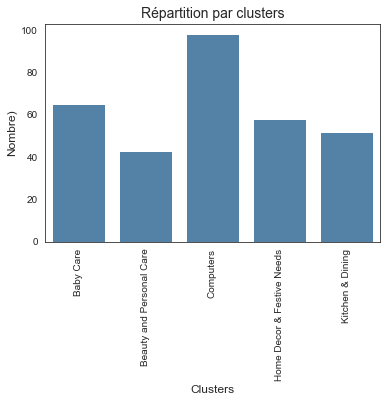

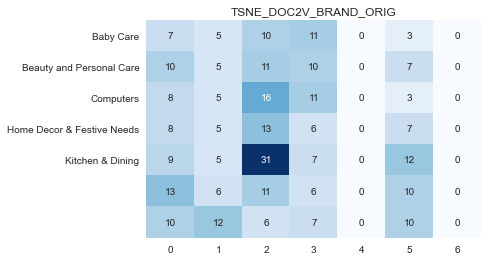

'Précision: 13.92%'

                            precision    recall  f1-score   support

                 Baby Care       0.11      0.19      0.14        36
  Beauty and Personal Care       0.12      0.12      0.12        43
                 Computers       0.16      0.37      0.23        43
Home Decor & Festive Needs       0.10      0.15      0.12        39
           Home Furnishing       0.00      0.00      0.00        64
          Kitchen & Dining       0.19      0.22      0.20        46
                   Watches       0.00      0.00      0.00        45

                  accuracy                           0.14       316
                 macro avg       0.10      0.15      0.12       316
              weighted avg       0.09      0.14      0.11       316


In [138]:
outils_nlp.classifier_pycaret(data_cat, vector_doc2v_brand_orig, titre)

In [139]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.2028', '0.1392', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
8  TSNE_DOC2V_BRAND_ORIG         0.2028        0.1392

<span style='background:Moccasin'>**3.1.10. brand** - nettoyée non racinisée, non lemmatisée</span>

**Modélisation**

In [140]:
data['brand_clean'] = \
    data['brand_clean'].fillna('').astype(str)

In [141]:
# Création corpus
corpus_brand_clean = outils_nlp.read_corpus(data, 'brand_clean')
corpus_brand_clean = list(corpus_brand_clean)
# Instanciation du modèle
doc2v_model_brand_clean = doc2vec.Doc2Vec(min_count=5, window=3,
                                          size=text_dim, workers=cores-1,
                                          dm=0, dbow_words=1, epochs=100,
                                          dm_mean=0, seed=seed)
# Construit le vocabulaire à partir d'une séquence de mots et
# initialise ainsi le modèle.
doc2v_model_brand_clean.build_vocab(corpus_brand_clean,
                                    progress_per=10000)
# Entraînement du modèle
doc2v_model_brand_clean.train(corpus_brand_clean,
                              total_examples=doc2v_model_brand_clean
                              .corpus_count,
                              epochs=doc2v_model_brand_clean.epochs,
                              report_delay=1)
# Vectorisation
vector_doc2v_brand_clean = doc2v_model_brand_clean.docvecs.vectors_docs
# Dataframe pour réduction de dimension
df_doc2v_brand_clean = pd.DataFrame(vector_doc2v_brand_clean)

In [142]:
titre = 'TSNE_DOC2V_BRAND_CLEAN'

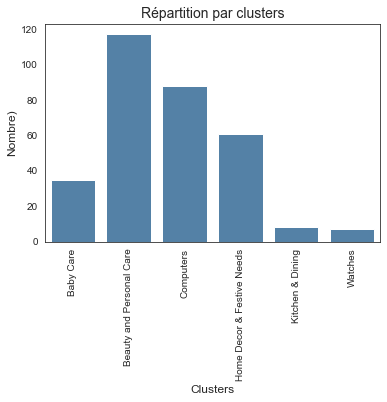

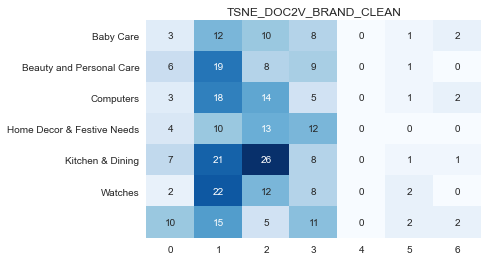

'Précision: 16.46%'

                            precision    recall  f1-score   support

                 Baby Care       0.09      0.08      0.08        36
  Beauty and Personal Care       0.16      0.44      0.24        43
                 Computers       0.16      0.33      0.21        43
Home Decor & Festive Needs       0.20      0.31      0.24        39
           Home Furnishing       0.00      0.00      0.00        64
          Kitchen & Dining       0.25      0.04      0.07        46
                   Watches       0.29      0.04      0.08        45

                  accuracy                           0.16       316
                 macro avg       0.16      0.18      0.13       316
              weighted avg       0.15      0.16      0.12       316


In [143]:
outils_nlp.classifier_pycaret(data_cat, vector_doc2v_brand_clean, titre)

In [144]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.1976', '0.1646', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
9  TSNE_DOC2V_BRAND_CLEAN         0.1976        0.1646

<span style='background:Moccasin'>**3.1.10. brand** - lemmatisée</span>

**Modélisation**

In [145]:
data['brand_lemma'] = \
    data['brand_lemma'].fillna('').astype(str)

In [146]:
# Création corpus
corpus_brand_lem = outils_nlp.read_corpus(data, 'brand_lemma')
corpus_brand_lem = list(corpus_brand_lem)
# Instanciation du modèle
doc2v_model_brand_lem = doc2vec.Doc2Vec(min_count=5, window=3,
                                        size=text_dim, workers=cores-1,
                                        dm=0, dbow_words=1, epochs=100,
                                        dm_mean=0, seed=seed)
# Construit le vocabulaire à partir d'une séquence de mots et
# initialise ainsi le modèle.
doc2v_model_brand_lem.build_vocab(corpus_brand_lem,
                                  progress_per=10000)
# Entraînement du modèle
doc2v_model_brand_lem.train(corpus_brand_lem,
                            total_examples=doc2v_model_brand_lem
                            .corpus_count,
                            epochs=doc2v_model_brand_lem.epochs,
                            report_delay=1)
# Vectorisation
vector_doc2v_brand_lem = doc2v_model_brand_lem.docvecs.vectors_docs

In [147]:
titre = 'TSNE_DOC2V_BRAND_LEM'

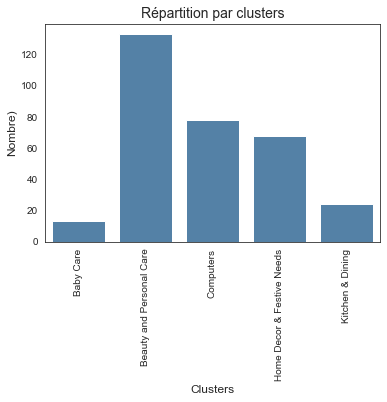

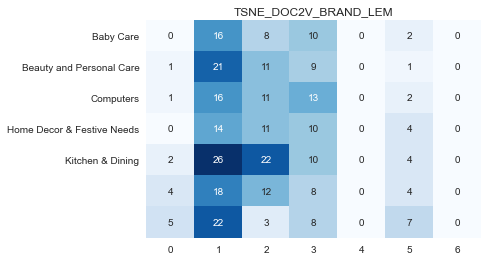

'Précision: 14.56%'

                            precision    recall  f1-score   support

                 Baby Care       0.00      0.00      0.00        36
  Beauty and Personal Care       0.16      0.49      0.24        43
                 Computers       0.14      0.26      0.18        43
Home Decor & Festive Needs       0.15      0.26      0.19        39
           Home Furnishing       0.00      0.00      0.00        64
          Kitchen & Dining       0.17      0.09      0.11        46
                   Watches       0.00      0.00      0.00        45

                  accuracy                           0.15       316
                 macro avg       0.09      0.16      0.10       316
              weighted avg       0.08      0.15      0.10       316


In [148]:
outils_nlp.classifier_pycaret(data_cat, vector_doc2v_brand_lem, titre)

In [149]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.2112', '0.1456', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
10  TSNE_DOC2V_BRAND_LEM         0.2112        0.1456

<span style='background:Moccasin'>**3.1.11. brand** - stemmatisée</span>

**Modélisation**

In [150]:
data['brand_stem'] = \
    data['brand_stem'].fillna('').astype(str)

In [151]:
# Création corpus
corpus_brand_stem = outils_nlp.read_corpus(data, 'brand_stem')
corpus_brand_stem = list(corpus_brand_stem)
# Instanciation du modèle
doc2v_model_brand_stem = doc2vec.Doc2Vec(min_count=5, window=3,
                                         size=text_dim, workers=cores-1,
                                         dm=0, dbow_words=1, epochs=100,
                                         dm_mean=0, seed=seed)
# Construit le vocabulaire à partir d'une séquence de mots et
# initialise ainsi le modèle.
doc2v_model_brand_stem.build_vocab(corpus_brand_stem,
                                   progress_per=10000)
# Entraînement du modèle
doc2v_model_brand_stem.train(corpus_brand_stem,
                             total_examples=doc2v_model_brand_stem
                             .corpus_count,
                             epochs=doc2v_model_brand_stem.epochs,
                             report_delay=1)
# Vectorisation
vector_doc2v_brand_stem = doc2v_model_brand_stem.docvecs.vectors_docs

In [152]:
titre = 'TSNE_DOC2V_BRAND_STEM'

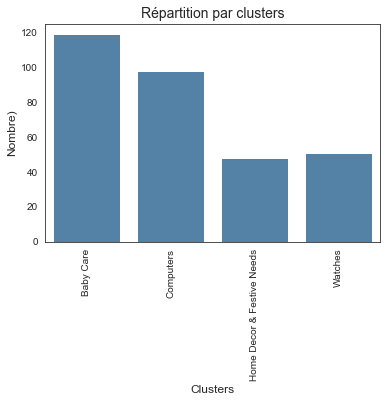

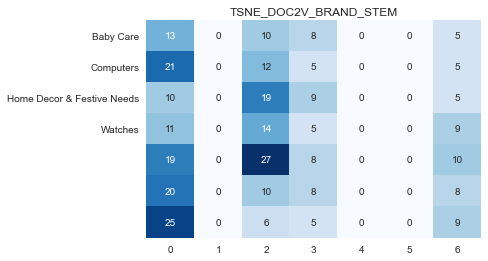

'Précision: 14.56%'

                            precision    recall  f1-score   support

                 Baby Care       0.11      0.36      0.17        36
  Beauty and Personal Care       0.00      0.00      0.00        43
                 Computers       0.19      0.44      0.27        43
Home Decor & Festive Needs       0.10      0.13      0.11        39
           Home Furnishing       0.00      0.00      0.00        64
          Kitchen & Dining       0.00      0.00      0.00        46
                   Watches       0.18      0.20      0.19        45

                  accuracy                           0.15       316
                 macro avg       0.08      0.16      0.11       316
              weighted avg       0.08      0.15      0.10       316


In [153]:
outils_nlp.classifier_pycaret(data_cat, vector_doc2v_brand_stem, titre)

In [154]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.2058', '0.1456', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
11  TSNE_DOC2V_BRAND_STEM         0.2058        0.1456

<span style='background:Moccasin'>**3.1.12. product_name** - originale (non nettoyée)</span>

**Modélisation**

In [155]:
# Création corpus
corpus_prodname_orig = outils_nlp.read_corpus(data, 'product_name')
corpus_prodname_orig = list(corpus_prodname_orig)
# Instanciation du modèle
doc2v_model_prodname_orig = doc2vec.Doc2Vec(min_count=5, window=3,
                                            size=text_dim, workers=cores-1,
                                            dm=0, dbow_words=1, epochs=100,
                                            dm_mean=0, seed=seed)
# Construit le vocabulaire à partir d'une séquence de mots et
# initialise ainsi le modèle.
doc2v_model_prodname_orig.build_vocab(corpus_prodname_orig,
                                      progress_per=10000)
# Entraînement du modèle
doc2v_model_prodname_orig.train(corpus_prodname_orig,
                                total_examples=doc2v_model_prodname_orig
                                .corpus_count,
                                epochs=doc2v_model_prodname_orig.epochs,
                                report_delay=1)
# Vectorisation
vector_doc2v_prodname_orig = doc2v_model_prodname_orig.docvecs.vectors_docs

In [156]:
titre = 'TSNE_DOC2V_PROD_NAME_ORIG'

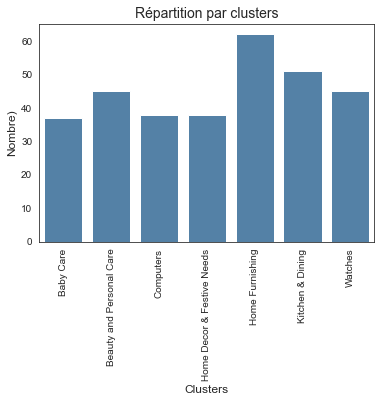

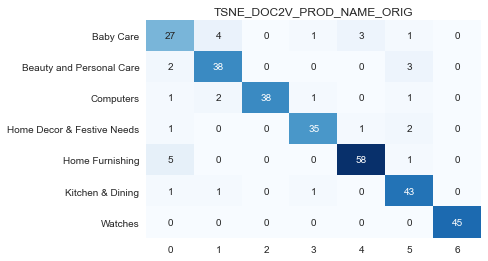

'Précision: 89.87%'

                            precision    recall  f1-score   support

                 Baby Care       0.73      0.75      0.74        36
  Beauty and Personal Care       0.84      0.88      0.86        43
                 Computers       1.00      0.88      0.94        43
Home Decor & Festive Needs       0.92      0.90      0.91        39
           Home Furnishing       0.94      0.91      0.92        64
          Kitchen & Dining       0.84      0.93      0.89        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.90       316
                 macro avg       0.90      0.89      0.89       316
              weighted avg       0.90      0.90      0.90       316


In [157]:
outils_nlp.classifier_pycaret(data_cat, vector_doc2v_prodname_orig, titre)

In [158]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.8486', '0.8987', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
12  TSNE_DOC2V_PROD_NAME_ORIG         0.8486        0.8987

<span style='background:Moccasin'>**3.1.13. product_name** - nettoyée, non racinisée et non lemmatisée</span>

**Modélisation**

In [159]:
# Création corpus
corpus_prodname_clean = outils_nlp.read_corpus(data, 'product_name_clean')
corpus_prodname_clean = list(corpus_prodname_clean)
# Instanciation du modèle
doc2v_model_prodname_clean = doc2vec.Doc2Vec(min_count=5, window=3,
                                             size=text_dim, workers=cores-1,
                                             dm=0, dbow_words=1, epochs=100,
                                             dm_mean=0, seed=seed)
# Construit le vocabulaire à partir d'une séquence de mots et
# initialise ainsi le modèle.
doc2v_model_prodname_clean.build_vocab(corpus_prodname_clean,
                                       progress_per=10000)
# Entraînement du modèle
doc2v_model_prodname_clean.train(corpus_prodname_clean,
                                 total_examples=doc2v_model_prodname_clean
                                 .corpus_count,
                                 epochs=doc2v_model_prodname_clean.epochs,
                                 report_delay=1)
# Vectorisation
vector_doc2v_prodname_clean = doc2v_model_prodname_clean.docvecs.vectors_docs


In [160]:
titre = 'TSNE_DOC2V_PROD_NAME_CLEAN'

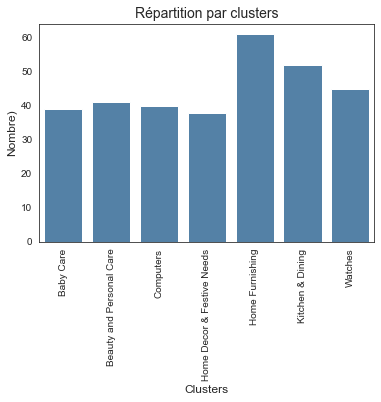

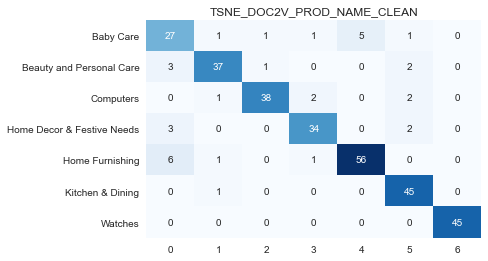

'Précision: 89.24%'

                            precision    recall  f1-score   support

                 Baby Care       0.69      0.75      0.72        36
  Beauty and Personal Care       0.90      0.86      0.88        43
                 Computers       0.95      0.88      0.92        43
Home Decor & Festive Needs       0.89      0.87      0.88        39
           Home Furnishing       0.92      0.88      0.90        64
          Kitchen & Dining       0.87      0.98      0.92        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.89       316
                 macro avg       0.89      0.89      0.89       316
              weighted avg       0.90      0.89      0.89       316


In [161]:
outils_nlp.classifier_pycaret(data_cat, vector_doc2v_prodname_clean, titre)

In [162]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.8636', '0.8924', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
13  TSNE_DOC2V_PROD_NAME_CLEAN         0.8636        0.8924

<span style='background:Moccasin'>**3.1.14. product_name** - lemmatisée</span>

**Modélisation**

In [163]:
data['description_clean_lemma'] = \
    data['description_clean_lemma'].fillna('').astype(str)

In [164]:
# Création corpus
corpus_prodname_lem = outils_nlp.read_corpus(data, 'product_name_lemma')
corpus_prodname_lem = list(corpus_prodname_lem)
# Instanciation du modèle
doc2v_model_prodname_lem = doc2vec.Doc2Vec(min_count=5, window=3,
                                           size=text_dim, workers=cores-1,
                                           dm=0, dbow_words=1, epochs=100,
                                           dm_mean=0, seed=seed)
# Construit le vocabulaire à partir d'une séquence de mots et
# initialise ainsi le modèle.
doc2v_model_prodname_lem.build_vocab(corpus_prodname_lem,
                                     progress_per=10000)
# Entraînement du modèle
doc2v_model_prodname_lem.train(corpus_prodname_lem,
                               total_examples=doc2v_model_prodname_lem
                               .corpus_count,
                               epochs=doc2v_model_prodname_lem.epochs,
                               report_delay=1)
# Vectorisation
vector_doc2v_prodname_lem = doc2v_model_prodname_lem.docvecs.vectors_docs
# Dataframe pour réduction de dimension
df_doc2v_prodname_lem = pd.DataFrame(vector_doc2v_prodname_lem)

In [165]:
titre = 'TSNE_DOC2V_PROD_NAME_LEM'

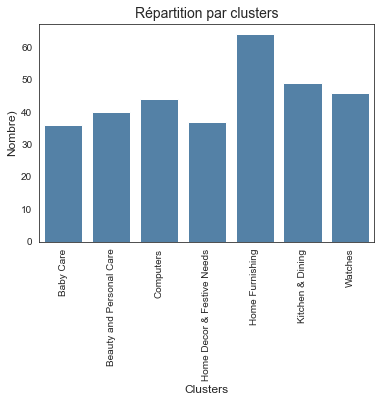

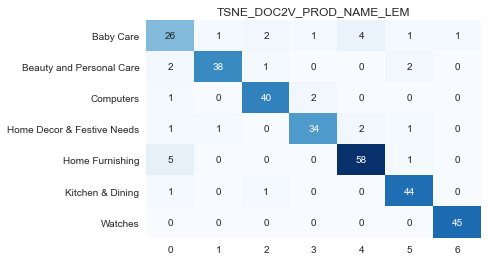

'Précision: 90.19%'

                            precision    recall  f1-score   support

                 Baby Care       0.72      0.72      0.72        36
  Beauty and Personal Care       0.95      0.88      0.92        43
                 Computers       0.91      0.93      0.92        43
Home Decor & Festive Needs       0.92      0.87      0.89        39
           Home Furnishing       0.91      0.91      0.91        64
          Kitchen & Dining       0.90      0.96      0.93        46
                   Watches       0.98      1.00      0.99        45

                  accuracy                           0.90       316
                 macro avg       0.90      0.90      0.90       316
              weighted avg       0.90      0.90      0.90       316


In [166]:
outils_nlp.classifier_pycaret(data_cat, vector_doc2v_prodname_lem, titre)

In [167]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.8692', '0.9019', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
14  TSNE_DOC2V_PROD_NAME_LEM         0.8692        0.9019

<span style='background:Moccasin'>**3.1.15. product_name** - stemmatisée</span>

**Modélisation**

In [168]:
# Création corpus
corpus_prodname_stem = outils_nlp.read_corpus(data, 'product_name_stem')
corpus_prodname_stem = list(corpus_prodname_stem)
# Instanciation du modèle
doc2v_model_prodname_stem = doc2vec.Doc2Vec(min_count=5, window=3,
                                            size=text_dim, workers=cores-1,
                                            dm=0, dbow_words=1, epochs=100,
                                            dm_mean=0, seed=seed)
# Construit le vocabulaire à partir d'une séquence de mots et
# initialise ainsi le modèle.
doc2v_model_prodname_stem.build_vocab(corpus_prodname_stem,
                                      progress_per=10000)
# Entraînement du modèle
doc2v_model_prodname_stem.train(corpus_prodname_stem,
                                total_examples=doc2v_model_prodname_stem
                                .corpus_count,
                                epochs=doc2v_model_prodname_stem.epochs,
                                report_delay=1)
# Vectorisation
vector_doc2v_prodname_stem = doc2v_model_prodname_stem.docvecs.vectors_docs

In [169]:
titre = 'TSNE_DOC2V_PROD_NAME_STEM'

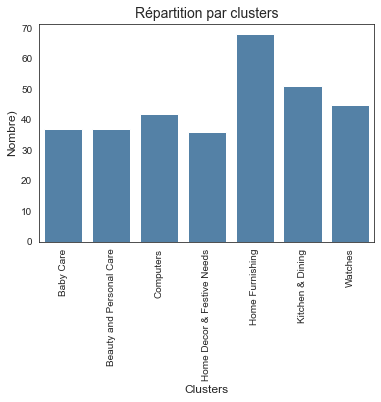

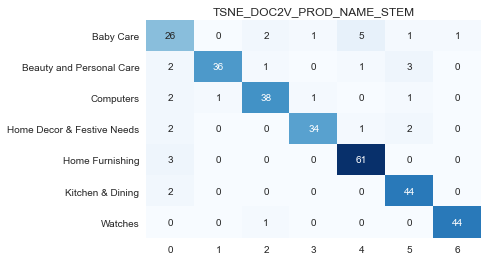

'Précision: 89.56%'

                            precision    recall  f1-score   support

                 Baby Care       0.70      0.72      0.71        36
  Beauty and Personal Care       0.97      0.84      0.90        43
                 Computers       0.90      0.88      0.89        43
Home Decor & Festive Needs       0.94      0.87      0.91        39
           Home Furnishing       0.90      0.95      0.92        64
          Kitchen & Dining       0.86      0.96      0.91        46
                   Watches       0.98      0.98      0.98        45

                  accuracy                           0.90       316
                 macro avg       0.89      0.89      0.89       316
              weighted avg       0.90      0.90      0.90       316


In [170]:
outils_nlp.classifier_pycaret(data_cat, vector_doc2v_prodname_stem, titre)

In [171]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.8541', '0.8956', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
15  TSNE_DOC2V_PROD_NAME_STEM         0.8541        0.8956

<span style='background:Moccasin'>**3.1.16. Mixte - original** - combinaison des variables product_name + brand + description + product_specifications</span>

**Modélisation**

In [172]:
data['all_orig'] = data['product_name'] + data['brand'] + \
    data['description'] + data['product_specifications']

In [173]:
# Création corpus
corpus_all_orig = outils_nlp.read_corpus(data, 'all_orig')
corpus_all_orig = list(corpus_all_orig)
# Instanciation du modèle
doc2v_model_all_orig = doc2vec.Doc2Vec(min_count=5, window=3,
                                       size=text_dim, workers=cores-1,
                                       dm=0, dbow_words=1, epochs=100,
                                       dm_mean=0, seed=seed)
# Construit le vocabulaire à partir d'une séquence de mots et
# initialise ainsi le modèle.
doc2v_model_all_orig.build_vocab(corpus_all_orig,
                                 progress_per=10000)
# Entraînement du modèle
doc2v_model_all_orig.train(corpus_all_orig,
                           total_examples=doc2v_model_all_orig
                           .corpus_count,
                           epochs=doc2v_model_all_orig.epochs,
                           report_delay=1)
# Vectorisation
vector_doc2v_all_orig = doc2v_model_all_orig.docvecs.vectors_docs

In [174]:
titre = 'TSNE_DOC2V_ALL_ORIG'

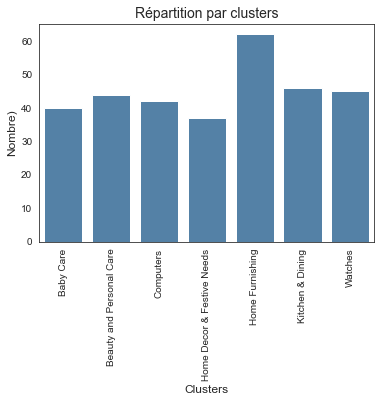

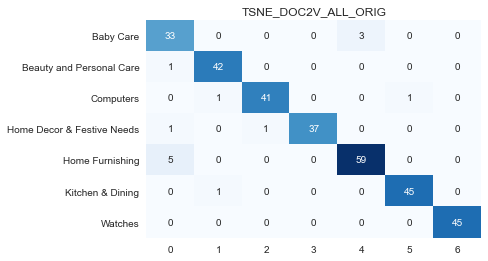

'Précision: 95.57%'

                            precision    recall  f1-score   support

                 Baby Care       0.82      0.92      0.87        36
  Beauty and Personal Care       0.95      0.98      0.97        43
                 Computers       0.98      0.95      0.96        43
Home Decor & Festive Needs       1.00      0.95      0.97        39
           Home Furnishing       0.95      0.92      0.94        64
          Kitchen & Dining       0.98      0.98      0.98        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.96       316
                 macro avg       0.96      0.96      0.96       316
              weighted avg       0.96      0.96      0.96       316


In [175]:
outils_nlp.classifier_pycaret(data_cat, vector_doc2v_all_orig, titre)

In [176]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.9250', '0.9557', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
16  TSNE_DOC2V_ALL_ORIG         0.9250        0.9557

<span style='background:Moccasin'>**3.1.17. Mixte - Nettoyée, non racinisée et non lemmatisée** - combinaison des variables product_name + brand + description + product_specifications</span>

**Modélisation**

In [177]:
data['all_clean'] = data['product_name_clean'] + data['brand_clean'] + \
    data['description_clean'] + data['product_specifications_clean']

In [178]:
# Création corpus
corpus_all_clean = outils_nlp.read_corpus(data, 'all_clean')
corpus_all_clean = list(corpus_all_clean)
# Instanciation du modèle
doc2v_model_all_clean = doc2vec.Doc2Vec(min_count=5, window=3,
                                        size=text_dim, workers=cores-1,
                                        dm=0, dbow_words=1, epochs=100,
                                        dm_mean=0, seed=seed)
# Construit le vocabulaire à partir d'une séquence de mots et
# initialise ainsi le modèle.
doc2v_model_all_clean.build_vocab(corpus_all_clean,
                                  progress_per=10000)
# Entraînement du modèle
doc2v_model_all_clean.train(corpus_all_clean,
                            total_examples=doc2v_model_all_clean
                            .corpus_count,
                            epochs=doc2v_model_all_clean.epochs,
                            report_delay=1)
# Vectorisation
vector_doc2v_all_clean = doc2v_model_all_clean.docvecs.vectors_docs

In [179]:
titre = 'TSNE_DOC2V_ALL_CLEAN'

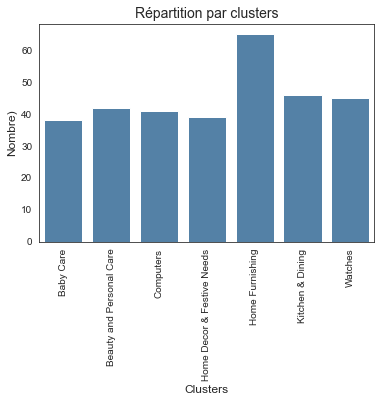

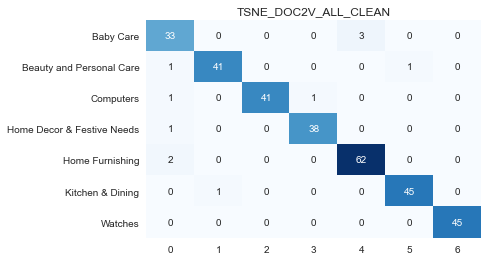

'Précision: 96.52%'

                            precision    recall  f1-score   support

                 Baby Care       0.87      0.92      0.89        36
  Beauty and Personal Care       0.98      0.95      0.96        43
                 Computers       1.00      0.95      0.98        43
Home Decor & Festive Needs       0.97      0.97      0.97        39
           Home Furnishing       0.95      0.97      0.96        64
          Kitchen & Dining       0.98      0.98      0.98        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.97       316
                 macro avg       0.96      0.96      0.96       316
              weighted avg       0.97      0.97      0.97       316


In [180]:
outils_nlp.classifier_pycaret(data_cat, vector_doc2v_all_clean, titre)

In [185]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.9237', '0.9652', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
17  TSNE_DOC2V_ALL_CLEAN         0.9237        0.9652

<span style='background:Moccasin'>**3.1.18. Mixte - lemmatisé** - combinaison des variables product_name + brand + description + product_specifications</span>

**Modélisation**

In [186]:
data['all_lem'] = data['product_name_lemma'] + data['brand_lemma'] + \
    data['description_clean_lemma'] + data['product_specifications_lemma']

In [187]:
# Création corpus
corpus_all_lem = outils_nlp.read_corpus(data, 'all_lem')
corpus_all_lem = list(corpus_all_lem)
# Instanciation du modèle
doc2v_model_all_lem = doc2vec.Doc2Vec(min_count=5, window=3,
                                      size=text_dim, workers=cores-1,
                                      dm=0, dbow_words=1, epochs=100,
                                      dm_mean=0, seed=seed)
# Construit le vocabulaire à partir d'une séquence de mots et
# initialise ainsi le modèle.
doc2v_model_all_lem.build_vocab(corpus_all_lem,
                                progress_per=10000)
# Entraînement du modèle
doc2v_model_all_lem.train(corpus_all_lem,
                          total_examples=doc2v_model_all_lem
                          .corpus_count,
                          epochs=doc2v_model_all_lem.epochs,
                          report_delay=1)
# Vectorisation
vector_doc2v_all_lem = doc2v_model_all_lem.docvecs.vectors_docs
# Dataframe pour réduction de dimension
df_doc2v_all_lem = pd.DataFrame(vector_doc2v_all_lem)

In [188]:
titre = 'TSNE_DOC2V_ALL_LEM'

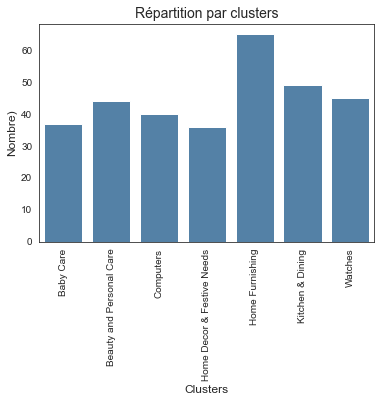

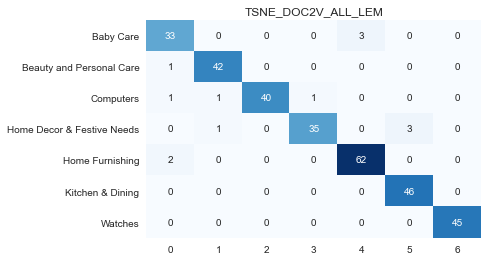

'Précision: 95.89%'

                            precision    recall  f1-score   support

                 Baby Care       0.89      0.92      0.90        36
  Beauty and Personal Care       0.95      0.98      0.97        43
                 Computers       1.00      0.93      0.96        43
Home Decor & Festive Needs       0.97      0.90      0.93        39
           Home Furnishing       0.95      0.97      0.96        64
          Kitchen & Dining       0.94      1.00      0.97        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.96       316
                 macro avg       0.96      0.96      0.96       316
              weighted avg       0.96      0.96      0.96       316


In [189]:
outils_nlp.classifier_pycaret(data_cat, vector_doc2v_all_lem, titre)

In [190]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.9141', '0.9589', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
18  TSNE_DOC2V_ALL_LEM         0.9141        0.9589

<span style='background:Moccasin'>**3.1.19. Mixte - stemmatisé** - combinaison des variables product_name + brand + description + product_specifications</span>

**Modélisation**

In [191]:
data['all_stem'] = data['product_name_stem'] + data['brand_stem'] + \
    data['description_clean_stem'] + data['product_specifications_stem']
data['all_stem'] = \
    data['all_stem'].fillna('').astype(str)

In [192]:
# Création corpus
corpus_all_stem = outils_nlp.read_corpus(data, 'all_stem')
corpus_all_stem = list(corpus_all_stem)
# Instanciation du modèle
doc2v_model_all_stem = doc2vec.Doc2Vec(min_count=5, window=3,
                                       size=text_dim, workers=cores-1,
                                       dm=0, dbow_words=1, epochs=100,
                                       dm_mean=0, seed=seed)
# Construit le vocabulaire à partir d'une séquence de mots et
# initialise ainsi le modèle.
doc2v_model_all_stem.build_vocab(corpus_all_stem,
                                 progress_per=10000)
# Entraînement du modèle
doc2v_model_all_stem.train(corpus_all_stem,
                           total_examples=doc2v_model_all_stem
                           .corpus_count,
                           epochs=doc2v_model_all_stem.epochs,
                           report_delay=1)
# Vectorisation
vector_doc2v_all_stem = doc2v_model_all_stem.docvecs.vectors_docs
# Dataframe pour réduction de dimension
df_doc2v_all_stem = pd.DataFrame(vector_doc2v_all_stem)

In [193]:
titre = 'TSNE_DOC2V_ALL_STEM'

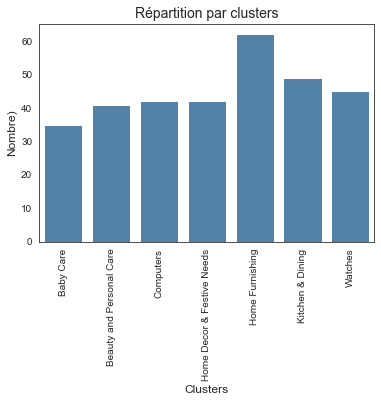

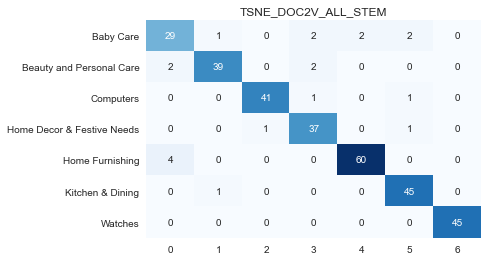

'Précision: 93.67%'

                            precision    recall  f1-score   support

                 Baby Care       0.83      0.81      0.82        36
  Beauty and Personal Care       0.95      0.91      0.93        43
                 Computers       0.98      0.95      0.96        43
Home Decor & Festive Needs       0.88      0.95      0.91        39
           Home Furnishing       0.97      0.94      0.95        64
          Kitchen & Dining       0.92      0.98      0.95        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.94       316
                 macro avg       0.93      0.93      0.93       316
              weighted avg       0.94      0.94      0.94       316


In [194]:
outils_nlp.classifier_pycaret(data_cat, vector_doc2v_all_stem, titre)

In [195]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.9141', '0.9367', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
19  TSNE_DOC2V_ALL_STEM         0.9141        0.9367

## <span style='background:Thistle'>4. Sentence-transformers - BERT</span>

### <span style='background:PowderBlue'>4.1. RoBERTa large model</span>

<span style='background:Moccasin'>**4.1.1. description** - originale (non nettoyée)</span>

In [196]:
# Variable dont on veut extraire les features
data['description'] = \
    data['description'].fillna('').astype(str)
data_desc_orig = data['description']

**Modélisation**

In [197]:
# Instanciation du modèle
bert_desc_orig = SentenceTransformer('roberta-large')
# Encodage
vector_roberta_desc_orig = \
    bert_desc_orig.encode(data_desc_orig, show_progress_bar=False)

Exception when trying to download https://sbert.net/models/roberta-large.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/roberta-large.zip not found. Try to create it from scratch
Try to create Transformer Model roberta-large with mean pooling
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [198]:
titre = 'TSNE_ROBERTA_DESC_ORIG'

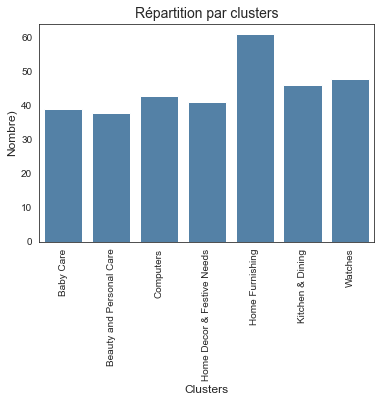

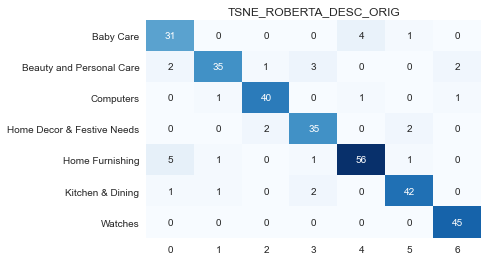

'Précision: 89.87%'

                            precision    recall  f1-score   support

                 Baby Care       0.79      0.86      0.83        36
  Beauty and Personal Care       0.92      0.81      0.86        43
                 Computers       0.93      0.93      0.93        43
Home Decor & Festive Needs       0.85      0.90      0.88        39
           Home Furnishing       0.92      0.88      0.90        64
          Kitchen & Dining       0.91      0.91      0.91        46
                   Watches       0.94      1.00      0.97        45

                  accuracy                           0.90       316
                 macro avg       0.90      0.90      0.90       316
              weighted avg       0.90      0.90      0.90       316


In [199]:
outils_nlp.classifier_pycaret(data_cat, vector_roberta_desc_orig, titre)

In [200]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.8733', '0.8987', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
20  TSNE_ROBERTA_DESC_ORIG         0.8733        0.8987

<span style='background:Moccasin'>**4.1.2. description** - nettoyée (non lemmatisée, non racinisée)</span>

In [201]:
# Variable dont on veut extraire les features
data['description_clean'] = \
    data['description_clean'].fillna('').astype(str)
data_desc_clean = data['description_clean']

**Modélisation**

In [202]:
# Instanciation du modèle
bert_desc_clean = SentenceTransformer('roberta-large')
# Encodage
vector_roberta_desc_clean = \
    bert_desc_clean.encode(data_desc_clean, show_progress_bar=False)

Exception when trying to download https://sbert.net/models/roberta-large.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/roberta-large.zip not found. Try to create it from scratch
Try to create Transformer Model roberta-large with mean pooling
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [203]:
titre = 'TSNE_ROBERTA_DESC_CLEAN'

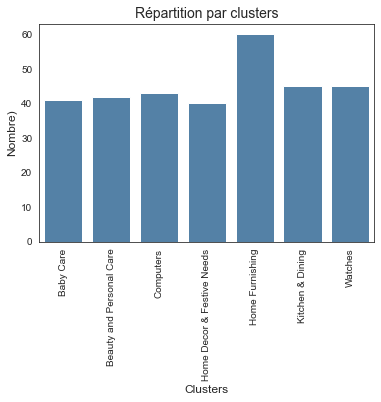

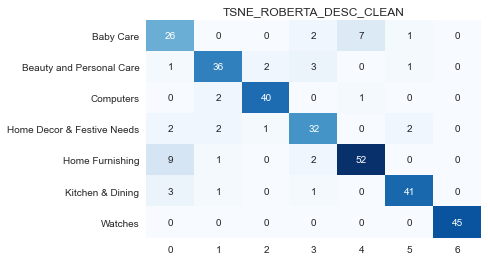

'Précision: 86.08%'

                            precision    recall  f1-score   support

                 Baby Care       0.63      0.72      0.68        36
  Beauty and Personal Care       0.86      0.84      0.85        43
                 Computers       0.93      0.93      0.93        43
Home Decor & Festive Needs       0.80      0.82      0.81        39
           Home Furnishing       0.87      0.81      0.84        64
          Kitchen & Dining       0.91      0.89      0.90        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.86       316
                 macro avg       0.86      0.86      0.86       316
              weighted avg       0.86      0.86      0.86       316


In [204]:
outils_nlp.classifier_pycaret(data_cat, vector_roberta_desc_clean, titre)

In [205]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.8515', '0.8608', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
21  TSNE_ROBERTA_DESC_CLEAN         0.8515        0.8608

<span style='background:Moccasin'>**4.1.3. description** - lemmatisée</span>

In [206]:
# Variable dont on veut extraire les features
data['description_clean_lemma'] = \
    data['description_clean_lemma'].fillna('').astype(str)
data_desc_lem = data['description_clean_lemma']

**Modélisation**

In [207]:
# Instanciation du modèle
bert_desc_lem = SentenceTransformer('roberta-large')
# Encodage
vector_roberta_desc_lem = \
    bert_desc_lem.encode(data_desc_lem, show_progress_bar=False)

Exception when trying to download https://sbert.net/models/roberta-large.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/roberta-large.zip not found. Try to create it from scratch
Try to create Transformer Model roberta-large with mean pooling
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [208]:
titre = 'TSNE_ROBERTA_DESC_LEM'

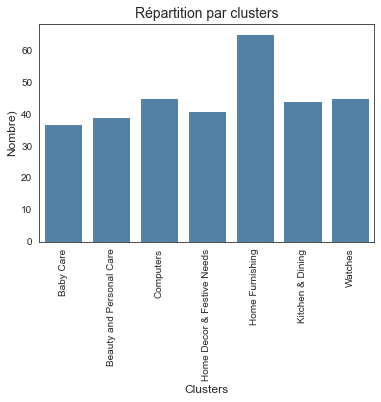

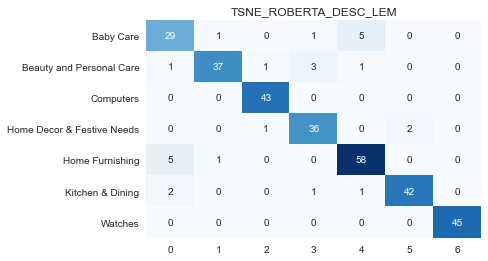

'Précision: 91.77%'

                            precision    recall  f1-score   support

                 Baby Care       0.78      0.81      0.79        36
  Beauty and Personal Care       0.95      0.86      0.90        43
                 Computers       0.96      1.00      0.98        43
Home Decor & Festive Needs       0.88      0.92      0.90        39
           Home Furnishing       0.89      0.91      0.90        64
          Kitchen & Dining       0.95      0.91      0.93        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.92       316
                 macro avg       0.92      0.92      0.92       316
              weighted avg       0.92      0.92      0.92       316


In [209]:
outils_nlp.classifier_pycaret(data_cat, vector_roberta_desc_lem, titre)

In [210]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.8881', '0.9177', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
22  TSNE_ROBERTA_DESC_LEM         0.8881        0.9177

<span style='background:Moccasin'>**4.1.4. description** - stemmatisée</span>

In [211]:
# Variable dont on veut extraire les features
data['description_clean_stem'] = \
    data['description_clean_stem'].fillna('').astype(str)
data_desc_stem = data['description_clean_stem']

**Modélisation**

In [212]:
# Instanciation du modèle
bert_desc_stem = SentenceTransformer('roberta-large')
# Encodage
vector_roberta_desc_stem = \
    bert_desc_stem.encode(data_desc_stem, show_progress_bar=False)

Exception when trying to download https://sbert.net/models/roberta-large.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/roberta-large.zip not found. Try to create it from scratch
Try to create Transformer Model roberta-large with mean pooling
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [213]:
titre = 'TSNE_ROBERTA_DESC_STEM'

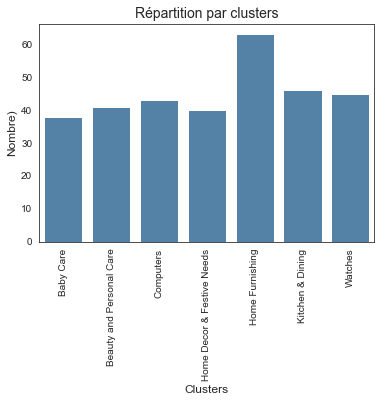

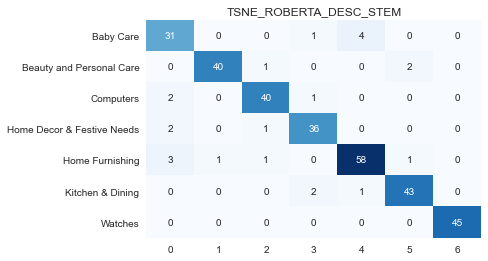

'Précision: 92.72%'

                            precision    recall  f1-score   support

                 Baby Care       0.82      0.86      0.84        36
  Beauty and Personal Care       0.98      0.93      0.95        43
                 Computers       0.93      0.93      0.93        43
Home Decor & Festive Needs       0.90      0.92      0.91        39
           Home Furnishing       0.92      0.91      0.91        64
          Kitchen & Dining       0.93      0.93      0.93        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.93       316
                 macro avg       0.93      0.93      0.93       316
              weighted avg       0.93      0.93      0.93       316


In [214]:
outils_nlp.classifier_pycaret(data_cat, vector_roberta_desc_stem, titre)

In [215]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.8609', '0.9272', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
23  TSNE_ROBERTA_DESC_STEM         0.8609        0.9272

<span style='background:Moccasin'>**4.1.5. product_specifications** - original (non nettoyé)</span>

In [216]:
# Variable dont on veut extraire les features
data['product_specifications'] = \
    data['product_specifications'].fillna('').astype(str)
data_prod_orig = data['product_specifications']

**Modélisation**

In [217]:
# Instanciation du modèle
bert_prod_orig = SentenceTransformer('roberta-large')
# Encodage
vector_roberta_prod_orig = \
    bert_prod_orig.encode(data_prod_orig, show_progress_bar=False)

Exception when trying to download https://sbert.net/models/roberta-large.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/roberta-large.zip not found. Try to create it from scratch
Try to create Transformer Model roberta-large with mean pooling
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [218]:
titre = 'TSNE_ROBERTA_PROD_ORIG'

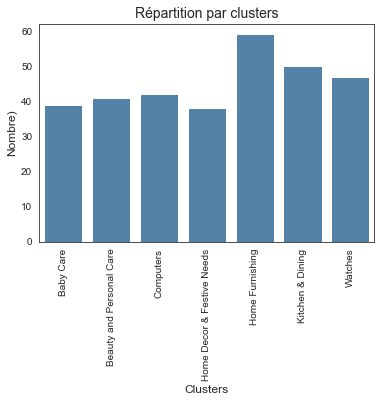

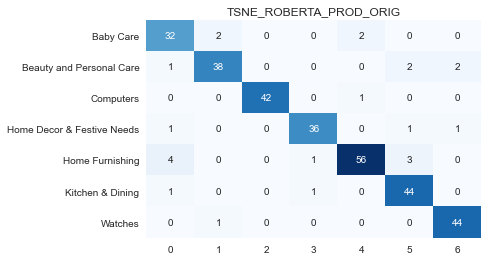

'Précision: 92.41%'

                            precision    recall  f1-score   support

                 Baby Care       0.82      0.89      0.85        36
  Beauty and Personal Care       0.93      0.88      0.90        43
                 Computers       1.00      0.98      0.99        43
Home Decor & Festive Needs       0.95      0.92      0.94        39
           Home Furnishing       0.95      0.88      0.91        64
          Kitchen & Dining       0.88      0.96      0.92        46
                   Watches       0.94      0.98      0.96        45

                  accuracy                           0.92       316
                 macro avg       0.92      0.93      0.92       316
              weighted avg       0.93      0.92      0.92       316


In [219]:
outils_nlp.classifier_pycaret(data_cat, vector_roberta_prod_orig, titre)

In [220]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.8883', '0.9241', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
24  TSNE_ROBERTA_PROD_ORIG         0.8883        0.9241

<span style='background:Moccasin'>**4.1.6. product_specifications** - nettoyé (non racinisé et non lemmatisé)</span>

In [221]:
# Variable dont on veut extraire les features
data['product_specifications_clean'] = \
    data['product_specifications_clean'].fillna('').astype(str)
data_prod_clean = data['product_specifications_clean']

**Modélisation**

In [222]:
# Instanciation du modèle
bert_prod_clean = SentenceTransformer('roberta-large')
# Encodage
vector_roberta_prod_clean = \
    bert_prod_clean.encode(data_prod_clean, show_progress_bar=False)

Exception when trying to download https://sbert.net/models/roberta-large.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/roberta-large.zip not found. Try to create it from scratch
Try to create Transformer Model roberta-large with mean pooling
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [223]:
titre = 'TSNE_ROBERTA_PROD_CLEAN'

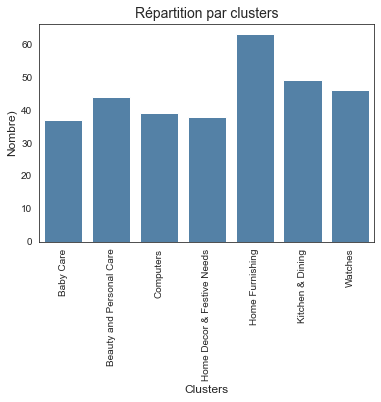

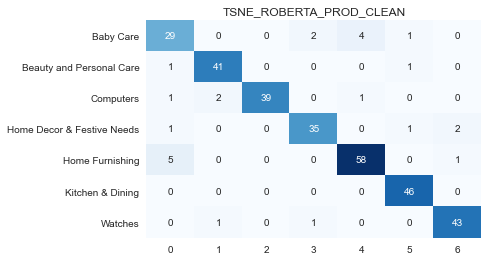

'Précision: 92.09%'

                            precision    recall  f1-score   support

                 Baby Care       0.78      0.81      0.79        36
  Beauty and Personal Care       0.93      0.95      0.94        43
                 Computers       1.00      0.91      0.95        43
Home Decor & Festive Needs       0.92      0.90      0.91        39
           Home Furnishing       0.92      0.91      0.91        64
          Kitchen & Dining       0.94      1.00      0.97        46
                   Watches       0.93      0.96      0.95        45

                  accuracy                           0.92       316
                 macro avg       0.92      0.92      0.92       316
              weighted avg       0.92      0.92      0.92       316


In [224]:
outils_nlp.classifier_pycaret(data_cat, vector_roberta_prod_clean, titre)

In [225]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.9088', '0.9209', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
25  TSNE_ROBERTA_PROD_CLEAN         0.9088        0.9209

<span style='background:Moccasin'>**4.1.7. product_specifications** - lemmatisé</span>

In [226]:
# Variable dont on veut extraire les features
data['product_specifications_lemma'] = \
    data['product_specifications_lemma'].fillna('').astype(str)
data_prod_lem = data['product_specifications_lemma']

**Modélisation**

In [227]:
# Instanciation du modèle
bert_prod_lem = SentenceTransformer('roberta-large')
# Encodage
vector_roberta_prod_lem = \
    bert_prod_lem.encode(data_prod_lem, show_progress_bar=False)

Exception when trying to download https://sbert.net/models/roberta-large.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/roberta-large.zip not found. Try to create it from scratch
Try to create Transformer Model roberta-large with mean pooling
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [228]:
titre = 'TSNE_ROBERTA_PROD_LEM'

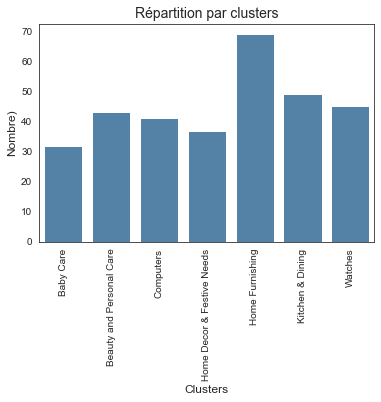

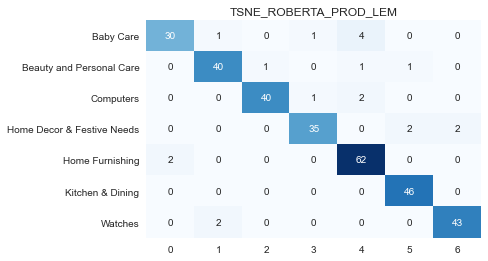

'Précision: 93.67%'

                            precision    recall  f1-score   support

                 Baby Care       0.94      0.83      0.88        36
  Beauty and Personal Care       0.93      0.93      0.93        43
                 Computers       0.98      0.93      0.95        43
Home Decor & Festive Needs       0.95      0.90      0.92        39
           Home Furnishing       0.90      0.97      0.93        64
          Kitchen & Dining       0.94      1.00      0.97        46
                   Watches       0.96      0.96      0.96        45

                  accuracy                           0.94       316
                 macro avg       0.94      0.93      0.93       316
              weighted avg       0.94      0.94      0.94       316


In [229]:
outils_nlp.classifier_pycaret(data_cat, vector_roberta_prod_lem, titre)

In [230]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.9020', '0.9367', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
26  TSNE_ROBERTA_PROD_LEM         0.9020        0.9367

<span style='background:Moccasin'>**4.1.8. product_specifications** - stemmatisé</span>

In [231]:
# Variable dont on veut extraire les features
data['product_specifications_stem'] = \
    data['product_specifications_stem'].fillna('').astype(str)
data_prod_stem = data['product_specifications_stem']

**Modélisation**

In [232]:
# Instanciation du modèle
bert_prod_stem = SentenceTransformer('roberta-large')
# Encodage
vector_roberta_prod_stem = \
    bert_prod_stem.encode(data_prod_stem, show_progress_bar=False)

Exception when trying to download https://sbert.net/models/roberta-large.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/roberta-large.zip not found. Try to create it from scratch
Try to create Transformer Model roberta-large with mean pooling
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [233]:
titre = 'TSNE_ROBERTA_PROD_STEM'

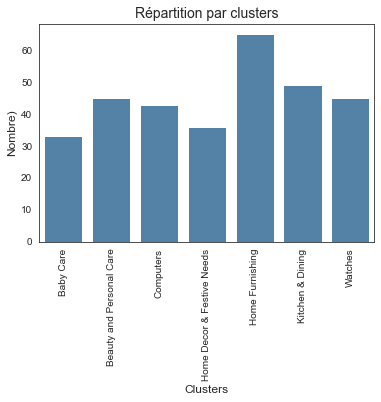

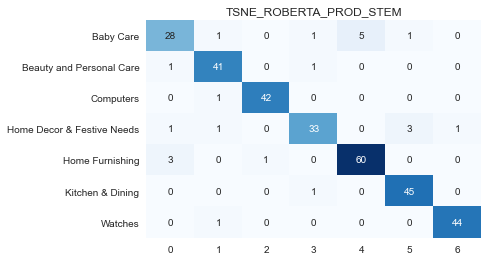

'Précision: 92.72%'

                            precision    recall  f1-score   support

                 Baby Care       0.85      0.78      0.81        36
  Beauty and Personal Care       0.91      0.95      0.93        43
                 Computers       0.98      0.98      0.98        43
Home Decor & Festive Needs       0.92      0.85      0.88        39
           Home Furnishing       0.92      0.94      0.93        64
          Kitchen & Dining       0.92      0.98      0.95        46
                   Watches       0.98      0.98      0.98        45

                  accuracy                           0.93       316
                 macro avg       0.92      0.92      0.92       316
              weighted avg       0.93      0.93      0.93       316


In [234]:
outils_nlp.classifier_pycaret(data_cat, vector_roberta_prod_stem, titre)

In [235]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.9114', '0.9272', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
27  TSNE_ROBERTA_PROD_STEM         0.9114        0.9272

<span style='background:Moccasin'>**4.1.9. product_name** - original (non nettoyé)</span>

In [236]:
# Variable dont on veut extraire les features
data['product_name'] = \
    data['product_name'].fillna('').astype(str)
data_prodname_orig = data['product_name']

**Modélisation**

In [237]:
# Instanciation du modèle
bert_prodname_orig = SentenceTransformer('roberta-large')
# Encodage
vector_roberta_prodname_orig = \
    bert_prodname_orig.encode(data_prodname_orig, show_progress_bar=False)

Exception when trying to download https://sbert.net/models/roberta-large.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/roberta-large.zip not found. Try to create it from scratch
Try to create Transformer Model roberta-large with mean pooling
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [238]:
titre = 'TSNE_ROBERTA_PRODNAME_ORIG'

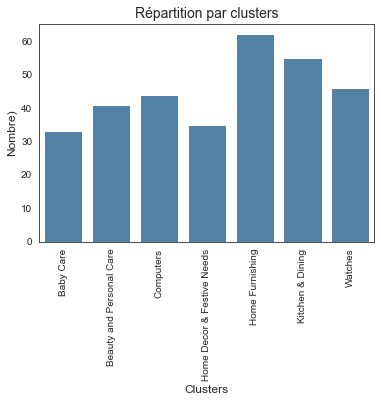

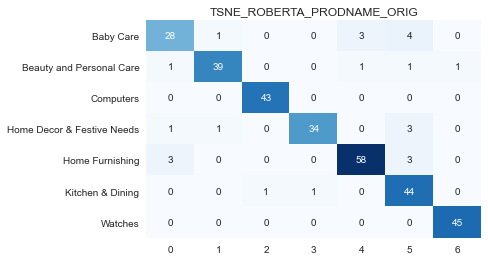

'Précision: 92.09%'

                            precision    recall  f1-score   support

                 Baby Care       0.85      0.78      0.81        36
  Beauty and Personal Care       0.95      0.91      0.93        43
                 Computers       0.98      1.00      0.99        43
Home Decor & Festive Needs       0.97      0.87      0.92        39
           Home Furnishing       0.94      0.91      0.92        64
          Kitchen & Dining       0.80      0.96      0.87        46
                   Watches       0.98      1.00      0.99        45

                  accuracy                           0.92       316
                 macro avg       0.92      0.92      0.92       316
              weighted avg       0.92      0.92      0.92       316


In [239]:
outils_nlp.classifier_pycaret(data_cat, vector_roberta_prodname_orig, titre)

In [240]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.8841', '0.9209', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
28  TSNE_ROBERTA_PRODNAME_ORIG         0.8841        0.9209

<span style='background:Moccasin'>**4.1.6. product_name** - nettoyé (non racinisé et non lemmatisé)</span>

In [241]:
# Variable dont on veut extraire les features
data['product_name_clean'] = \
    data['product_name_clean'].fillna('').astype(str)
data_prodname_clean = data['product_name_clean']

**Modélisation**

In [242]:
# Instanciation du modèle
bert_prodname_clean = SentenceTransformer('roberta-large')
# Encodage
vector_roberta_prodname_clean = \
    bert_prodname_clean.encode(data_prodname_clean, show_progress_bar=False)

Exception when trying to download https://sbert.net/models/roberta-large.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/roberta-large.zip not found. Try to create it from scratch
Try to create Transformer Model roberta-large with mean pooling
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [243]:
titre = 'TSNE_ROBERTA_PROD_NAME_CLEAN'

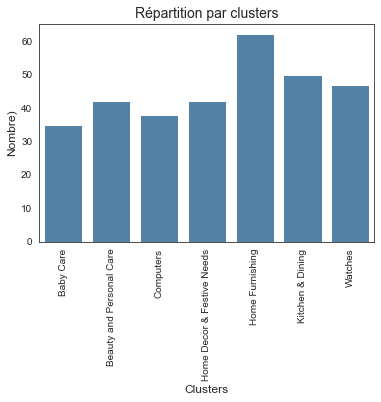

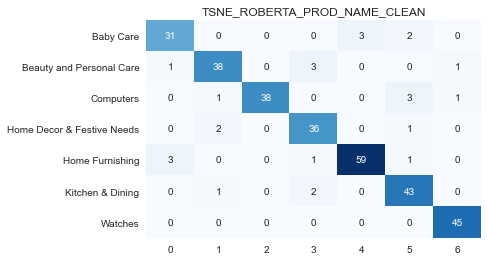

'Précision: 91.77%'

                            precision    recall  f1-score   support

                 Baby Care       0.89      0.86      0.87        36
  Beauty and Personal Care       0.90      0.88      0.89        43
                 Computers       1.00      0.88      0.94        43
Home Decor & Festive Needs       0.86      0.92      0.89        39
           Home Furnishing       0.95      0.92      0.94        64
          Kitchen & Dining       0.86      0.93      0.90        46
                   Watches       0.96      1.00      0.98        45

                  accuracy                           0.92       316
                 macro avg       0.92      0.92      0.92       316
              weighted avg       0.92      0.92      0.92       316


In [244]:
outils_nlp.classifier_pycaret(data_cat, vector_roberta_prodname_clean, titre)

In [245]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.8840', '0.9177', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
29  TSNE_ROBERTA_PROD_NAME_CLEAN         0.8840        0.9177

<span style='background:Moccasin'>**4.1.7. product_name** - lemmatisé</span>

In [246]:
# Variable dont on veut extraire les features
data['product_name_lemma'] = \
    data['product_name_lemma'].fillna('').astype(str)
data_prodname_lem = data['product_name_lemma']

**Modélisation**

In [247]:
# Instanciation du modèle
bert_prodname_lem = SentenceTransformer('roberta-large')
# Encodage
vector_roberta_prodname_lem = \
    bert_prodname_lem.encode(data_prodname_lem, show_progress_bar=False)

Exception when trying to download https://sbert.net/models/roberta-large.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/roberta-large.zip not found. Try to create it from scratch
Try to create Transformer Model roberta-large with mean pooling
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [248]:
titre = 'TSNE_ROBERTA_PROD_NAME_LEM'

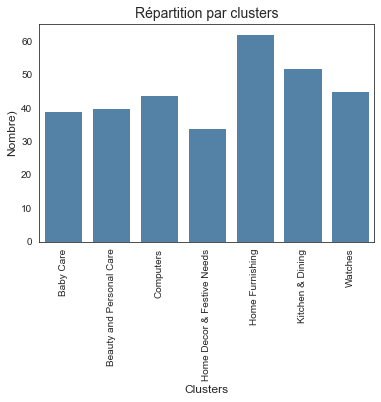

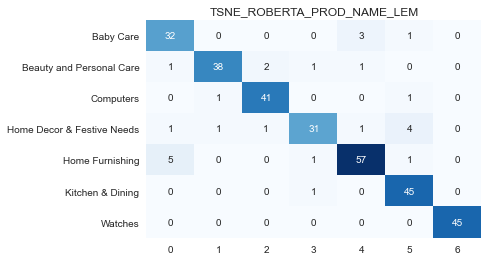

'Précision: 91.46%'

                            precision    recall  f1-score   support

                 Baby Care       0.82      0.89      0.85        36
  Beauty and Personal Care       0.95      0.88      0.92        43
                 Computers       0.93      0.95      0.94        43
Home Decor & Festive Needs       0.91      0.79      0.85        39
           Home Furnishing       0.92      0.89      0.90        64
          Kitchen & Dining       0.87      0.98      0.92        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.91       316
                 macro avg       0.91      0.91      0.91       316
              weighted avg       0.92      0.91      0.91       316


In [249]:
outils_nlp.classifier_pycaret(data_cat, vector_roberta_prodname_lem, titre)

In [250]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.8772', '0.9146', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
30  TSNE_ROBERTA_PROD_NAME_LEM         0.8772        0.9146

<span style='background:Moccasin'>**4.1.10. product_name** - stemmatisé</span>

In [251]:
# Variable dont on veut extraire les features
data['product_name_stem'] = \
    data['product_name_stem'].fillna('').astype(str)
data_prodname_stem = data['product_name_stem']

**Modélisation**

In [252]:
# Instanciation du modèle
bert_prodname_stem = SentenceTransformer('roberta-large')
# Encodage
vector_roberta_prodname_stem = \
    bert_prodname_stem.encode(data_prodname_stem, show_progress_bar=False)

Exception when trying to download https://sbert.net/models/roberta-large.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/roberta-large.zip not found. Try to create it from scratch
Try to create Transformer Model roberta-large with mean pooling
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [253]:
titre = 'TSNE_ROBERTA_PRODNAME_STEM'

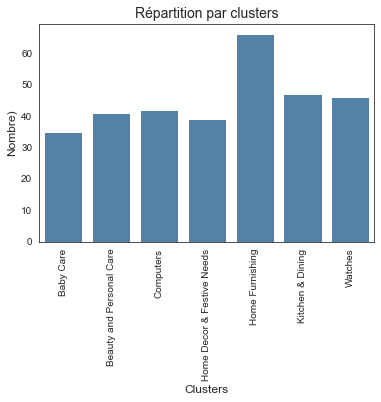

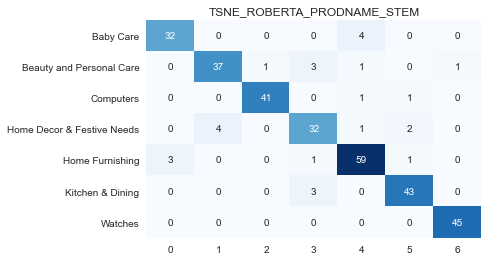

'Précision: 91.46%'

                            precision    recall  f1-score   support

                 Baby Care       0.91      0.89      0.90        36
  Beauty and Personal Care       0.90      0.86      0.88        43
                 Computers       0.98      0.95      0.96        43
Home Decor & Festive Needs       0.82      0.82      0.82        39
           Home Furnishing       0.89      0.92      0.91        64
          Kitchen & Dining       0.91      0.93      0.92        46
                   Watches       0.98      1.00      0.99        45

                  accuracy                           0.91       316
                 macro avg       0.91      0.91      0.91       316
              weighted avg       0.91      0.91      0.91       316


In [254]:
outils_nlp.classifier_pycaret(data_cat, vector_roberta_prodname_stem, titre)

In [ ]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.8622', '', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

<span style='background:Moccasin'>**4.1.11. Mixte** - original (non nettoyé)</span>

In [11]:
# Variable dont on veut extraire les features
data['all_orig'] = data['product_name'] + data['brand']
+ data['description'] + data['product_specifications']
data['all_orig'] = \
    data['all_orig'].fillna('').astype(str)
data_all_orig = data['all_orig']

**Modélisation**

In [12]:
# Instanciation du modèle
bert_all_orig = SentenceTransformer('roberta-large')
# Encodage
vector_roberta_all_orig = \
    bert_all_orig.encode(data_all_orig, show_progress_bar=False)

Exception when trying to download https://sbert.net/models/roberta-large.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/roberta-large.zip not found. Try to create it from scratch
Try to create Transformer Model roberta-large with mean pooling
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
titre = 'TSNE_ROBERTA_ALL_ORIG'

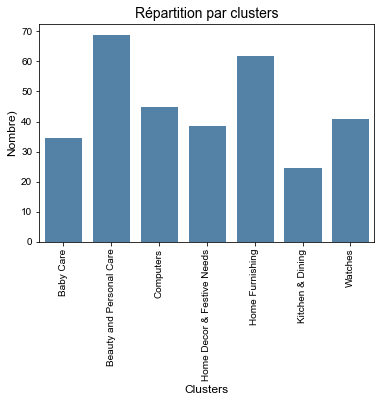

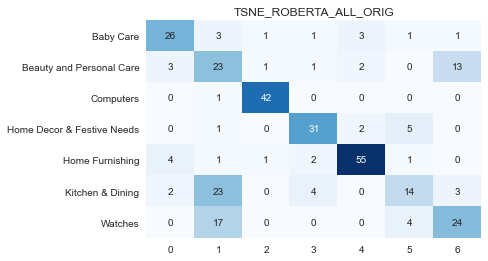

'Précision: 68.04%'

                            precision    recall  f1-score   support

                 Baby Care       0.74      0.72      0.73        36
  Beauty and Personal Care       0.33      0.53      0.41        43
                 Computers       0.93      0.98      0.95        43
Home Decor & Festive Needs       0.79      0.79      0.79        39
           Home Furnishing       0.89      0.86      0.87        64
          Kitchen & Dining       0.56      0.30      0.39        46
                   Watches       0.59      0.53      0.56        45

                  accuracy                           0.68       316
                 macro avg       0.69      0.68      0.67       316
              weighted avg       0.70      0.68      0.68       316


In [14]:
outils_nlp.classifier_pycaret(data_cat, vector_roberta_all_orig, titre)

In [20]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.7125', '0.6804', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
32  TSNE_ROBERTA_ALL_ORIG         0.7125        0.6804

<span style='background:Moccasin'>**4.1.12. Mixte** - stemmatisé</span>

In [21]:
# Variable dont on veut extraire les features
data['all_stem'] = data['product_name_stem'] + data['brand_stem']
+ data['description_clean_stem'] + data['product_specifications_stem']
data['all_stem'] = \
    data['all_stem'].fillna('').astype(str)
data_all_stem = data['all_stem']

**Modélisation**

In [22]:
# Instanciation du modèle
bert_all_stem = SentenceTransformer('roberta-large')
# Encodage
vector_roberta_all_stem = \
    bert_all_stem.encode(data_all_stem, show_progress_bar=False)

Exception when trying to download https://sbert.net/models/roberta-large.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/roberta-large.zip not found. Try to create it from scratch
Try to create Transformer Model roberta-large with mean pooling
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
titre = 'TSNE_ROBERTA_ALL_STEM'

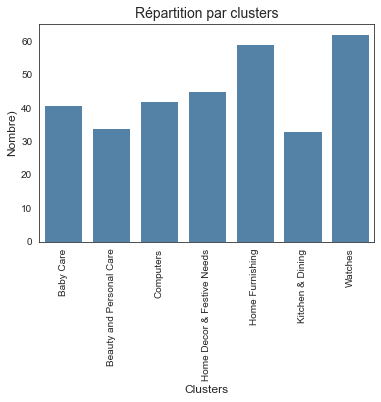

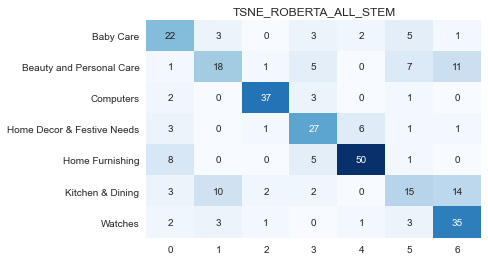

'Précision: 64.56%'

                            precision    recall  f1-score   support

                 Baby Care       0.54      0.61      0.57        36
  Beauty and Personal Care       0.53      0.42      0.47        43
                 Computers       0.88      0.86      0.87        43
Home Decor & Festive Needs       0.60      0.69      0.64        39
           Home Furnishing       0.85      0.78      0.81        64
          Kitchen & Dining       0.45      0.33      0.38        46
                   Watches       0.56      0.78      0.65        45

                  accuracy                           0.65       316
                 macro avg       0.63      0.64      0.63       316
              weighted avg       0.65      0.65      0.64       316


In [24]:
outils_nlp.classifier_pycaret(data_cat, vector_roberta_all_stem, titre)

In [25]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.6226', '0.6456', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
33  TSNE_ROBERTA_ALL_STEM         0.6226        0.6456

<span style='background:Moccasin'>**4.1.13. Mixte** - nom du produit et produit spécification stemmatisés</span>

In [26]:
# Variable dont on veut extraire les features
data['all_prod_stem'] = data['product_name_stem']
+ data['product_specifications_stem']
data['all_prod_stem'] = \
    data['all_prod_stem'].fillna('').astype(str)
data_all_prod_stem = data['all_prod_stem']

**Modélisation**

In [27]:
# Instanciation du modèle
bert_all_prod_stem = SentenceTransformer('roberta-large')
# Encodage
vector_roberta_all_prod_stem = \
    bert_all_prod_stem.encode(data_all_prod_stem,
                              show_progress_bar=False)

Exception when trying to download https://sbert.net/models/roberta-large.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/roberta-large.zip not found. Try to create it from scratch
Try to create Transformer Model roberta-large with mean pooling
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
titre = 'TSNE_ROBERTA_ALL_PROD_STEM'

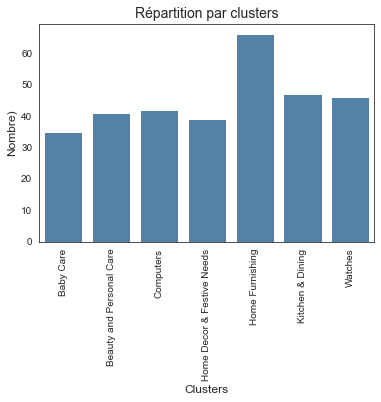

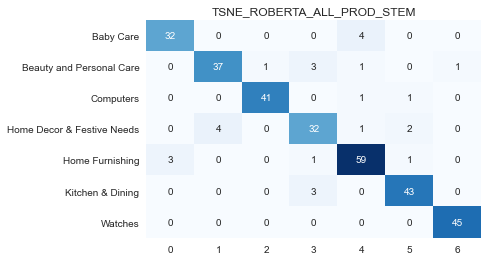

'Précision: 91.46%'

                            precision    recall  f1-score   support

                 Baby Care       0.91      0.89      0.90        36
  Beauty and Personal Care       0.90      0.86      0.88        43
                 Computers       0.98      0.95      0.96        43
Home Decor & Festive Needs       0.82      0.82      0.82        39
           Home Furnishing       0.89      0.92      0.91        64
          Kitchen & Dining       0.91      0.93      0.92        46
                   Watches       0.98      1.00      0.99        45

                  accuracy                           0.91       316
                 macro avg       0.91      0.91      0.91       316
              weighted avg       0.91      0.91      0.91       316


In [29]:
outils_nlp.classifier_pycaret(data_cat, vector_roberta_all_prod_stem, titre)

In [30]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.8622', '0.9146', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
34  TSNE_ROBERTA_ALL_PROD_STEM         0.8622        0.9146

### <span style='background:PowderBlue'>4.2. DistilBERT base model (uncased)</span>

<span style='background:Moccasin'>**4.2.1. product_specifications** - produit spécification stemmatisé</span>

In [31]:
# Variable dont on veut extraire les features
data['product_specifications_stem'] = \
    data['product_specifications_stem'].fillna('').astype(str)
data_prod_stem = data['product_specifications_stem']

**Modélisation**

In [32]:
# Instanciation du modèle
bert_distil_prod_stem = SentenceTransformer('distilbert-base-uncased')
# Encodage
vector_distil_prod_stem = \
    bert_distil_prod_stem.encode(data_prod_stem,
                                 show_progress_bar=False)

Exception when trying to download https://sbert.net/models/distilbert-base-uncased.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/distilbert-base-uncased.zip not found. Try to create it from scratch
Try to create Transformer Model distilbert-base-uncased with mean pooling
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSeque

In [33]:
titre = 'TSNE_DISTIL_PROD_STEM'

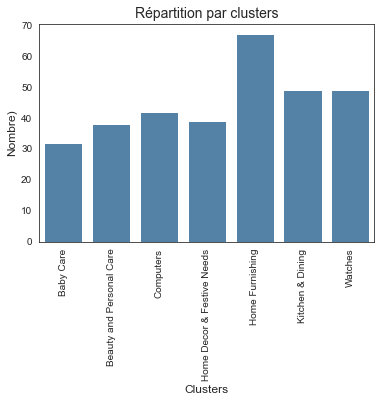

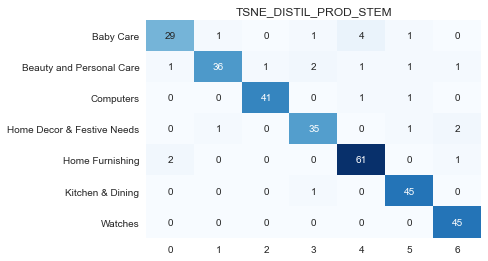

'Précision: 92.41%'

                            precision    recall  f1-score   support

                 Baby Care       0.91      0.81      0.85        36
  Beauty and Personal Care       0.95      0.84      0.89        43
                 Computers       0.98      0.95      0.96        43
Home Decor & Festive Needs       0.90      0.90      0.90        39
           Home Furnishing       0.91      0.95      0.93        64
          Kitchen & Dining       0.92      0.98      0.95        46
                   Watches       0.92      1.00      0.96        45

                  accuracy                           0.92       316
                 macro avg       0.92      0.92      0.92       316
              weighted avg       0.92      0.92      0.92       316


In [34]:
outils_nlp.classifier_pycaret(data_cat, vector_distil_prod_stem, titre)

In [37]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.9101', '0.9241', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
35  TSNE_DISTIL_PROD_STEM         0.9101        0.9241

### <span style='background:PowderBlue'>4.3. DistilBERT base uncased finetuned SST-2</span>

<span style='background:Moccasin'>**4.3.1. product_specifications** - produit spécification stemmatisé</span>

**Modélisation**

In [38]:
# Instanciation du modèle
bert_distilsst2_prod_stem = \
    SentenceTransformer('distilbert-base-uncased-finetuned-sst-2-english')
# Encodage
vector_distilsst2_prod_stem = \
    bert_distilsst2_prod_stem.encode(data_prod_stem,
                                     show_progress_bar=False)

Exception when trying to download https://sbert.net/models/distilbert-base-uncased-finetuned-sst-2-english.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/distilbert-base-uncased-finetuned-sst-2-english.zip not found. Try to create it from scratch
Try to create Transformer Model distilbert-base-uncased-finetuned-sst-2-english with mean pooling
Some weights of the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing DistilBertModel: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassifi

In [39]:
titre = 'TSNE_DISTILSST2_PROD_STEM'

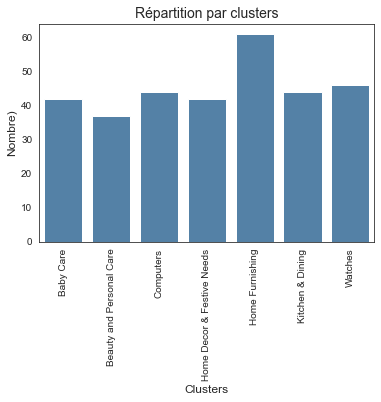

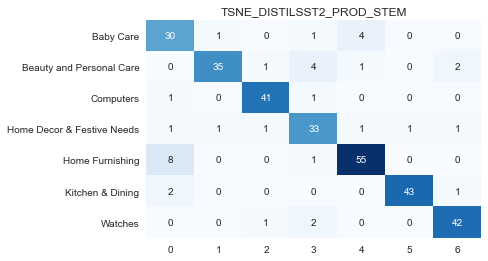

'Précision: 88.29%'

                            precision    recall  f1-score   support

                 Baby Care       0.71      0.83      0.77        36
  Beauty and Personal Care       0.95      0.81      0.88        43
                 Computers       0.93      0.95      0.94        43
Home Decor & Festive Needs       0.79      0.85      0.81        39
           Home Furnishing       0.90      0.86      0.88        64
          Kitchen & Dining       0.98      0.93      0.96        46
                   Watches       0.91      0.93      0.92        45

                  accuracy                           0.88       316
                 macro avg       0.88      0.88      0.88       316
              weighted avg       0.89      0.88      0.88       316


In [41]:
outils_nlp.classifier_pycaret(data_cat, vector_distilsst2_prod_stem, titre)

In [43]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.8405', '0.8829', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
36  TSNE_DISTILSST2_PROD_STEM         0.8405        0.8829

### <span style='background:PowderBlue'>4.3. XML-ROBERTA</span>

<span style='background:Moccasin'>**4.3.1. product_specifications** - stemmatisé</span>

In [44]:
# Variable dont on veut extraire les features
data['product_specifications_stem'] = \
    data['product_specifications_stem'].fillna('').astype(str)
data_prod_stem = data['product_specifications_stem']

In [45]:
# Instanciation du modèle
sentence_xmlroberta = \
    SentenceTransformer('xlm-roberta-large-finetuned-conll03-english')

Exception when trying to download https://sbert.net/models/xlm-roberta-large-finetuned-conll03-english.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/xlm-roberta-large-finetuned-conll03-english.zip not found. Try to create it from scratch
Try to create Transformer Model xlm-roberta-large-finetuned-conll03-english with mean pooling
Some weights of the model checkpoint at xlm-roberta-large-finetuned-conll03-english were not used when initializing XLMRobertaModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Modélisation**

In [46]:
# Encodage
vector_xmlrob_prod_stem = \
    sentence_xmlroberta.encode(data_prod_stem, show_progress_bar=False)

In [47]:
titre = 'TSNE_XML_ROBERTA_PROD_STEM'

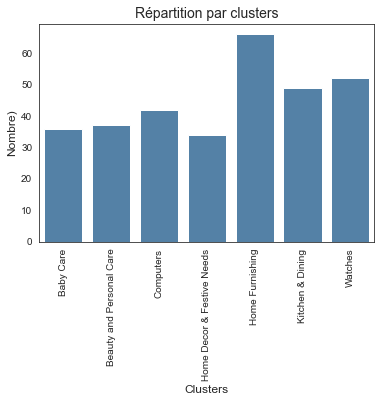

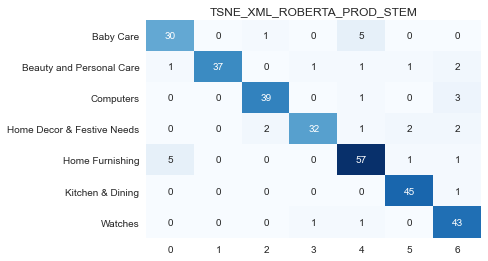

'Précision: 89.56%'

                            precision    recall  f1-score   support

                 Baby Care       0.83      0.83      0.83        36
  Beauty and Personal Care       1.00      0.86      0.92        43
                 Computers       0.93      0.91      0.92        43
Home Decor & Festive Needs       0.94      0.82      0.88        39
           Home Furnishing       0.86      0.89      0.88        64
          Kitchen & Dining       0.92      0.98      0.95        46
                   Watches       0.83      0.96      0.89        45

                  accuracy                           0.90       316
                 macro avg       0.90      0.89      0.89       316
              weighted avg       0.90      0.90      0.90       316


In [48]:
outils_nlp.classifier_pycaret(data_cat, vector_xmlrob_prod_stem, titre)

In [49]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.8678', '0.8956', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
37  TSNE_XML_ROBERTA_PROD_STEM         0.8678        0.8956

## <span style='background:Thistle'>5. Sentence-transformers - USE</span>

In [54]:
# Suppression des waring, info
tf.get_logger().setLevel('ERROR')

### <span style='background:PowderBlue'>5.1. universal-sentence-encoder/4</span>

In [51]:
use_module_url = 'https://tfhub.dev/google/universal-sentence-encoder/4'

<span style='background:Moccasin'>**5.1.1. product_specifications** - produit spécification original (non nettoyé)</span>

In [52]:
# Variable dont on veut extraire les features
data['product_specifications'] = \
    data['product_specifications'].fillna('').astype(str)
data_prod_orig = data['product_specifications']

**Modélisation**

In [53]:
# Chargement du modèle
use_model_prod_orig = hub.load(use_module_url)
print('Module %s Chargé' % use_module_url)

INFO:absl:Using C:\Users\PCMAIS~1\AppData\Local\Temp\tfhub_modules to cache modules.


Module https://tfhub.dev/google/universal-sentence-encoder/4 Chargé


In [54]:
vector_use_prod_orig = use_model_prod_orig(data_prod_orig)

In [55]:
titre = 'TSNE_USE_PROD_ORIG'

INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 2
INFO:logs:ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=21, verbose=0,
                     warm_start=False)
INFO:logs:compare_models() succesfully completed......................................
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_sam

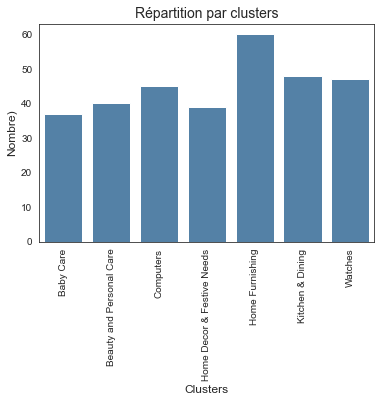

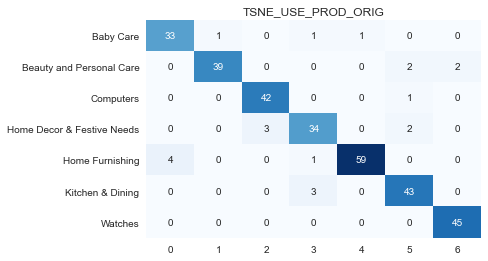

'Précision: 93.35%'

                            precision    recall  f1-score   support

                 Baby Care       0.89      0.92      0.90        36
  Beauty and Personal Care       0.97      0.91      0.94        43
                 Computers       0.93      0.98      0.95        43
Home Decor & Festive Needs       0.87      0.87      0.87        39
           Home Furnishing       0.98      0.92      0.95        64
          Kitchen & Dining       0.90      0.93      0.91        46
                   Watches       0.96      1.00      0.98        45

                  accuracy                           0.93       316
                 macro avg       0.93      0.93      0.93       316
              weighted avg       0.93      0.93      0.93       316


In [56]:
outils_nlp.classifier_pycaret(data_cat, vector_use_prod_orig, titre)

In [57]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.9087', '0.9335', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
38  TSNE_USE_PROD_ORIG         0.9087        0.9335

<span style='background:Moccasin'>**5.1.2. product_specifications** - produit spécification nettoyé</span>

In [58]:
# Variable dont on veut extraire les features
data['product_specifications_clean'] = \
    data['product_specifications_clean'].fillna('').astype(str)
data_prod_clean = data['product_specifications_clean']

**Modélisation**

In [59]:
# Chargement du modèle
use_model_prod_clean = hub.load(use_module_url)
print('Module %s Chargé' % use_module_url)

Module https://tfhub.dev/google/universal-sentence-encoder/4 Chargé


In [60]:
vector_use_prod_clean = use_model_prod_clean(data_prod_clean)

In [61]:
titre = 'TSNE_USE_PROD_CLEAN'

INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 2
INFO:logs:ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=21, verbose=0,
                     warm_start=False)
INFO:logs:compare_models() succesfully completed......................................
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_sam

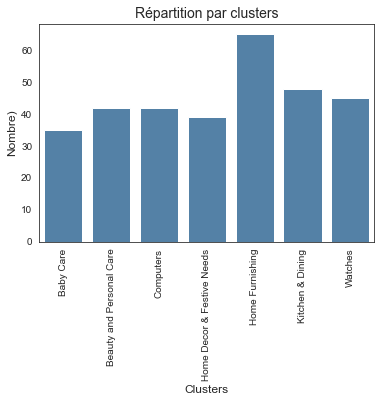

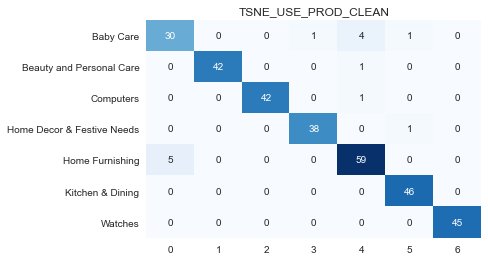

'Précision: 95.57%'

                            precision    recall  f1-score   support

                 Baby Care       0.86      0.83      0.85        36
  Beauty and Personal Care       1.00      0.98      0.99        43
                 Computers       1.00      0.98      0.99        43
Home Decor & Festive Needs       0.97      0.97      0.97        39
           Home Furnishing       0.91      0.92      0.91        64
          Kitchen & Dining       0.96      1.00      0.98        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.96       316
                 macro avg       0.96      0.95      0.96       316
              weighted avg       0.96      0.96      0.96       316


In [62]:
outils_nlp.classifier_pycaret(data_cat, vector_use_prod_clean, titre)

In [63]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.9278', '0.9557', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
39  TSNE_USE_PROD_CLEAN         0.9278        0.9557

<span style='background:Moccasin'>**5.1.3. product_specifications** - produit spécification nettoyé</span>

In [64]:
# Variable dont on veut extraire les features
data['product_specifications_lemma'] = \
    data['product_specifications_lemma'].fillna('').astype(str)
data_prod_lem = data['product_specifications_lemma']

**Modélisation**

In [65]:
# Chargement du modèle
use_model_prod_lem = hub.load(use_module_url)
print('Module %s Chargé' % use_module_url)

Module https://tfhub.dev/google/universal-sentence-encoder/4 Chargé


In [66]:
vector_use_prod_lem = use_model_prod_lem(data_prod_lem)

In [67]:
titre = 'TSNE_USE_PROD_LEM'

INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 2
INFO:logs:ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=21, verbose=0,
                     warm_start=False)
INFO:logs:compare_models() succesfully completed......................................
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_sam

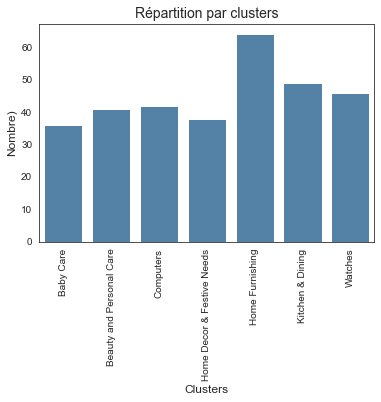

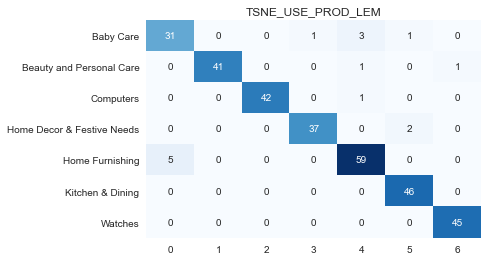

'Précision: 95.25%'

                            precision    recall  f1-score   support

                 Baby Care       0.86      0.86      0.86        36
  Beauty and Personal Care       1.00      0.95      0.98        43
                 Computers       1.00      0.98      0.99        43
Home Decor & Festive Needs       0.97      0.95      0.96        39
           Home Furnishing       0.92      0.92      0.92        64
          Kitchen & Dining       0.94      1.00      0.97        46
                   Watches       0.98      1.00      0.99        45

                  accuracy                           0.95       316
                 macro avg       0.95      0.95      0.95       316
              weighted avg       0.95      0.95      0.95       316


In [68]:
outils_nlp.classifier_pycaret(data_cat, vector_use_prod_lem, titre)

In [69]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.9278', '0.9525', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
40  TSNE_USE_PROD_LEM         0.9278        0.9525

<span style='background:Moccasin'>**5.1.4. product_specifications** - produit spécification stemmatisé</span>

In [70]:
# Variable dont on veut extraire les features
data['product_specifications_stem'] = \
    data['product_specifications_stem'].fillna('').astype(str)
data_prod_stem = data['product_specifications_stem']

**Modélisation**

In [71]:
# Chargement du modèle
use_model = hub.load(use_module_url)
print('Module %s Chargé' % use_module_url)

Module https://tfhub.dev/google/universal-sentence-encoder/4 Chargé


In [72]:
vector_use_prod_stem = use_model(data_prod_stem)

In [73]:
titre = 'TSNE_USE_PROD_STEM'

INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 2
INFO:logs:ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=21, verbose=0,
                     warm_start=False)
INFO:logs:compare_models() succesfully completed......................................
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_sam

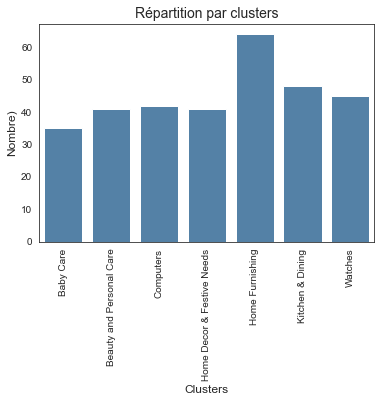

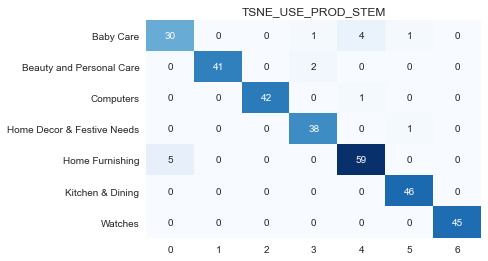

'Précision: 95.25%'

                            precision    recall  f1-score   support

                 Baby Care       0.86      0.83      0.85        36
  Beauty and Personal Care       1.00      0.95      0.98        43
                 Computers       1.00      0.98      0.99        43
Home Decor & Festive Needs       0.93      0.97      0.95        39
           Home Furnishing       0.92      0.92      0.92        64
          Kitchen & Dining       0.96      1.00      0.98        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.95       316
                 macro avg       0.95      0.95      0.95       316
              weighted avg       0.95      0.95      0.95       316


In [74]:
outils_nlp.classifier_pycaret(data_cat, vector_use_prod_stem, titre)

In [75]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.9332', '0.9525', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
41  TSNE_USE_PROD_STEM         0.9332        0.9525

### <span style='background:PowderBlue'>5.2. universal-sentence-encoder-large/5</span>

In [7]:
use_module_url_5 = \
    'https://tfhub.dev/google/universal-sentence-encoder-large/5'

<span style='background:Moccasin'>**5.2.1. product_specifications** - produit spécification original (non nettoyé)</span>

In [8]:
# Variable dont on veut extraire les features
data['product_specifications'] = \
    data['product_specifications'].fillna('').astype(str)
data_prod_orig = data['product_specifications']

**Modélisation**

In [9]:
# Chargement du modèle
use_model5_prod_orig = hub.load(use_module_url_5)
print('Module %s Chargé' % use_module_url_5)

INFO:absl:Using C:\Users\PCMAIS~1\AppData\Local\Temp\tfhub_modules to cache modules.


Module https://tfhub.dev/google/universal-sentence-encoder-large/5 Chargé


In [79]:
vector_use5_prod_orig = use_model5_prod_orig(data_prod_orig)

In [80]:
titre = 'TSNE_USE5_PROD_ORIG'

INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 2
INFO:logs:ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=21, verbose=0,
                     warm_start=False)
INFO:logs:compare_models() succesfully completed......................................
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_sam

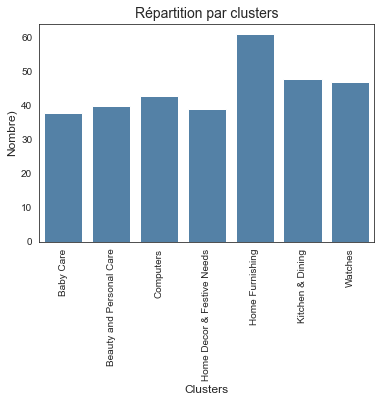

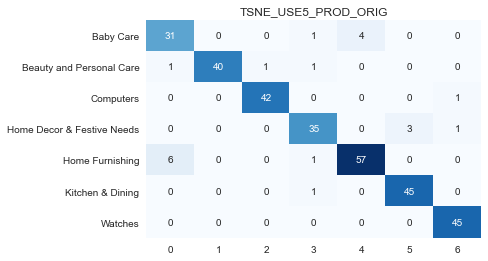

'Précision: 93.35%'

                            precision    recall  f1-score   support

                 Baby Care       0.82      0.86      0.84        36
  Beauty and Personal Care       1.00      0.93      0.96        43
                 Computers       0.98      0.98      0.98        43
Home Decor & Festive Needs       0.90      0.90      0.90        39
           Home Furnishing       0.93      0.89      0.91        64
          Kitchen & Dining       0.94      0.98      0.96        46
                   Watches       0.96      1.00      0.98        45

                  accuracy                           0.93       316
                 macro avg       0.93      0.93      0.93       316
              weighted avg       0.93      0.93      0.93       316


In [81]:
outils_nlp.classifier_pycaret(data_cat, vector_use5_prod_orig, titre)

In [82]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.9319', '0.9335', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
42  TSNE_USE5_PROD_ORIG         0.9319        0.9335

<span style='background:Moccasin'>**5.2.2. product_specifications** - produit spécification nettoyé</span>

In [83]:
# Variable dont on veut extraire les features
data['product_specifications_clean'] = \
    data['product_specifications_clean'].fillna('').astype(str)
data_prod_clean = data['product_specifications_clean']

**Modélisation**

In [84]:
# Chargement du modèle
use_model5_prod_clean = hub.load(use_module_url_5)
print('Module %s Chargé' % use_module_url_5)

Module https://tfhub.dev/google/universal-sentence-encoder-large/5 Chargé


In [85]:
vector_use5_prod_clean = use_model5_prod_clean(data_prod_clean)

In [86]:
titre = 'TSNE_USE5_PROD_CLEAN'

INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 2
INFO:logs:ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=21, verbose=0,
                     warm_start=False)
INFO:logs:compare_models() succesfully completed......................................
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_sam

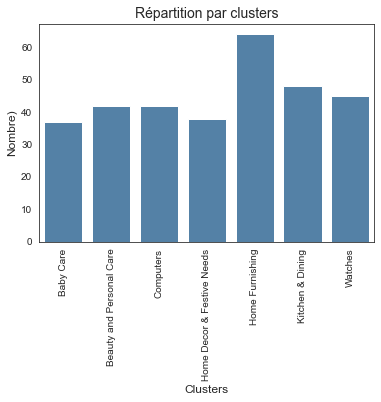

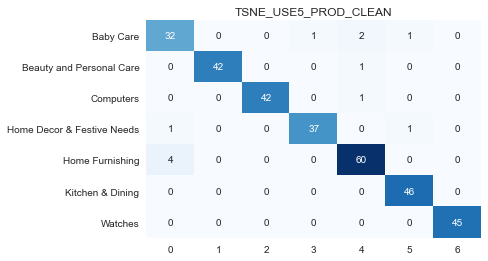

'Précision: 96.2%'

                            precision    recall  f1-score   support

                 Baby Care       0.86      0.89      0.88        36
  Beauty and Personal Care       1.00      0.98      0.99        43
                 Computers       1.00      0.98      0.99        43
Home Decor & Festive Needs       0.97      0.95      0.96        39
           Home Furnishing       0.94      0.94      0.94        64
          Kitchen & Dining       0.96      1.00      0.98        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.96       316
                 macro avg       0.96      0.96      0.96       316
              weighted avg       0.96      0.96      0.96       316


In [87]:
outils_nlp.classifier_pycaret(data_cat, vector_use5_prod_clean, titre)

In [88]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.9441', '0.9620', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
43  TSNE_USE5_PROD_CLEAN         0.9441        0.9620

<span style='background:Moccasin'>**5.2.3. product_specifications** - produit spécification lemmatisé</span>

In [13]:
# Variable dont on veut extraire les features
data['product_specifications_lemma'] = \
    data['product_specifications_lemma'].fillna('').astype(str)
data_prod_lem = data['product_specifications_lemma']

**Modélisation**

In [14]:
# Chargement du modèle
use_model_prod_lem = hub.load(use_module_url_5)
print('Module %s Chargé' % use_module_url_5)

Module https://tfhub.dev/google/universal-sentence-encoder-large/5 Chargé


In [15]:
vector_use5_prod_lem = use_model_prod_lem(data_prod_lem)

In [16]:
# Sauvegarde du dataframe des vectors BOVW DenseNet201
import pickle
with open('sauvegarde/vector_use5_prod_lem.pickle', 'wb') as f:
    pickle.dump(vector_use5_prod_lem, f, pickle.HIGHEST_PROTOCOL)

In [92]:
titre = 'TSNE_USE5_PROD_LEM'

INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 2
INFO:logs:<catboost.core.CatBoostClassifier object at 0x000001AB0D48ED00>
INFO:logs:compare_models() succesfully completed......................................
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=<catboost.core.CatBoostClassifier object at 0x000001AB0D48ED00>, probability_threshold=None, encoded_labels=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


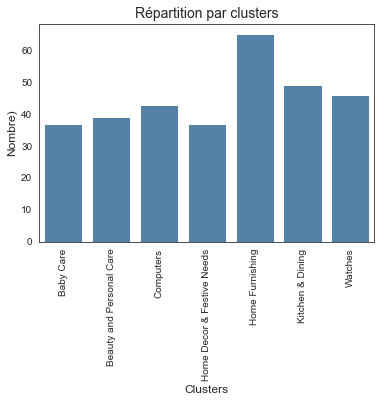

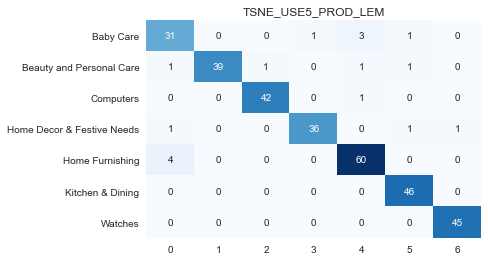

'Précision: 94.62%'

                            precision    recall  f1-score   support

                 Baby Care       0.84      0.86      0.85        36
  Beauty and Personal Care       1.00      0.91      0.95        43
                 Computers       0.98      0.98      0.98        43
Home Decor & Festive Needs       0.97      0.92      0.95        39
           Home Furnishing       0.92      0.94      0.93        64
          Kitchen & Dining       0.94      1.00      0.97        46
                   Watches       0.98      1.00      0.99        45

                  accuracy                           0.95       316
                 macro avg       0.95      0.94      0.94       316
              weighted avg       0.95      0.95      0.95       316


In [93]:
outils_nlp.classifier_pycaret(data_cat, vector_use5_prod_lem, titre)

In [94]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.9387', '0.9462', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
44  TSNE_USE5_PROD_LEM         0.9387        0.9462

<span style='background:Moccasin'>**5.2.4. product_specifications** - produit spécification stemmatisé</span>

In [45]:
# Variable dont on veut extraire les features
data['product_specifications_stem'] = \
    data['product_specifications_stem'].fillna('').astype(str)
data_prod_stem = data['product_specifications_stem']

**Modélisation**

In [48]:
# Chargement du modèle
use_model5_prod_stem = hub.load(use_module_url_5)
print('Module %s Chargé' % use_module_url_5)

INFO:absl:Using C:\Users\PCMAIS~1\AppData\Local\Temp\tfhub_modules to cache modules.


In [49]:
vector_use5_prod_stem = use_model5_prod_stem(data_prod_stem)

In [51]:
titre = 'TSNE_USE5_PROD_STEM'

INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 2
INFO:logs:ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=21, verbose=0,
                     warm_start=False)
INFO:logs:compare_models() succesfully completed......................................
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_sam

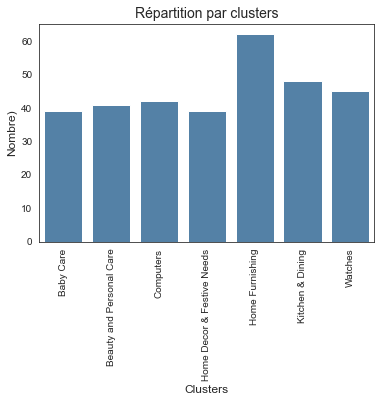

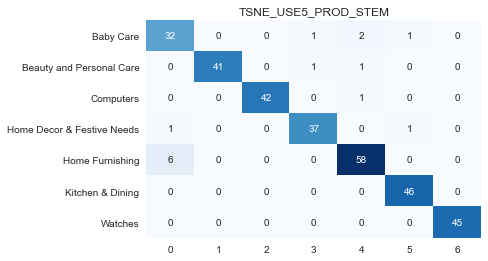

'Précision: 95.25%'

                            precision    recall  f1-score   support

                 Baby Care       0.82      0.89      0.85        36
  Beauty and Personal Care       1.00      0.95      0.98        43
                 Computers       1.00      0.98      0.99        43
Home Decor & Festive Needs       0.95      0.95      0.95        39
           Home Furnishing       0.94      0.91      0.92        64
          Kitchen & Dining       0.96      1.00      0.98        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.95       316
                 macro avg       0.95      0.95      0.95       316
              weighted avg       0.95      0.95      0.95       316


In [52]:
outils_nlp.classifier_pycaret(data_cat, vector_use5_prod_stem, titre)

In [57]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.9387', '0.9525', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
45  TSNE_USE5_PROD_STEM         0.9387        0.9525

<span style='background:Moccasin'>**5.2.5. product_name** - nom du produit original (non nettoyé)</span>

In [58]:
# Variable dont on veut extraire les features
data['product_name'] = \
    data['product_name'].fillna('').astype(str)
data_prodname_orig = data['product_name']

**Modélisation**

In [59]:
# Chargement du modèle
use_model5_prodname_orig = hub.load(use_module_url_5)
print('Module %s Chargé' % use_module_url_5)

In [60]:
vector_use5_prodname_orig = use_model5_prodname_orig(data_prodname_orig)

In [61]:
titre = 'TSNE_USE5_PROD_NAME_ORIG'

INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 2
INFO:logs:ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=21, verbose=0,
                     warm_start=False)
INFO:logs:compare_models() succesfully completed......................................
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_sam

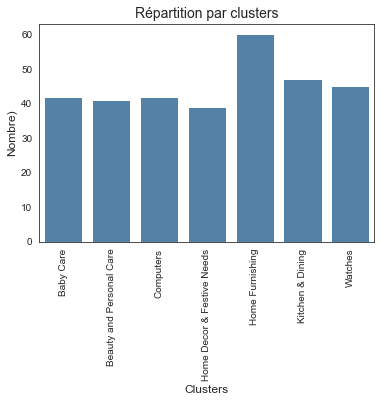

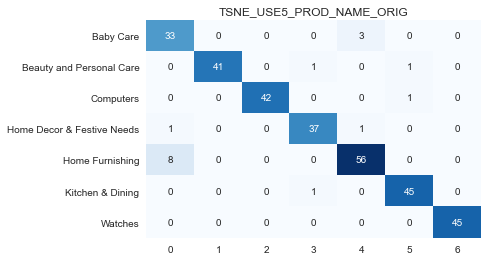

'Précision: 94.62%'

                            precision    recall  f1-score   support

                 Baby Care       0.79      0.92      0.85        36
  Beauty and Personal Care       1.00      0.95      0.98        43
                 Computers       1.00      0.98      0.99        43
Home Decor & Festive Needs       0.95      0.95      0.95        39
           Home Furnishing       0.93      0.88      0.90        64
          Kitchen & Dining       0.96      0.98      0.97        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.95       316
                 macro avg       0.95      0.95      0.95       316
              weighted avg       0.95      0.95      0.95       316


In [62]:
outils_nlp.classifier_pycaret(data_cat, vector_use5_prodname_orig, titre)

In [63]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.9100', '0.9462', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
46  TSNE_USE5_PROD_NAME_ORIG         0.9100        0.9462

<span style='background:Moccasin'>**5.2.6. product_name** - nom du produit nettoyé</span>

In [64]:
# Variable dont on veut extraire les features
data['product_name_clean'] = \
    data['product_name_clean'].fillna('').astype(str)
data_prodname_clean = data['product_name_clean']

**Modélisation**

In [65]:
# Chargement du modèle
use_model5_prodname_clean = hub.load(use_module_url_5)
print('Module %s Chargé' % use_module_url_5)

In [66]:
vector_use5_prodname_clean = use_model5_prodname_clean(data_prodname_clean)

In [67]:
titre = 'TSNE_USE5_PROD_NAME_CLEAN'

INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 2
INFO:logs:ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=21, verbose=0,
                     warm_start=False)
INFO:logs:compare_models() succesfully completed......................................
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_sam

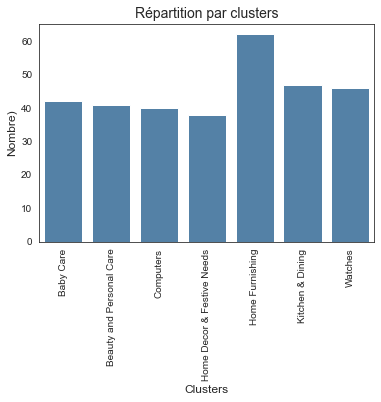

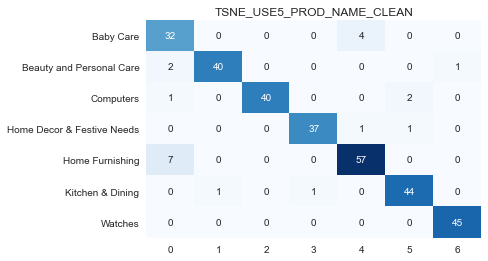

'Précision: 93.35%'

                            precision    recall  f1-score   support

                 Baby Care       0.76      0.89      0.82        36
  Beauty and Personal Care       0.98      0.93      0.95        43
                 Computers       1.00      0.93      0.96        43
Home Decor & Festive Needs       0.97      0.95      0.96        39
           Home Furnishing       0.92      0.89      0.90        64
          Kitchen & Dining       0.94      0.96      0.95        46
                   Watches       0.98      1.00      0.99        45

                  accuracy                           0.93       316
                 macro avg       0.93      0.94      0.93       316
              weighted avg       0.94      0.93      0.93       316


In [68]:
outils_nlp.classifier_pycaret(data_cat, vector_use5_prodname_clean, titre)

In [69]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.9182', '0.9335', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
47  TSNE_USE5_PROD_NAME_CLEAN         0.9182        0.9335

<span style='background:Moccasin'>**5.2.7. product_name** - nom du produit  lemmatisé</span>

In [70]:
# Variable dont on veut extraire les features
data['product_name_lemma'] = \
    data['product_name_lemma'].fillna('').astype(str)
data_prodname_lem = data['product_name_lemma']

**Modélisation**

In [71]:
# Chargement du modèle
use_model5_prodname_lem = hub.load(use_module_url_5)
print('Module %s Chargé' % use_module_url_5)

In [72]:
vector_use5_prodname_lem = use_model5_prodname_lem(data_prodname_lem)

In [73]:
titre = 'TSNE_USE5_PROD_NAME_LEM'

INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 2
INFO:logs:RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=21, verbose=0,
                       warm_start=False)
INFO:logs:compare_models() succesfully completed......................................
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf

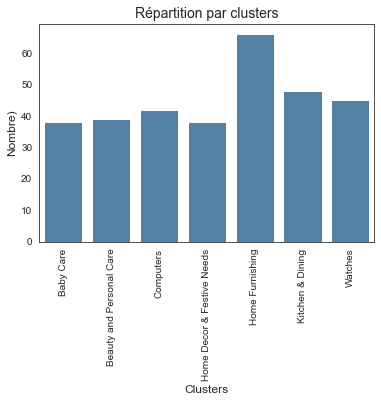

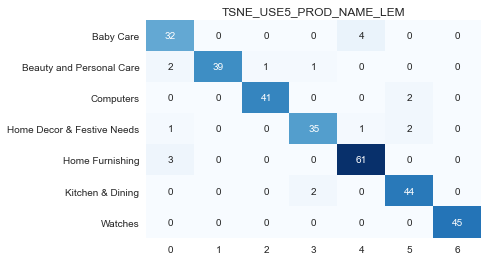

'Précision: 93.99%'

                            precision    recall  f1-score   support

                 Baby Care       0.84      0.89      0.86        36
  Beauty and Personal Care       1.00      0.91      0.95        43
                 Computers       0.98      0.95      0.96        43
Home Decor & Festive Needs       0.92      0.90      0.91        39
           Home Furnishing       0.92      0.95      0.94        64
          Kitchen & Dining       0.92      0.96      0.94        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.94       316
                 macro avg       0.94      0.94      0.94       316
              weighted avg       0.94      0.94      0.94       316


In [74]:
outils_nlp.classifier_pycaret(data_cat, vector_use5_prodname_lem, titre)

In [75]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.9264', '0.9399', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
48  TSNE_USE5_PROD_NAME_LEM         0.9264        0.9399

<span style='background:Moccasin'>**5.2.8. product_name** - nom du produit stemmatisé</span>

In [76]:
# Variable dont on veut extraire les features
data['product_name_stem'] = \
    data['product_name_stem'].fillna('').astype(str)
data_prodname_stem = data['product_name_stem']

**Modélisation**

In [77]:
# Chargement du modèle
use_model5_prodname_stem = hub.load(use_module_url_5)
print('Module %s Chargé' % use_module_url_5)

In [78]:
vector_use5_prodname_stem = use_model5_prodname_stem(data_prodname_stem)

In [79]:
titre = 'TSNE_USE5_PROD_NAME_STEM'

INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 2
INFO:logs:ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=21, verbose=0,
                     warm_start=False)
INFO:logs:compare_models() succesfully completed......................................
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_sam

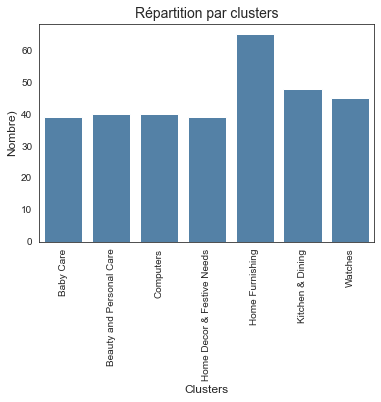

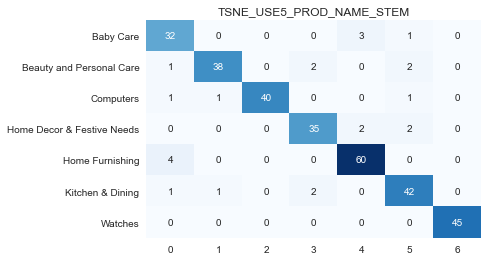

'Précision: 92.41%'

                            precision    recall  f1-score   support

                 Baby Care       0.82      0.89      0.85        36
  Beauty and Personal Care       0.95      0.88      0.92        43
                 Computers       1.00      0.93      0.96        43
Home Decor & Festive Needs       0.90      0.90      0.90        39
           Home Furnishing       0.92      0.94      0.93        64
          Kitchen & Dining       0.88      0.91      0.89        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.92       316
                 macro avg       0.92      0.92      0.92       316
              weighted avg       0.93      0.92      0.92       316


In [80]:
outils_nlp.classifier_pycaret(data_cat, vector_use5_prodname_stem, titre)

In [81]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.8937', '0.9241', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
49  TSNE_USE5_PROD_NAME_STEM         0.8937        0.9241

<span style='background:Moccasin'>**5.2.9. Mixte produits** - nom du produit + produit spécification originaux (non nettoyés)</span>

In [82]:
# Variable dont on veut extraire les features
data['all_prod'] = data['product_name'] + data['product_specifications']
data['all_prod'] = data['all_prod'].fillna('').astype(str)
data_allprod_orig = data['all_prod']

**Modélisation**

In [83]:
# Chargement du modèle
use_model5_allprod_orig = hub.load(use_module_url_5)
print('Module %s Chargé' % use_module_url_5)

In [84]:
vector_use5_allprod_orig = use_model5_allprod_orig(data_allprod_orig)

In [85]:
titre = 'TSNE_USE5_ALL_PROD_ORIG'

INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 2
INFO:logs:<catboost.core.CatBoostClassifier object at 0x00000235EF6C3D30>
INFO:logs:compare_models() succesfully completed......................................
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=<catboost.core.CatBoostClassifier object at 0x00000235EF6C3D30>, probability_threshold=None, encoded_labels=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


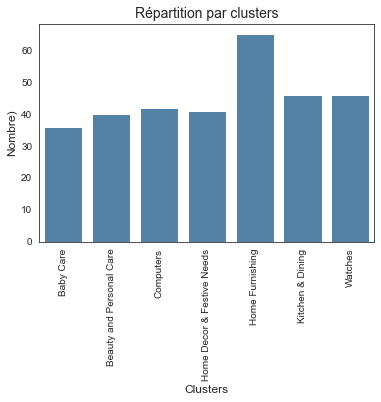

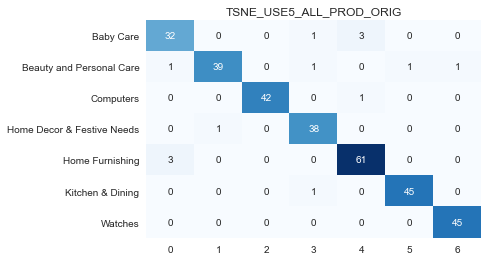

'Précision: 95.57%'

                            precision    recall  f1-score   support

                 Baby Care       0.89      0.89      0.89        36
  Beauty and Personal Care       0.97      0.91      0.94        43
                 Computers       1.00      0.98      0.99        43
Home Decor & Festive Needs       0.93      0.97      0.95        39
           Home Furnishing       0.94      0.95      0.95        64
          Kitchen & Dining       0.98      0.98      0.98        46
                   Watches       0.98      1.00      0.99        45

                  accuracy                           0.96       316
                 macro avg       0.96      0.95      0.95       316
              weighted avg       0.96      0.96      0.96       316


In [86]:
outils_nlp.classifier_pycaret(data_cat, vector_use5_allprod_orig, titre)

In [87]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.9359', '0.9557', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
50  TSNE_USE5_ALL_PROD_ORIG         0.9359        0.9557

<span style='background:Moccasin'>**5.2.10. Mixtes produits** - nom du produit + produit spécification nettoyés</span>

In [88]:
# Variable dont on veut extraire les features
data['all_prod_clean'] = data['product_name_clean']
+ data['product_specifications_clean']
data['all_prod_clean'] = data['all_prod_clean'].fillna('').astype(str)
data_allprod_clean = data['all_prod_clean']

**Modélisation**

In [89]:
# Chargement du modèle
use_model5_allprod_clean = hub.load(use_module_url_5)
print('Module %s Chargé' % use_module_url_5)

In [90]:
vector_use5_allprod_clean = use_model5_allprod_clean(data_allprod_clean)

In [91]:
titre = 'TSNE_USE5_ALL_PROD_CLEAN'

INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 2
INFO:logs:ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=21, verbose=0,
                     warm_start=False)
INFO:logs:compare_models() succesfully completed......................................
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_sam

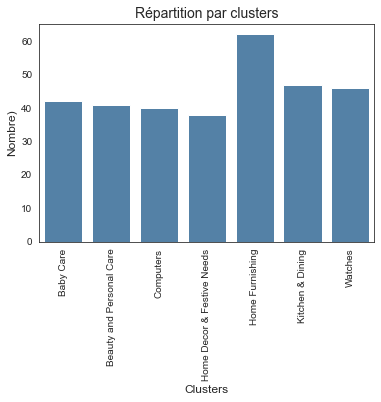

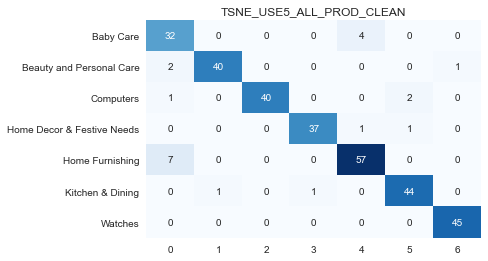

'Précision: 93.35%'

                            precision    recall  f1-score   support

                 Baby Care       0.76      0.89      0.82        36
  Beauty and Personal Care       0.98      0.93      0.95        43
                 Computers       1.00      0.93      0.96        43
Home Decor & Festive Needs       0.97      0.95      0.96        39
           Home Furnishing       0.92      0.89      0.90        64
          Kitchen & Dining       0.94      0.96      0.95        46
                   Watches       0.98      1.00      0.99        45

                  accuracy                           0.93       316
                 macro avg       0.93      0.94      0.93       316
              weighted avg       0.94      0.93      0.93       316


In [92]:
outils_nlp.classifier_pycaret(data_cat, vector_use5_allprod_clean, titre)

In [93]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.9182', '0.9335', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
51  TSNE_USE5_ALL_PROD_CLEAN         0.9182        0.9335

<span style='background:Moccasin'>**5.2.11. Mixte produits** - nom du produit + produit spécification lemmatisés</span>

In [94]:
# Variable dont on veut extraire les features
data['all_prod_lem'] = data['product_name_lemma']
+ data['product_specifications_lemma']
data['all_prod_lem'] = data['all_prod_lem'].fillna('').astype(str)
data_allprod_lem = data['all_prod_lem']

**Modélisation**

In [95]:
# Chargement du modèle
use_model_allprod_lem = hub.load(use_module_url_5)
print('Module %s Chargé' % use_module_url_5)

In [96]:
vector_use5_allprod_lem = use_model_allprod_lem(data_allprod_lem)

In [97]:
titre = 'TSNE_USE5_ALL_PROD_LEM'

INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 2
INFO:logs:RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=21, verbose=0,
                       warm_start=False)
INFO:logs:compare_models() succesfully completed......................................
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf

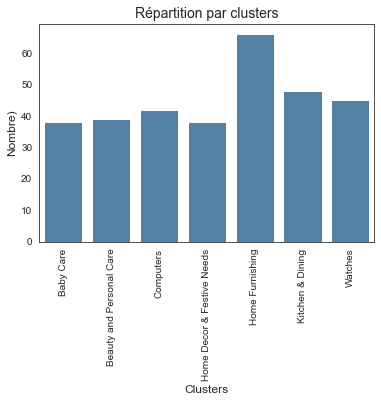

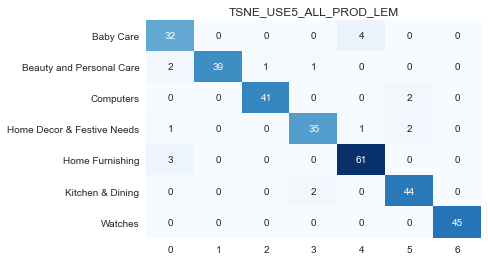

'Précision: 93.99%'

                            precision    recall  f1-score   support

                 Baby Care       0.84      0.89      0.86        36
  Beauty and Personal Care       1.00      0.91      0.95        43
                 Computers       0.98      0.95      0.96        43
Home Decor & Festive Needs       0.92      0.90      0.91        39
           Home Furnishing       0.92      0.95      0.94        64
          Kitchen & Dining       0.92      0.96      0.94        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.94       316
                 macro avg       0.94      0.94      0.94       316
              weighted avg       0.94      0.94      0.94       316


In [98]:
outils_nlp.classifier_pycaret(data_cat, vector_use5_allprod_lem, titre)

In [99]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.9264', '0.9399', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
52  TSNE_USE5_ALL_PROD_LEM         0.9264        0.9399

<span style='background:Moccasin'>**5.2.12. Mixte produits** - nom du produit + produit spécification stemmatisés</span>

In [100]:
# Variable dont on veut extraire les features
data['all_prod_stem'] = data['product_name_stem']
+ data['product_specifications_stem']
data['all_prod_stem'] = \
    data['all_prod_stem'].fillna('').astype(str)
data_allprod_stem = data['all_prod_stem']

**Modélisation**

In [101]:
# Chargement du modèle
use_model5_allprod_stem = hub.load(use_module_url_5)
print('Module %s Chargé' % use_module_url_5)

In [102]:
vector_use5_allprod_stem = use_model5_allprod_stem(data_allprod_stem)

In [103]:
titre = 'TSNE_USE5_ALL_PROD_STEM'

INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 2
INFO:logs:ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=21, verbose=0,
                     warm_start=False)
INFO:logs:compare_models() succesfully completed......................................
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_sam

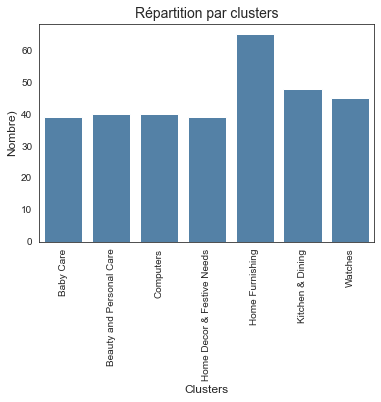

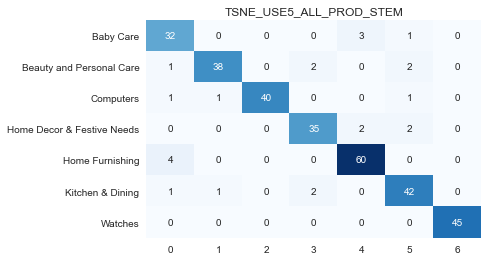

'Précision: 92.41%'

                            precision    recall  f1-score   support

                 Baby Care       0.82      0.89      0.85        36
  Beauty and Personal Care       0.95      0.88      0.92        43
                 Computers       1.00      0.93      0.96        43
Home Decor & Festive Needs       0.90      0.90      0.90        39
           Home Furnishing       0.92      0.94      0.93        64
          Kitchen & Dining       0.88      0.91      0.89        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.92       316
                 macro avg       0.92      0.92      0.92       316
              weighted avg       0.93      0.92      0.92       316


In [104]:
outils_nlp.classifier_pycaret(data_cat, vector_use5_allprod_stem, titre)

In [105]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.8937', '0.9241', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
53  TSNE_USE5_ALL_PROD_STEM         0.8937        0.9241

<span style='background:Moccasin'>**5.2.13. Mixte toutes les variables** - nom du produit + produit spécification + marque + description lemmatisés</span>

In [106]:
# Variable dont on veut extraire les features
data['all_lem'] = data['product_name_lemma'] + data['brand_lemma']
+ data['product_specifications_lemma'] + data['description_clean_lemma']
data['all_lem'] = data['all_lem'].fillna('').astype(str)
data_all_lem = data['all_lem']

**Modélisation**

In [107]:
# Chargement du modèle
use_model_all_lem = hub.load(use_module_url_5)
print('Module %s Chargé' % use_module_url_5)

In [108]:
vector_use5_all_lem = use_model_all_lem(data_all_lem)

In [109]:
titre = 'TSNE_USE5_ALL_LEM'

INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 2
INFO:logs:RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=21, verbose=0,
                       warm_start=False)
INFO:logs:compare_models() succesfully completed......................................
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf

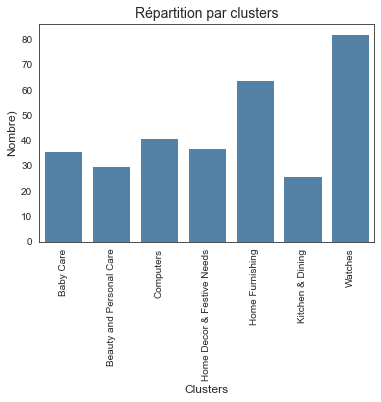

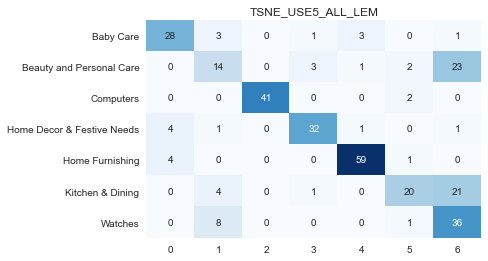

'Précision: 72.78%'

                            precision    recall  f1-score   support

                 Baby Care       0.78      0.78      0.78        36
  Beauty and Personal Care       0.47      0.33      0.38        43
                 Computers       1.00      0.95      0.98        43
Home Decor & Festive Needs       0.86      0.82      0.84        39
           Home Furnishing       0.92      0.92      0.92        64
          Kitchen & Dining       0.77      0.43      0.56        46
                   Watches       0.44      0.80      0.57        45

                  accuracy                           0.73       316
                 macro avg       0.75      0.72      0.72       316
              weighted avg       0.76      0.73      0.73       316


In [110]:
outils_nlp.classifier_pycaret(data_cat, vector_use5_all_lem, titre)

In [111]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.6988', '0.7278', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
54  TSNE_USE5_ALL_LEM         0.6988        0.7278

<span style='background:Moccasin'>**5.2.14. Mixte toutes les variables** - nom du produit + produit spécification originaux + marque + description (non nettoyés)</span>

In [112]:
# Variable dont on veut extraire les features
data['all_orig'] = data['product_name'] + data['brand']
+ data['product_specifications'] + data['description']
data['all_orig'] = data['all_orig'].fillna('').astype(str)
data_all_orig = data['all_orig']

**Modélisation**

In [113]:
# Chargement du modèle
use_model5_all_orig = hub.load(use_module_url_5)
print('Module %s Chargé' % use_module_url_5)

In [114]:
vector_use5_all_orig = use_model5_all_orig(data_all_orig)

In [115]:
titre = 'TSNE_USE5_ALL_ORIG'

INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 2
INFO:logs:ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=21, verbose=0,
                     warm_start=False)
INFO:logs:compare_models() succesfully completed......................................
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_sam

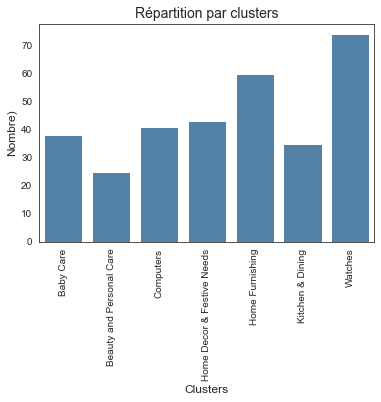

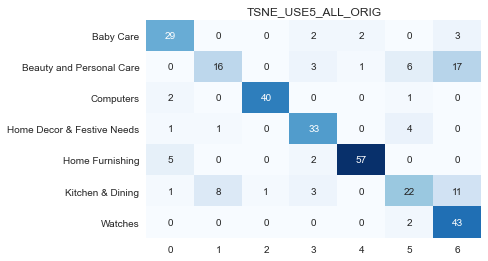

'Précision: 75.95%'

                            precision    recall  f1-score   support

                 Baby Care       0.76      0.81      0.78        36
  Beauty and Personal Care       0.64      0.37      0.47        43
                 Computers       0.98      0.93      0.95        43
Home Decor & Festive Needs       0.77      0.85      0.80        39
           Home Furnishing       0.95      0.89      0.92        64
          Kitchen & Dining       0.63      0.48      0.54        46
                   Watches       0.58      0.96      0.72        45

                  accuracy                           0.76       316
                 macro avg       0.76      0.75      0.74       316
              weighted avg       0.77      0.76      0.75       316


In [116]:
outils_nlp.classifier_pycaret(data_cat, vector_use5_all_orig, titre)

In [117]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.6907', '0.7595', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
55  TSNE_USE5_ALL_ORIG         0.6907        0.7595

<span style='background:Moccasin'>**5.2.15. Mixte toutes les variables** - nom du produit + produit spécification + marque + description stemmatisés</span>

In [118]:
# Variable dont on veut extraire les features
data['all_stem'] = data['product_name_stem'] + data['brand_stem']
+ data['product_specifications_stem'] + data['description_clean_stem']
data['all_stem'] = data['all_stem'].fillna('').astype(str)
data_all_stem = data['all_stem']

**Modélisation**

In [119]:
# Chargement du modèle
use_model5_all_stem = hub.load(use_module_url_5)
print('Module %s Chargé' % use_module_url_5)

In [120]:
vector_use5_all_stem = use_model5_all_stem(data_all_stem)

In [121]:
titre = 'TSNE_USE5_ALL_STEM'

INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 2
INFO:logs:RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=21, verbose=0,
                       warm_start=False)
INFO:logs:compare_models() succesfully completed......................................
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf

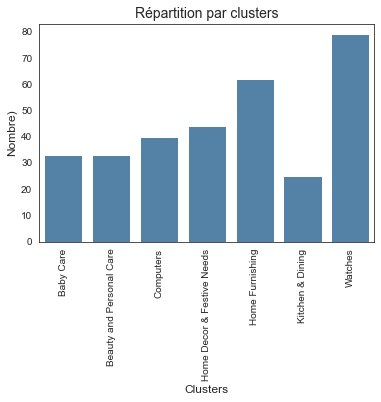

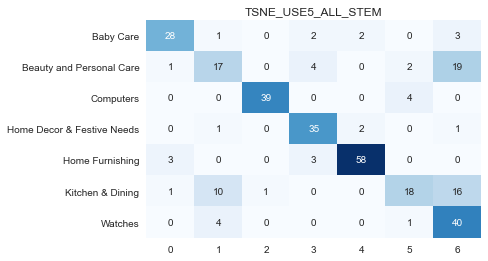

'Précision: 74.37%'

                            precision    recall  f1-score   support

                 Baby Care       0.85      0.78      0.81        36
  Beauty and Personal Care       0.52      0.40      0.45        43
                 Computers       0.97      0.91      0.94        43
Home Decor & Festive Needs       0.80      0.90      0.84        39
           Home Furnishing       0.94      0.91      0.92        64
          Kitchen & Dining       0.72      0.39      0.51        46
                   Watches       0.51      0.89      0.65        45

                  accuracy                           0.74       316
                 macro avg       0.76      0.74      0.73       316
              weighted avg       0.76      0.74      0.74       316


In [122]:
outils_nlp.classifier_pycaret(data_cat, vector_use5_all_stem, titre)

In [123]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.6757', '0.7437', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
56  TSNE_USE5_ALL_STEM         0.6757        0.7437

## <span style='background:Thistle'>6. Sentence-transformers - ELECTRA</span>

### <span style='background:PowderBlue'>6.1. ELECTRA google/electra-large-discriminator</span>

In [124]:
# Instanciation du modèle
sentence_electra = SentenceTransformer('google/electra-large-discriminator')

Exception when trying to download https://sbert.net/models/google/electra-large-discriminator.zip. Response 404
Some weights of the model checkpoint at google/electra-large-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<span style='background:Moccasin'>**6.1.1. description** - originale (non nettoyée)</span>

In [126]:
# Variable dont on veut extraire les features
data['description'] = \
    data['description'].fillna('').astype(str)
data_desc_orig = data['description']

**Modélisation**

In [127]:
# Encodage
vector_elec_desc_orig = \
    sentence_electra.encode(data_desc_orig, show_progress_bar=False)

In [128]:
titre = 'TSNE_ELECTRA_DESC_ORIG'

INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 2
INFO:logs:ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=21, verbose=0,
                     warm_start=False)
INFO:logs:compare_models() succesfully completed......................................
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_sam

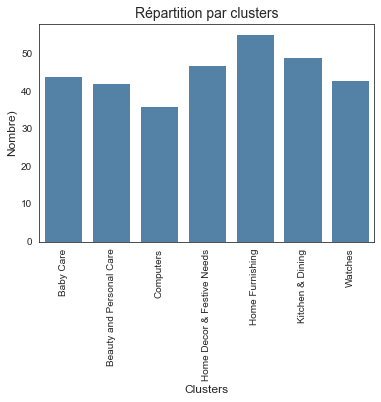

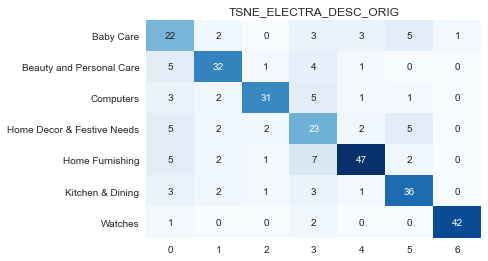

'Précision: 73.73%'

                            precision    recall  f1-score   support

                 Baby Care       0.50      0.61      0.55        36
  Beauty and Personal Care       0.76      0.74      0.75        43
                 Computers       0.86      0.72      0.78        43
Home Decor & Festive Needs       0.49      0.59      0.53        39
           Home Furnishing       0.85      0.73      0.79        64
          Kitchen & Dining       0.73      0.78      0.76        46
                   Watches       0.98      0.93      0.95        45

                  accuracy                           0.74       316
                 macro avg       0.74      0.73      0.73       316
              weighted avg       0.76      0.74      0.74       316


In [129]:
outils_nlp.classifier_pycaret(data_cat, vector_elec_desc_orig, titre)

In [130]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.6718', '0.7373', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
57  TSNE_ELECTRA_DESC_ORIG         0.6718        0.7373

<span style='background:Moccasin'>**6.1.2. product_specifications** - original (non nettoyé)</span>

In [131]:
# Variable dont on veut extraire les features
data['product_specifications'] = \
    data['product_specifications'].fillna('').astype(str)
data_prod_orig = data['product_specifications']

**Modélisation**

In [132]:
# Encodage
vector_elec_prod_orig = \
    sentence_electra.encode(data_prod_orig, show_progress_bar=False)

In [133]:
titre = 'TSNE_ELECTRA_PROD_ORIG'

INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 2
INFO:logs:ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=21, verbose=0,
                     warm_start=False)
INFO:logs:compare_models() succesfully completed......................................
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_sam

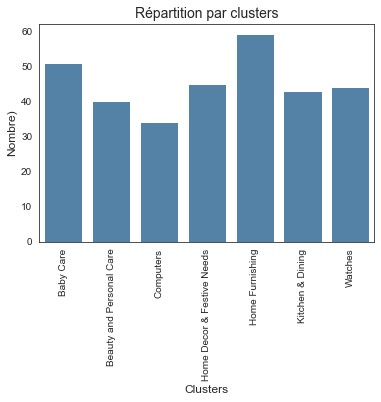

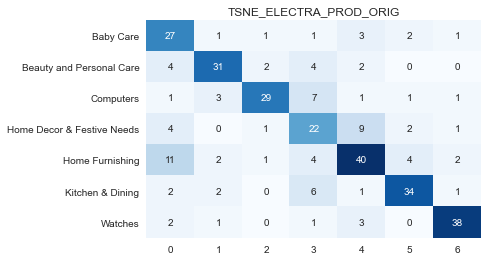

'Précision: 69.94%'

                            precision    recall  f1-score   support

                 Baby Care       0.53      0.75      0.62        36
  Beauty and Personal Care       0.78      0.72      0.75        43
                 Computers       0.85      0.67      0.75        43
Home Decor & Festive Needs       0.49      0.56      0.52        39
           Home Furnishing       0.68      0.62      0.65        64
          Kitchen & Dining       0.79      0.74      0.76        46
                   Watches       0.86      0.84      0.85        45

                  accuracy                           0.70       316
                 macro avg       0.71      0.70      0.70       316
              weighted avg       0.72      0.70      0.70       316


In [134]:
outils_nlp.classifier_pycaret(data_cat, vector_elec_prod_orig, titre)

In [135]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.7656', '0.6994', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
58  TSNE_ELECTRA_PROD_ORIG         0.7656        0.6994

<span style='background:Moccasin'>**6.1.3. product_specifications** - nettoyé (non racinisé et non lemmatisé)</span>

In [136]:
# Variable dont on veut extraire les features
data['product_specifications_clean'] = \
    data['product_specifications_clean'].fillna('').astype(str)
data_prod_clean = data['product_specifications_clean']

**Modélisation**

In [137]:
# Encodage
vector_elec_prod_clean = \
    sentence_electra.encode(data_prod_clean, show_progress_bar=False)

In [138]:
titre = 'TSNE_ELEC_PROD_CLEAN'

INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 2
INFO:logs:ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=21, verbose=0,
                     warm_start=False)
INFO:logs:compare_models() succesfully completed......................................
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_sam

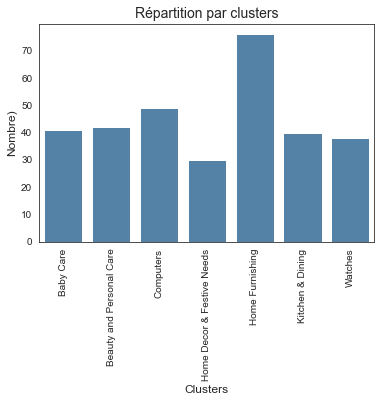

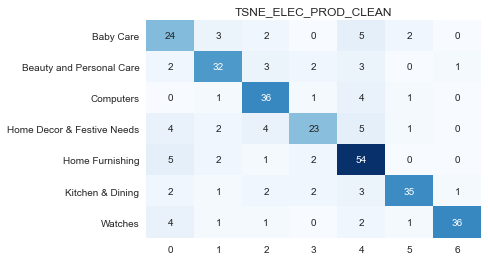

'Précision: 75.95%'

                            precision    recall  f1-score   support

                 Baby Care       0.59      0.67      0.62        36
  Beauty and Personal Care       0.76      0.74      0.75        43
                 Computers       0.73      0.84      0.78        43
Home Decor & Festive Needs       0.77      0.59      0.67        39
           Home Furnishing       0.71      0.84      0.77        64
          Kitchen & Dining       0.88      0.76      0.81        46
                   Watches       0.95      0.80      0.87        45

                  accuracy                           0.76       316
                 macro avg       0.77      0.75      0.75       316
              weighted avg       0.77      0.76      0.76       316


In [139]:
outils_nlp.classifier_pycaret(data_cat, vector_elec_prod_clean, titre)

In [140]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.7139', '0.7595', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
59  TSNE_ELEC_PROD_CLEAN         0.7139        0.7595

<span style='background:Moccasin'>**6.1.4. product_specifications** - lemmatisé</span>

In [141]:
# Variable dont on veut extraire les features
data['product_specifications_lemma'] = \
    data['product_specifications_lemma'].fillna('').astype(str)
data_prod_lem = data['product_specifications_lemma']

**Modélisation**

In [142]:
# Encodage
vector_elec_prod_lem = \
    sentence_electra.encode(data_prod_lem, show_progress_bar=False)

In [143]:
titre = 'TSNE_ELECTRA_PROD_LEM'

INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 2
INFO:logs:ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=21, verbose=0,
                     warm_start=False)
INFO:logs:compare_models() succesfully completed......................................
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_sam

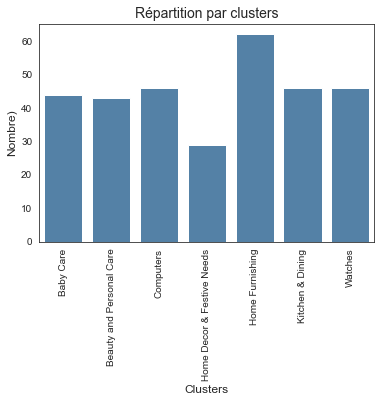

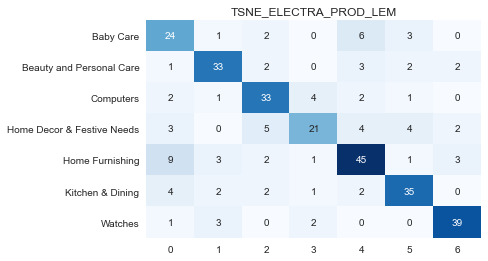

'Précision: 72.78%'

                            precision    recall  f1-score   support

                 Baby Care       0.55      0.67      0.60        36
  Beauty and Personal Care       0.77      0.77      0.77        43
                 Computers       0.72      0.77      0.74        43
Home Decor & Festive Needs       0.72      0.54      0.62        39
           Home Furnishing       0.73      0.70      0.71        64
          Kitchen & Dining       0.76      0.76      0.76        46
                   Watches       0.85      0.87      0.86        45

                  accuracy                           0.73       316
                 macro avg       0.73      0.72      0.72       316
              weighted avg       0.73      0.73      0.73       316


In [144]:
outils_nlp.classifier_pycaret(data_cat, vector_elec_prod_lem, titre)

In [145]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.7139', '0.7278', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
60  TSNE_ELECTRA_PROD_LEM         0.7139        0.7278

<span style='background:Moccasin'>**6.1.5. product_specifications** - stemmatisé</span>

In [146]:
# Variable dont on veut extraire les features
data['product_specifications_stem'] = \
    data['product_specifications_stem'].fillna('').astype(str)
data_prod_stem = data['product_specifications_stem']

**Modélisation**

In [147]:
# Encodage
vector_elec_prod_stem = \
    sentence_electra.encode(data_prod_stem, show_progress_bar=False)

In [148]:
titre = 'TSNE_ELECTRA_PROD_STEM'

INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 2
INFO:logs:ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=21, verbose=0,
                     warm_start=False)
INFO:logs:compare_models() succesfully completed......................................
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_sam

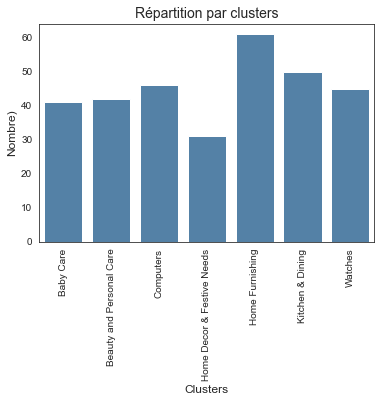

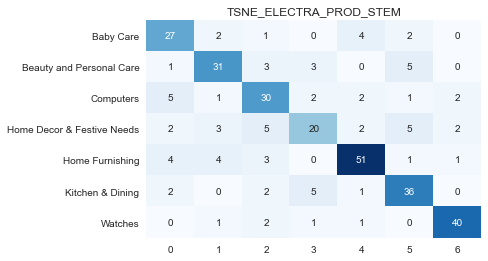

'Précision: 74.37%'

                            precision    recall  f1-score   support

                 Baby Care       0.66      0.75      0.70        36
  Beauty and Personal Care       0.74      0.72      0.73        43
                 Computers       0.65      0.70      0.67        43
Home Decor & Festive Needs       0.65      0.51      0.57        39
           Home Furnishing       0.84      0.80      0.82        64
          Kitchen & Dining       0.72      0.78      0.75        46
                   Watches       0.89      0.89      0.89        45

                  accuracy                           0.74       316
                 macro avg       0.73      0.74      0.73       316
              weighted avg       0.74      0.74      0.74       316


In [149]:
outils_nlp.classifier_pycaret(data_cat, vector_elec_prod_stem, titre)

In [156]:
# Sauvegarde des résultats
df_accuracy_class = \
    outils_nlp.sauvegarder_accuracy_pycaret(df_accuracy_class,
                                            '0.7207', '0.7437', titre)
df_accuracy_class[df_accuracy_class['Type_données'] == titre]

Type_données Accuracy_train Accuracy_test
61  TSNE_ELECTRA_PROD_STEM         0.7207        0.7437

## <span style='background:Thistle'>7. Comparaison des accuracy</span>

### <span style='background:PowderBlue'>7.1. Méthodes NLP Classiques</span>

In [210]:
# Chargement des données de sauvegarde des résultats des métriques KMeans
df_accuracy_class_we = pd.read_csv('data_accuracy_classification_we.csv')
# Supprime varaible Unnamed: 0
df_accuracy_class_we.drop('Unnamed: 0', axis=1, inplace=True)
df_accuracy_class_we.shape

(16, 3)

In [214]:
df_comp_nlp = df_accuracy_class_we.copy()
df_comp_nlp['Accuracy_train'] = \
    df_comp_nlp['Accuracy_train'].astype(float)
df_comp_nlp['Accuracy_test'] = \
    df_comp_nlp['Accuracy_test'].astype(float)

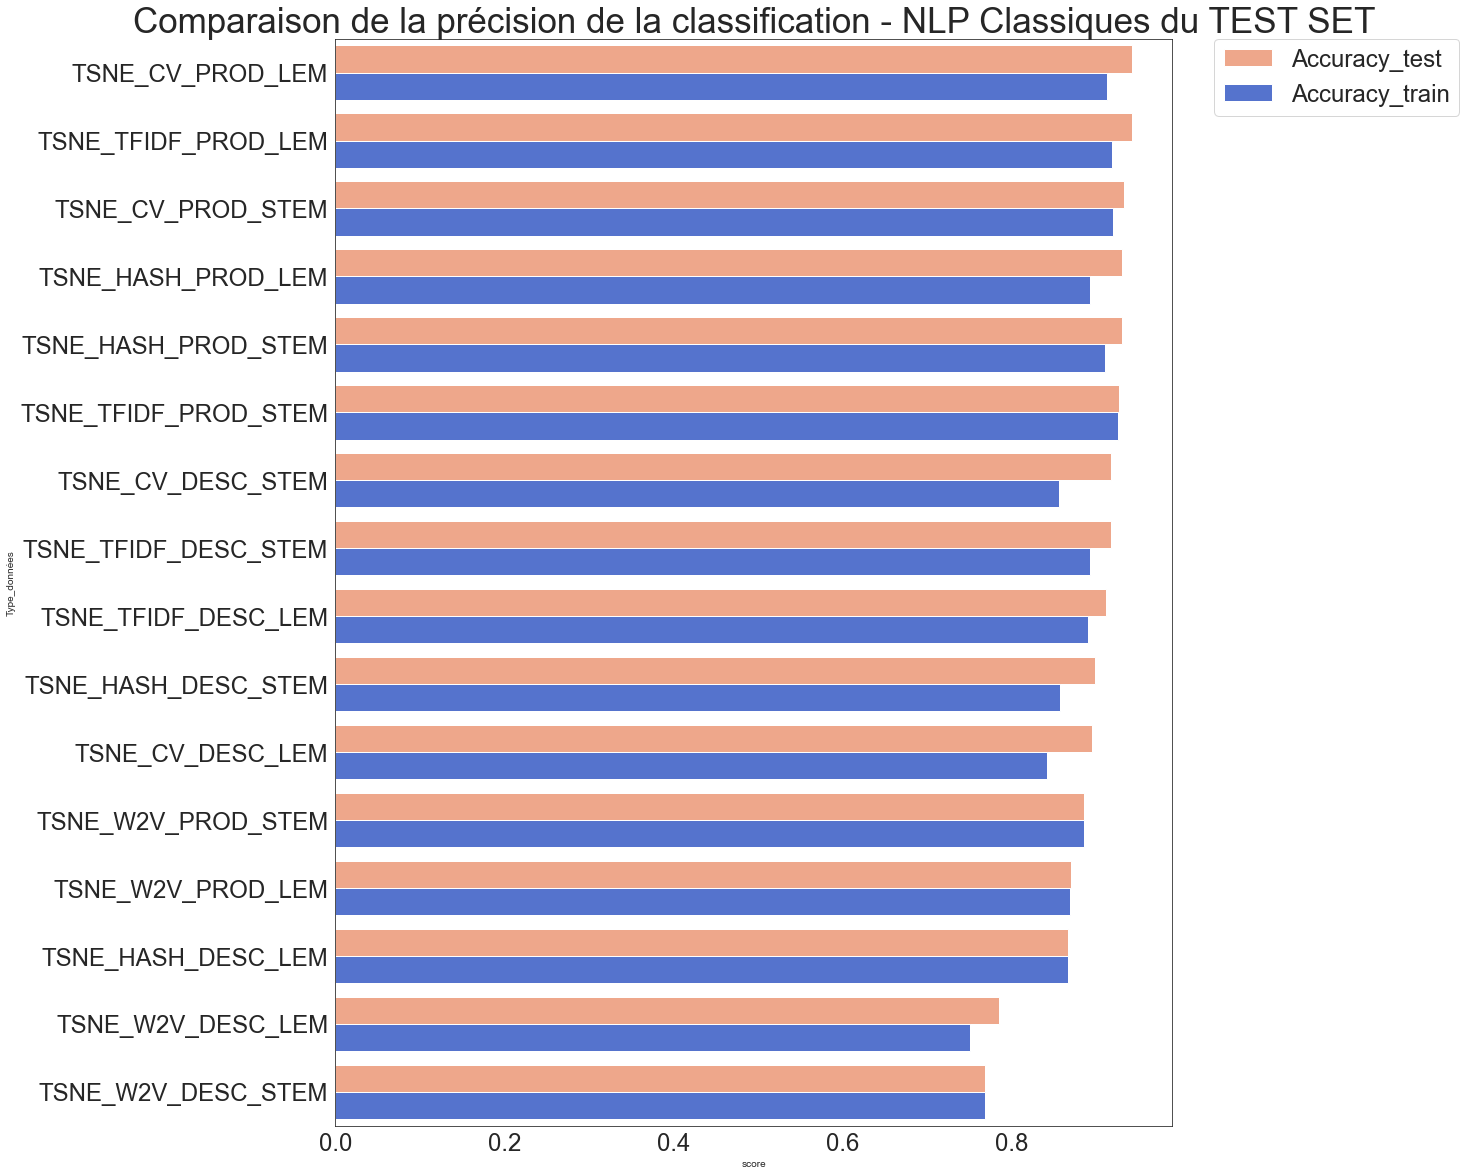

In [219]:
# TEST SET
# -----------------------------------------------------------------------
# Comparaison visuelle des algorithmes les plus performants sur le TEST SET
df_comp_nlp_sort = df_comp_nlp.sort_values(by='Accuracy_test',
                                           ascending=False)
comparaison_score_melt = pd.melt(df_comp_nlp_sort,
                                 id_vars=['Type_données'],
                                 value_name='score',
                                 value_vars=['Accuracy_test',
                                             'Accuracy_train'])
# Visualisation
plt.figure(figsize=(15, 20))
sns.barplot(y=comparaison_score_melt['Type_données'],
            x=comparaison_score_melt['score'],
            hue=comparaison_score_melt['variable'],
            palette=['LightSalmon', 'RoyalBlue'])
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
tit1 = 'Comparaison de la précision de la classification - '
tit2 = 'NLP Classiques du TEST SET'
plt.title(tit1 + tit2, fontsize=35)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=24)
plt.show()

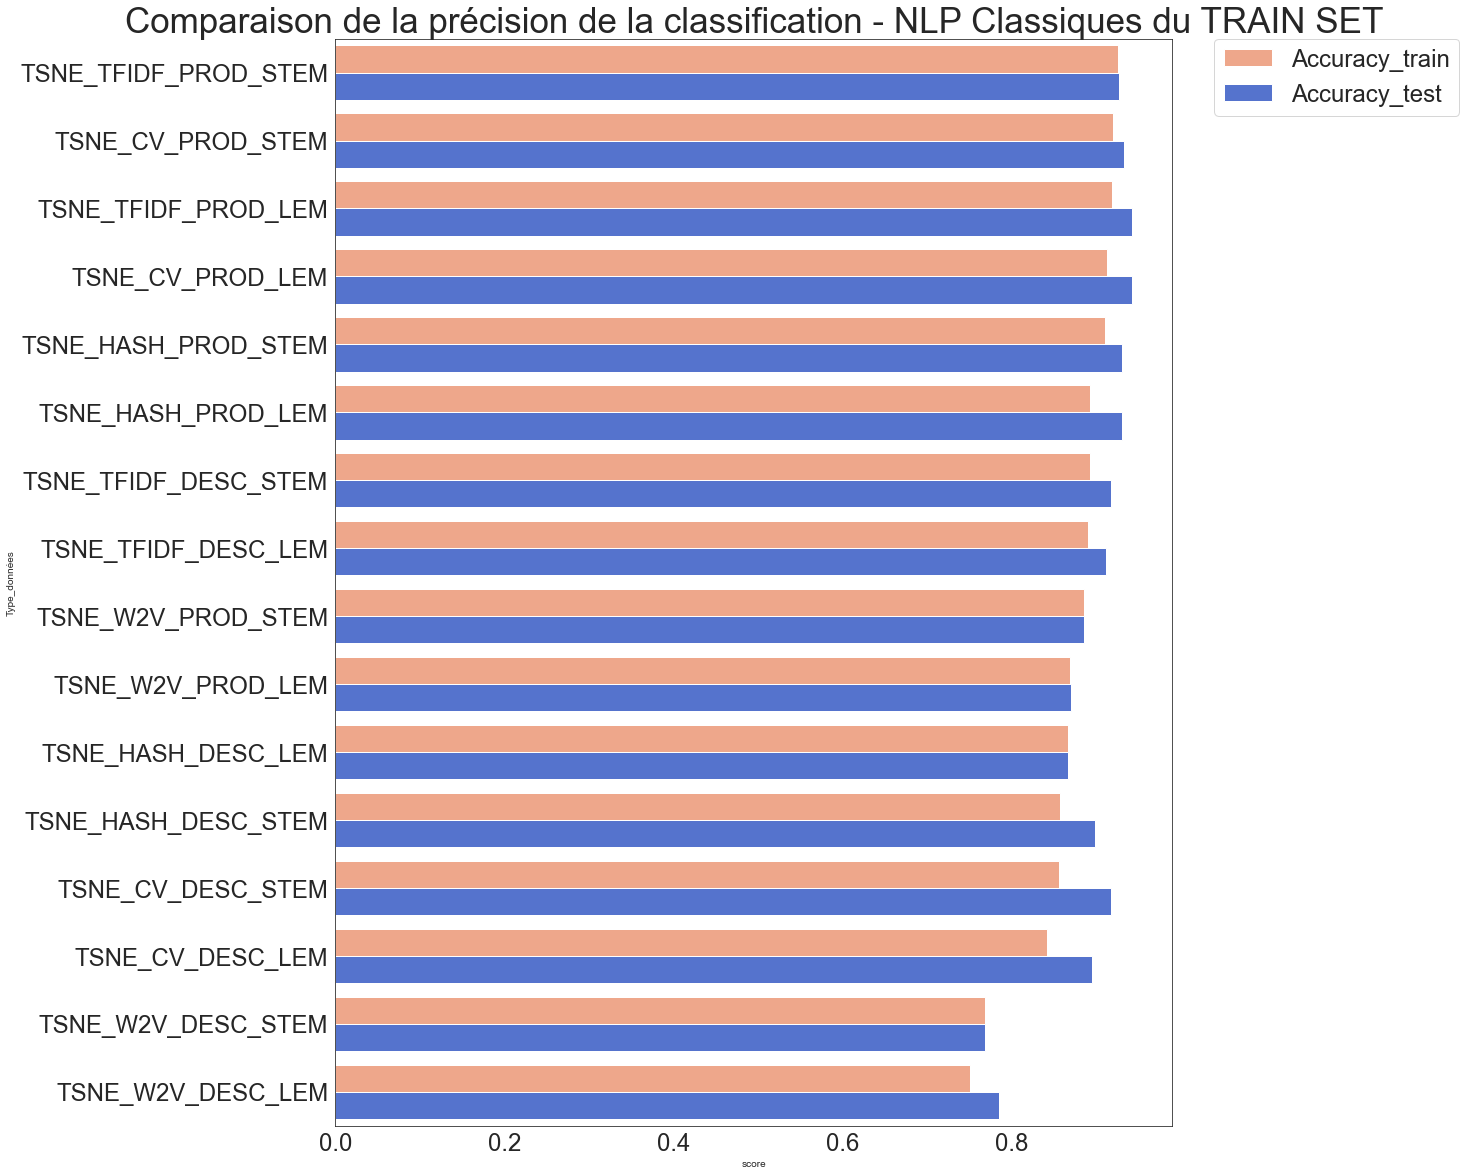

In [222]:
# TRAIN SET
# -----------------------------------------------------------------------
# Comparaison visuelle des algorithmes les plus performants sur le TRAIN SET
df_comp_nlp_sort_train = df_comp_nlp.sort_values(by='Accuracy_train',
                                                 ascending=False)
compnlptrain_score_melt = pd.melt(df_comp_nlp_sort_train,
                                  id_vars=['Type_données'],
                                  value_name='score',
                                  value_vars=['Accuracy_train',
                                              'Accuracy_test'])
# Visualisation
plt.figure(figsize=(15, 20))
sns.barplot(y=compnlptrain_score_melt['Type_données'],
            x=compnlptrain_score_melt['score'],
            hue=compnlptrain_score_melt['variable'],
            palette=['LightSalmon', 'RoyalBlue'])
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
tit1 = 'Comparaison de la précision de la classification - '
tit2 = 'NLP Classiques du TRAIN SET'
plt.title(tit1 + tit2, fontsize=35)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=24)
plt.show()

In [223]:
# TOP 10 des résultats de classification sur le TEST SET
df_comp_nlp_sort.head(10).style.hide_index()

In [224]:
# TOP 10 des résultats de classification sur le TRAIN SET
df_comp_nlp_sort_train.head(10).style.hide_index()

**Bilan** :
- Les meilleurs résultats de classification sont obtenus avec la variable produit spécification lemmatisé ou stemmatisé avec COuntVectorizer ou TfidfVectorizer sur le train set (> 91%) ou le test set (> 94%).

### <span style='background:PowderBlue'>7.2. Méthodes NLP Texts Embeddings</span>

In [164]:
# Dataframe de comparaison des scores ARI et de la précision
df_comparaison = df_accuracy_class.copy()
df_comparaison['Accuracy_train'] = \
    df_comparaison['Accuracy_train'].astype(float)
df_comparaison['Accuracy_test'] = \
    df_comparaison['Accuracy_test'].astype(float)

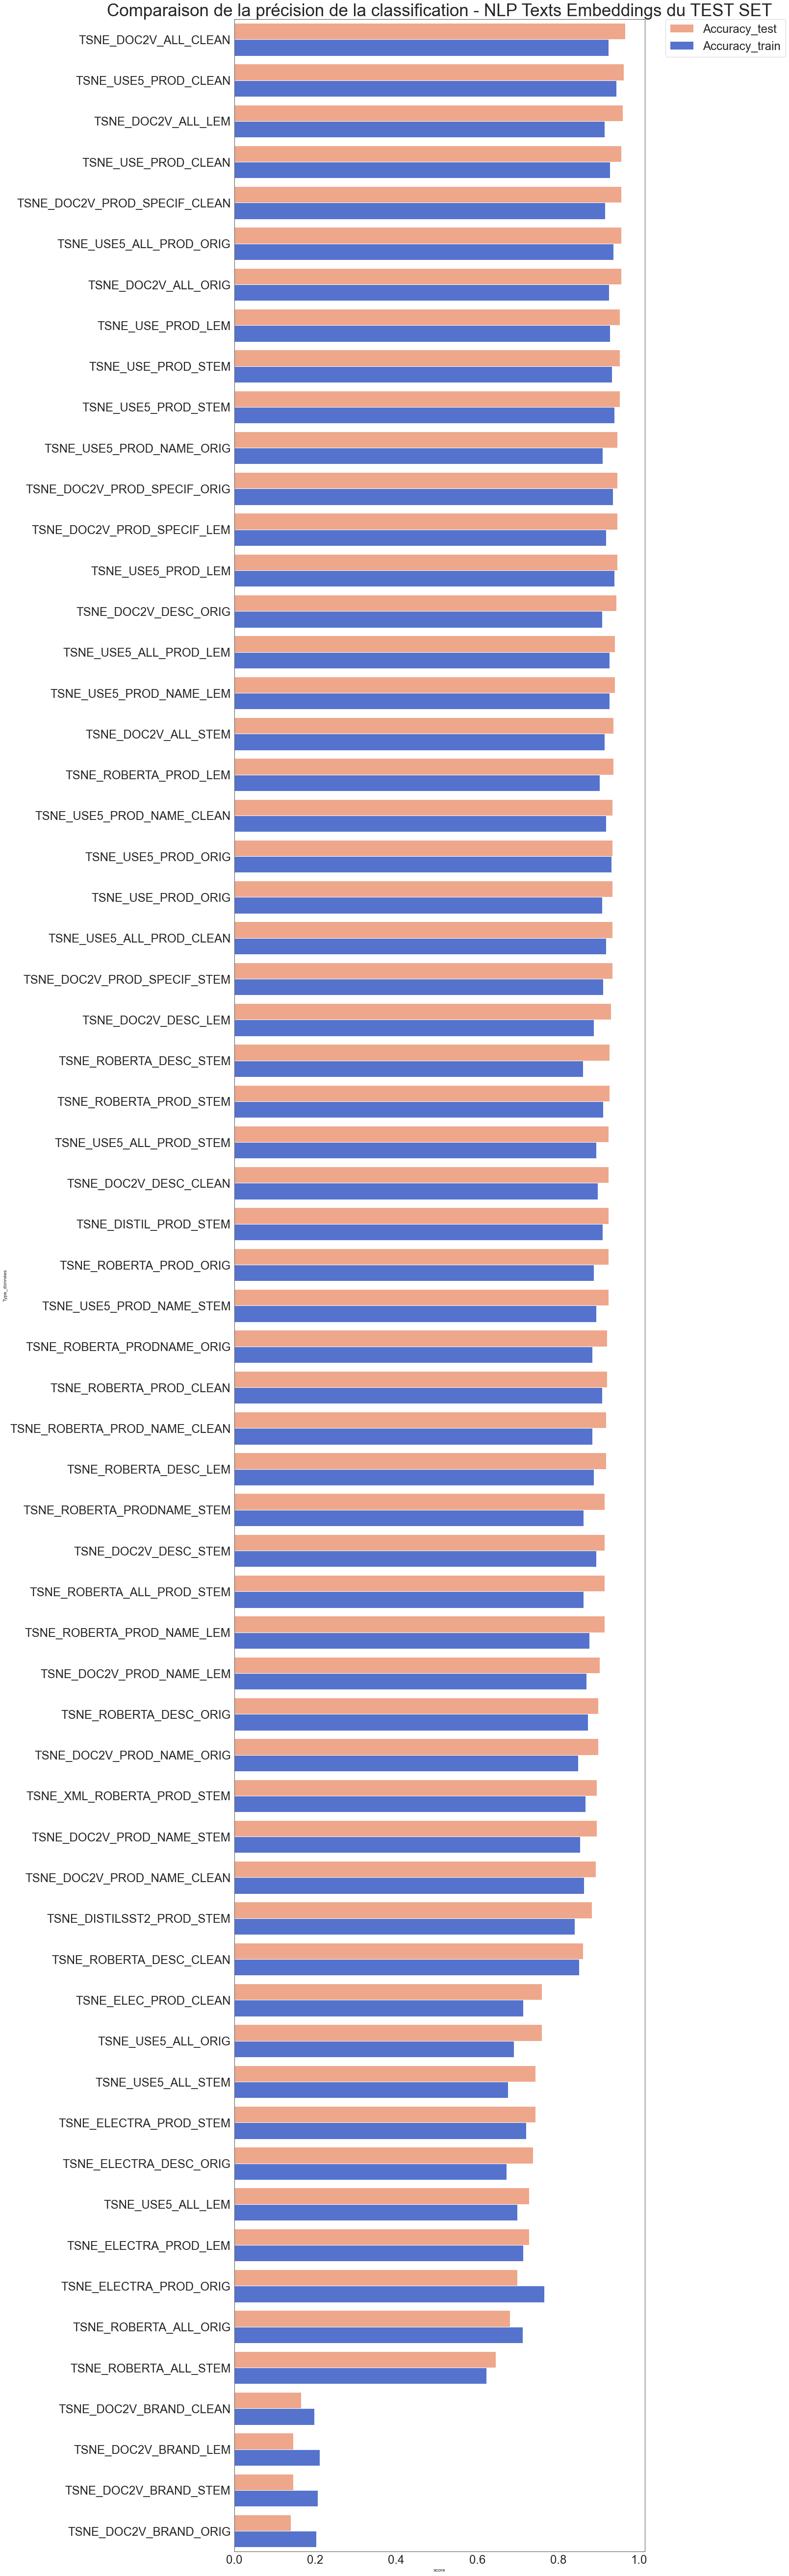

In [226]:
# TEST SET
# -----------------------------------------------------------------------
# Comparaison visuelle des algorithmes les plus performants sur le TEST SET
df_comp_sort = df_comparaison.sort_values(by='Accuracy_test', ascending=False)
comparaison_score_melt = pd.melt(df_comp_sort, id_vars=['Type_données'],
                                 value_name='score',
                                 value_vars=['Accuracy_test',
                                             'Accuracy_train'])
# Visualisation
plt.figure(figsize=(15, 95))
sns.barplot(y=comparaison_score_melt['Type_données'],
            x=comparaison_score_melt['score'],
            hue=comparaison_score_melt['variable'],
            palette=['LightSalmon', 'RoyalBlue'])
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
tit1 = 'Comparaison de la précision de la classification - '
tit2 = 'NLP Texts Embeddings du TEST SET'
plt.title(tit1 + tit2, fontsize=35)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=24)
plt.show()

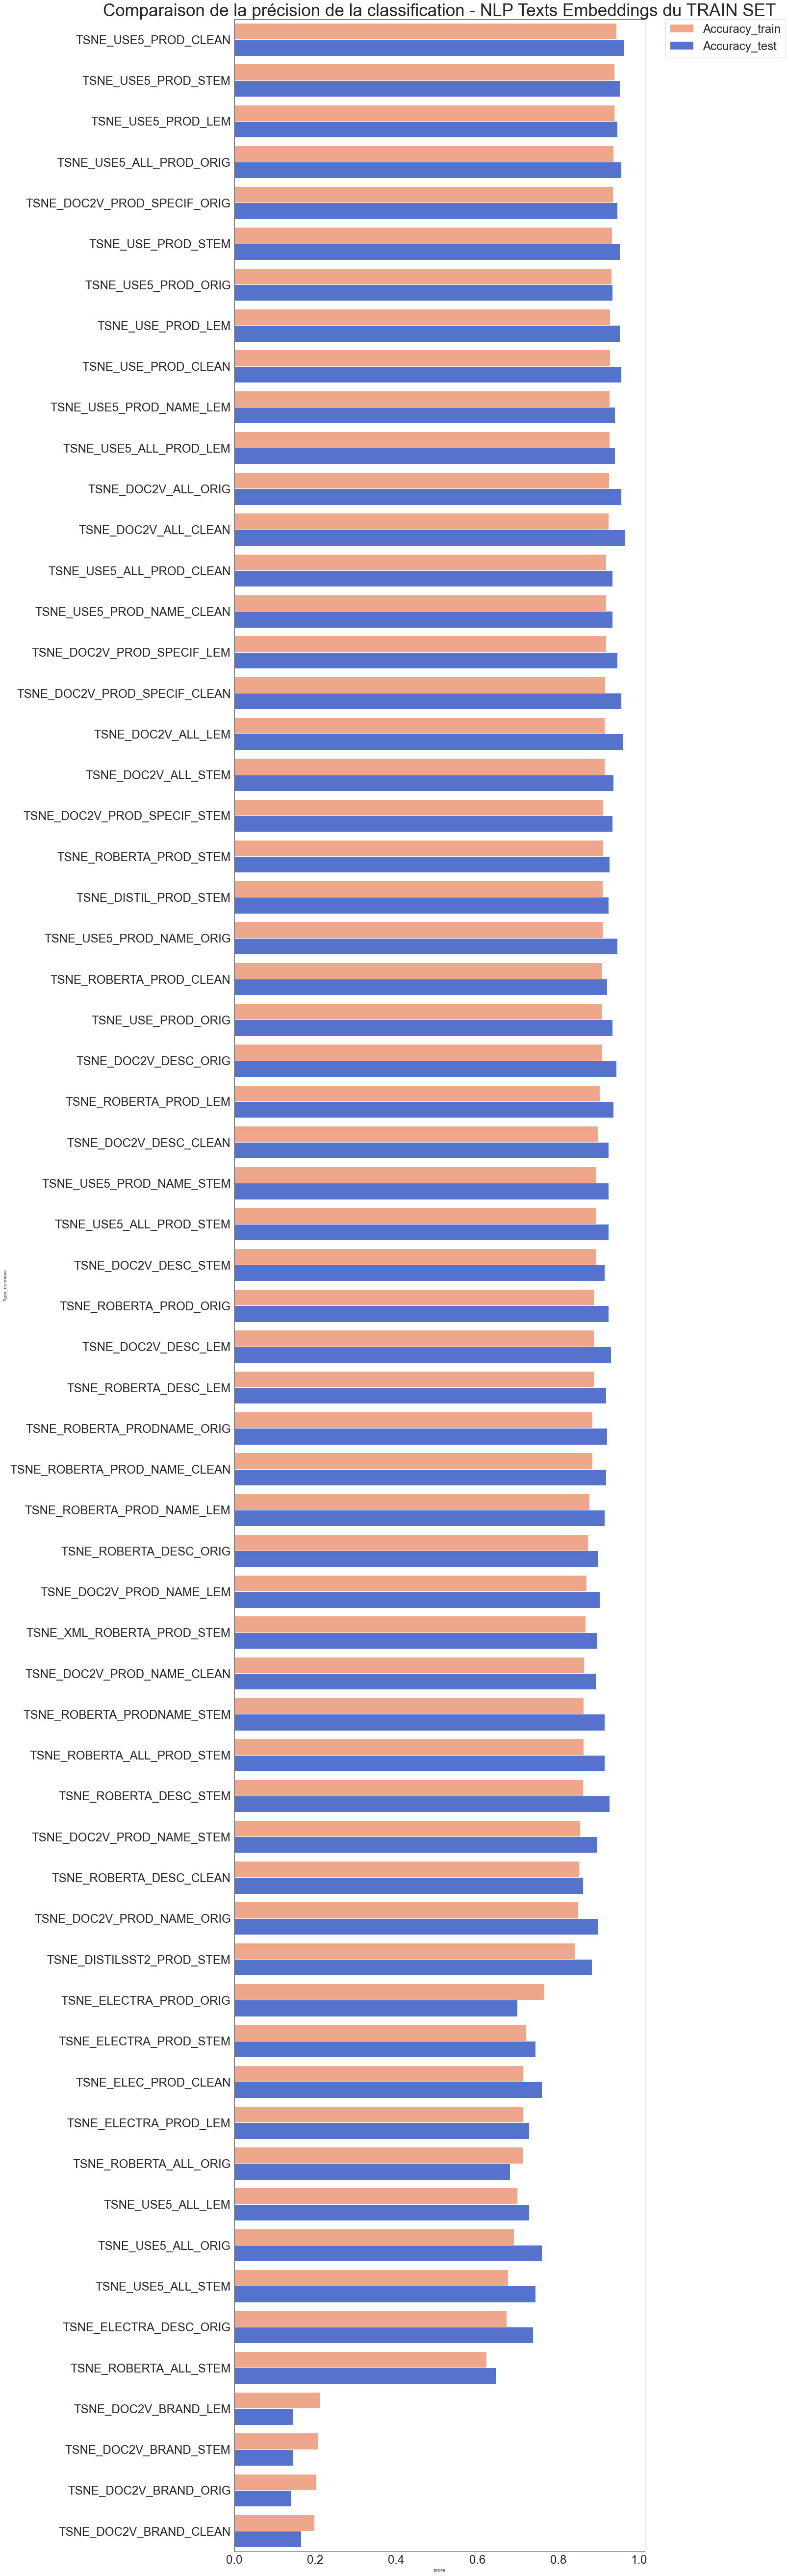

In [227]:
# TRAIN SET
# -----------------------------------------------------------------------
# Comparaison visuelle des algorithmes les plus performants sur le TRAIN SET
df_comp_sort_train = df_comparaison.sort_values(by='Accuracy_train',
                                                ascending=False)
comparaison_score_melt = pd.melt(df_comp_sort_train,
                                 id_vars=['Type_données'],
                                 value_name='score',
                                 value_vars=['Accuracy_train',
                                             'Accuracy_test'])
# Visualisation
plt.figure(figsize=(15, 95))
sns.barplot(y=comparaison_score_melt['Type_données'],
            x=comparaison_score_melt['score'],
            hue=comparaison_score_melt['variable'],
            palette=['LightSalmon', 'RoyalBlue'])
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
tit1 = 'Comparaison de la précision de la classification - '
tit2 = 'NLP Texts Embeddings du TRAIN SET'
plt.title(tit1 + tit2, fontsize=35)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=24)
plt.show()

In [193]:
# TOP 10 des résultats de classification sur le TEST SET
df_comp_sort.head(10).style.hide_index()

In [194]:
# TOP 10 des résultats de classification sur le TRAIN SET
df_comp_sort_train.head(10).style.hide_index()

**Bilan** :
- Le language USE avec la dernière verson (5) obtient des meilleurs résultats avec le produit spécification normalisé ou lemmatisé ou stemmatisé sur le train set et sur le test set.
- Doc2Vec et USE version 5 sont les 2 algorithmes les plus performants pour une classification supervisée.

### <span style='background:PowderBlue'>7.3. Combinaison - méthodes NLP Classiques et méthodes Texts Embeddings</span>

In [205]:
df_comp_all = df_accuracy_class.copy()
df_comp_all.shape

(62, 3)

In [207]:
df_comp_all = pd.concat([df_comp_all, df_accuracy_class_we])
df_comp_all.shape

(78, 3)

In [208]:
df_comp_all['Accuracy_train'] = \
    df_comp_all['Accuracy_train'].astype(float)
df_comp_all['Accuracy_test'] = \
    df_comp_all['Accuracy_test'].astype(float)

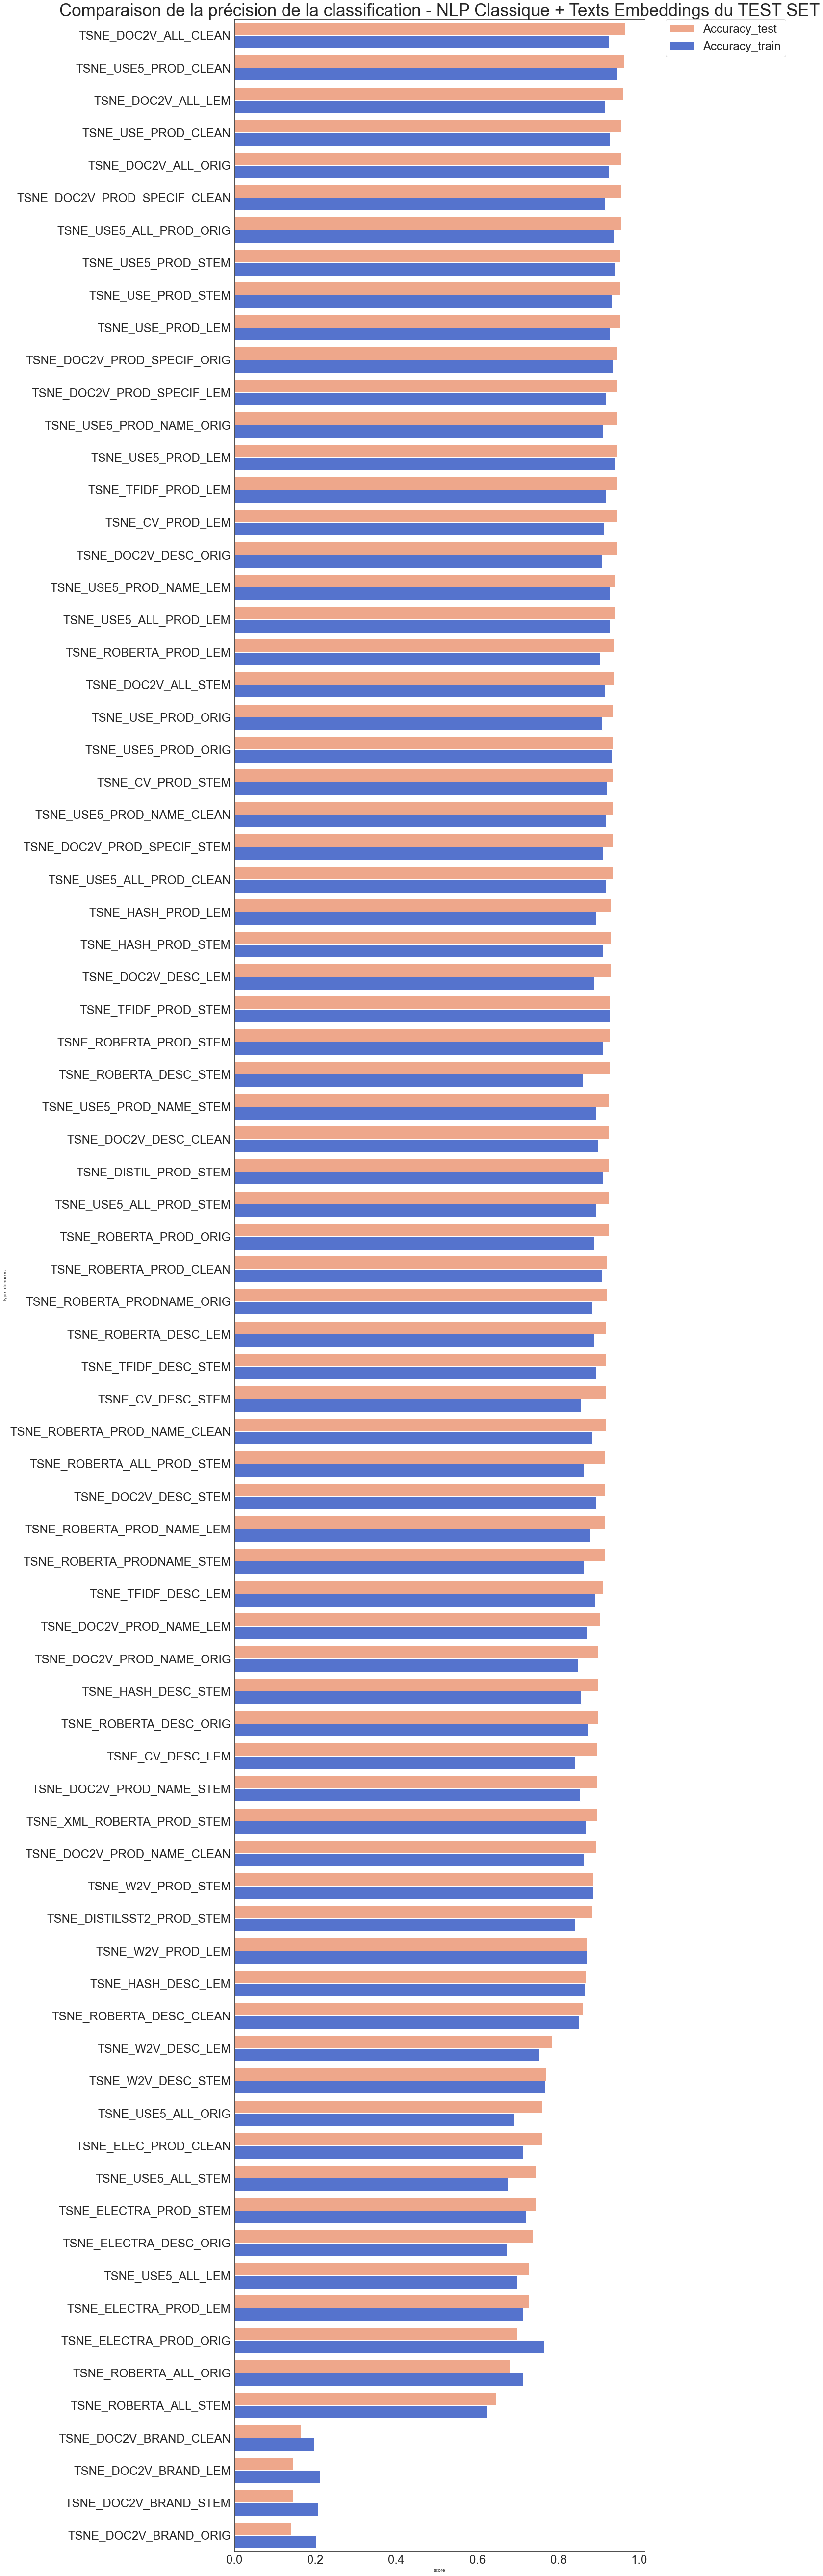

In [229]:
# TEST SET
# -----------------------------------------------------------------------
# Comparaison visuelle des algorithmes les plus performants sur le TEST SET
df_comp_all_sort_test = df_comp_all.sort_values(by='Accuracy_test',
                                                ascending=False)
compalltest_score_melt = pd.melt(df_comp_all_sort_test,
                                 id_vars=['Type_données'],
                                 value_name='score',
                                 value_vars=['Accuracy_test',
                                             'Accuracy_train'])
# Visualisation
plt.figure(figsize=(15, 95))
sns.barplot(y=compalltest_score_melt['Type_données'],
            x=compalltest_score_melt['score'],
            hue=compalltest_score_melt['variable'],
            palette=['LightSalmon', 'RoyalBlue'])
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
tit1 = 'Comparaison de la précision de la classification - '
tit2 = 'NLP Classique + Texts Embeddings du TEST SET'
plt.title(tit1 + tit2, fontsize=35)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=24)
plt.show()

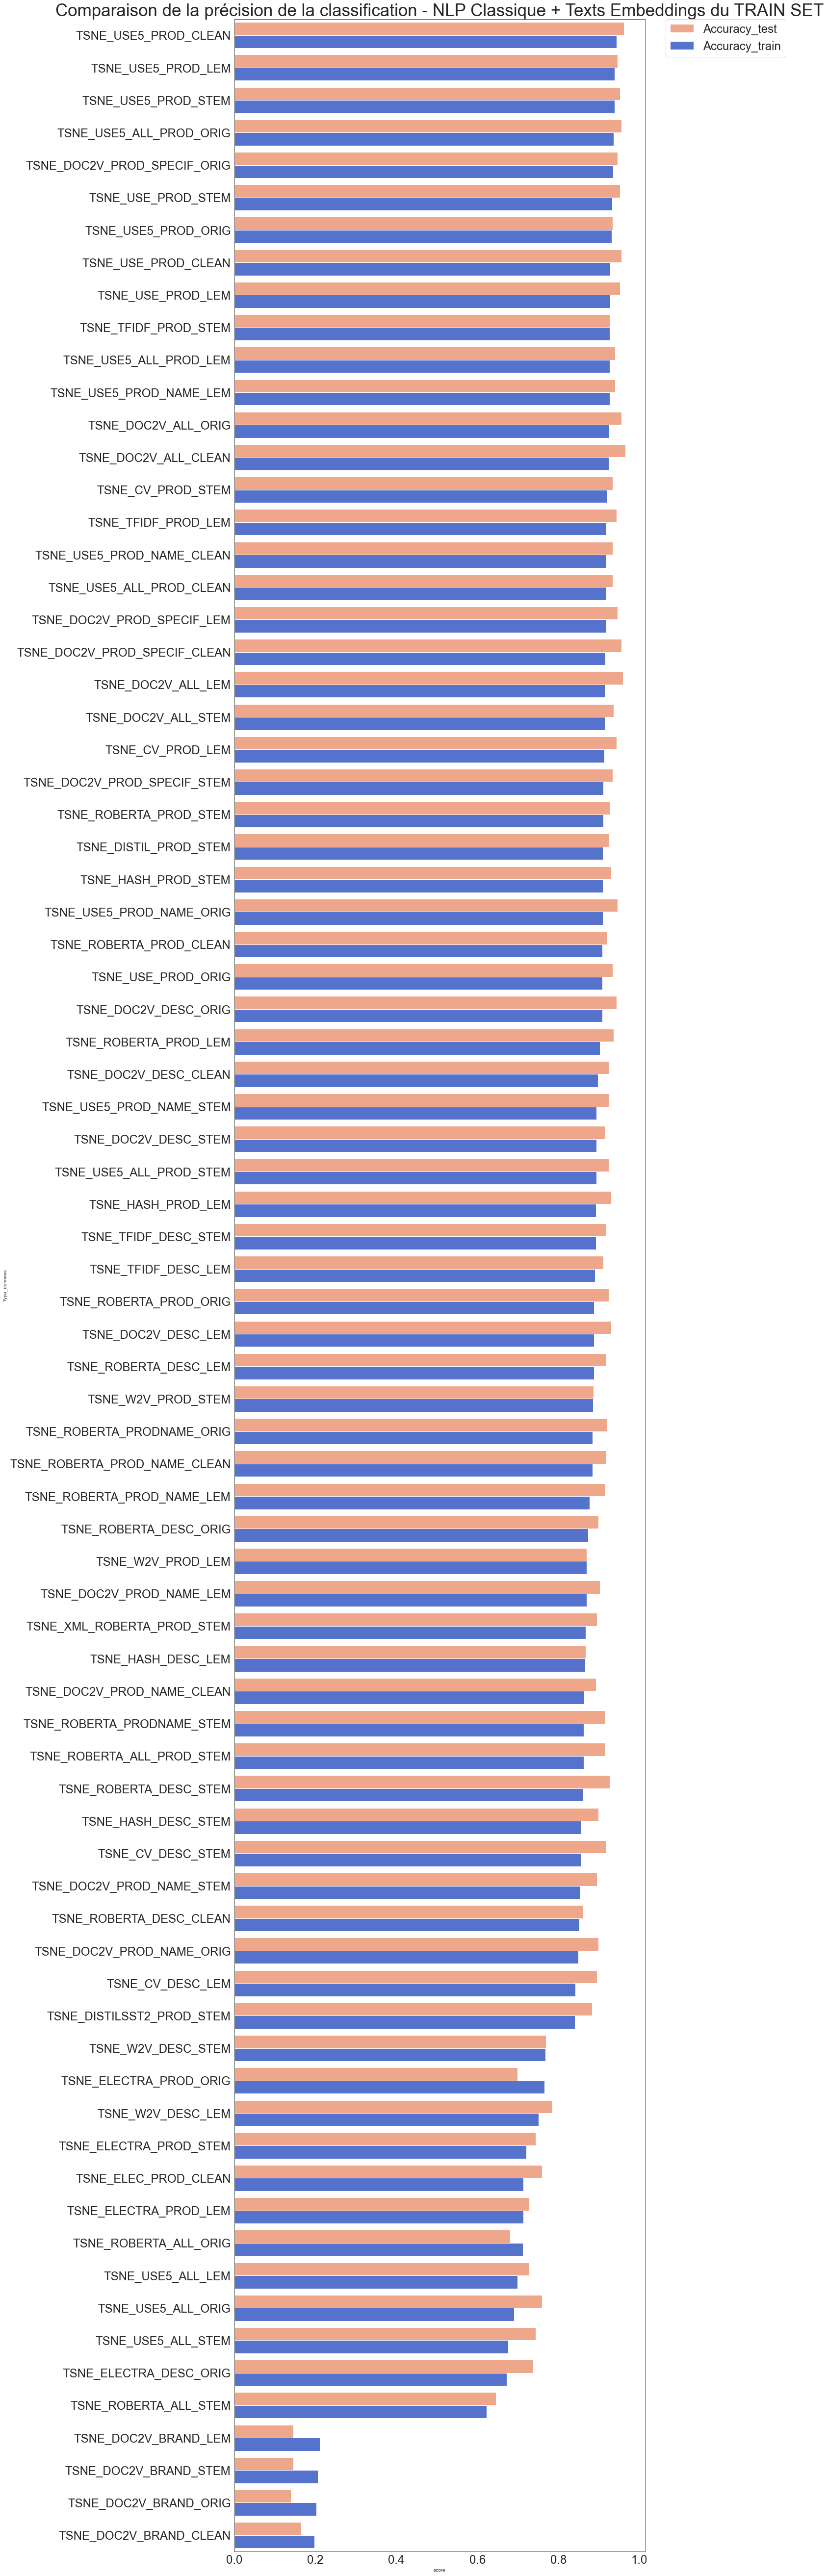

In [230]:
# TRAIN SET
# -----------------------------------------------------------------------
# Comparaison visuelle des algorithmes les plus performants sur le TRAIN SET
df_comp_all_sort_train = df_comp_all.sort_values(by='Accuracy_train',
                                                 ascending=False)
compalltrain_score_melt = pd.melt(df_comp_all_sort_train,
                                  id_vars=['Type_données'],
                                  value_name='score',
                                  value_vars=['Accuracy_test',
                                              'Accuracy_train'])
# Visualisation
plt.figure(figsize=(15, 95))
sns.barplot(y=compalltrain_score_melt['Type_données'],
            x=compalltrain_score_melt['score'],
            hue=compalltrain_score_melt['variable'],
            palette=['LightSalmon', 'RoyalBlue'])
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
tit1 = 'Comparaison de la précision de la classification - '
tit2 = 'NLP Classique + Texts Embeddings du TRAIN SET'
plt.title(tit1 + tit2, fontsize=35)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=24)
plt.show()

In [231]:
# TOP 10 des résultats de classification sur le TRAIN SET
df_comp_all_sort_train.head(10).style.hide_index()

In [232]:
# TOP 10 des résultats de classification sur le TEST SET
df_comp_all_sort_test.head(10).style.hide_index()

**Bilan** :
- Les méthodes Texts Embeddings USE 5 et Doc2Vec sont plus adaptées que les méthodes classiques pour notre jeu de données d'étude.

## <span style='background:Thistle'>8. Erreurs</span>

Quelles sont les erreurs pour USE pour la variable Produit Spécification Lemmatisé?

In [181]:
titre = 'TSNE_USE5_PROD_LEM'

INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 2
INFO:logs:<catboost.core.CatBoostClassifier object at 0x00000238906C0C40>
INFO:logs:compare_models() succesfully completed......................................
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=<catboost.core.CatBoostClassifier object at 0x00000238906C0C40>, probability_threshold=None, encoded_labels=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


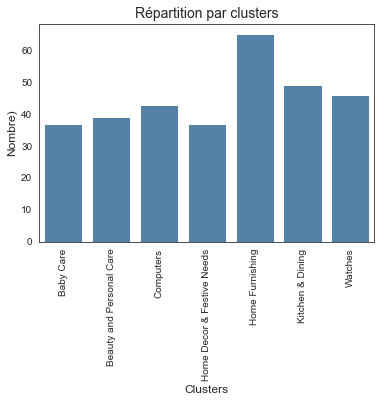

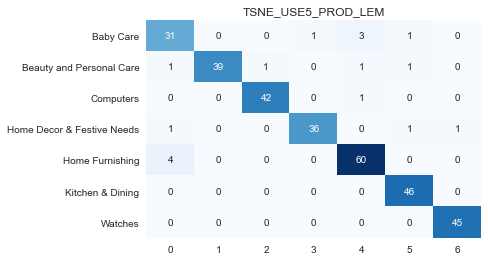

'Précision: 94.62%'

                            precision    recall  f1-score   support

                 Baby Care       0.84      0.86      0.85        36
  Beauty and Personal Care       1.00      0.91      0.95        43
                 Computers       0.98      0.98      0.98        43
Home Decor & Festive Needs       0.97      0.92      0.95        39
           Home Furnishing       0.92      0.94      0.93        64
          Kitchen & Dining       0.94      1.00      0.97        46
                   Watches       0.98      1.00      0.99        45

                  accuracy                           0.95       316
                 macro avg       0.95      0.94      0.94       316
              weighted avg       0.95      0.95      0.95       316


In [183]:
df_result = outils_nlp.classifier_pycaret_pred(data_cat,
                                               vector_use5_prod_lem,
                                               titre)

**Répartition des erreurs par catégorie**

In [233]:
mask = df_result['CATEGORIE'] == df_result['Label']
df_erreur = df_result[~mask]
display(f'Nombre d\'erreurs : {df_erreur.shape[0]}')

"Nombre d'erreurs : 17"

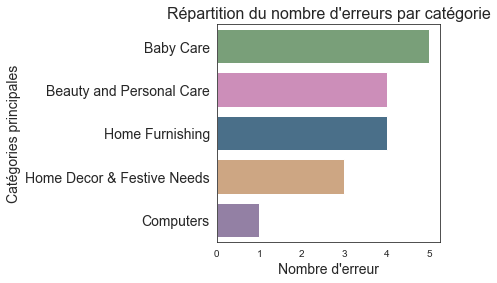

In [252]:
# Répartition des erreurs par catégorie
plt.figure(figsize=(4, 4))
sns.countplot(y='CATEGORIE', data=df_erreur, orient='h',
              order=df_erreur['CATEGORIE'].value_counts().index,
              palette=['#73a573', '#d684bd', '#407193', '#d9a577',
                       '#937aaa'])
plt.title('Répartition du nombre d\'erreurs par catégorie', fontsize=16)
plt.xlabel('Nombre d\'erreur', fontsize=14)
plt.ylabel('Catégories principales', fontsize=14)
plt.yticks(fontsize=14)
plt.show()

**Répartition des erreurs des catégories par catégorie**

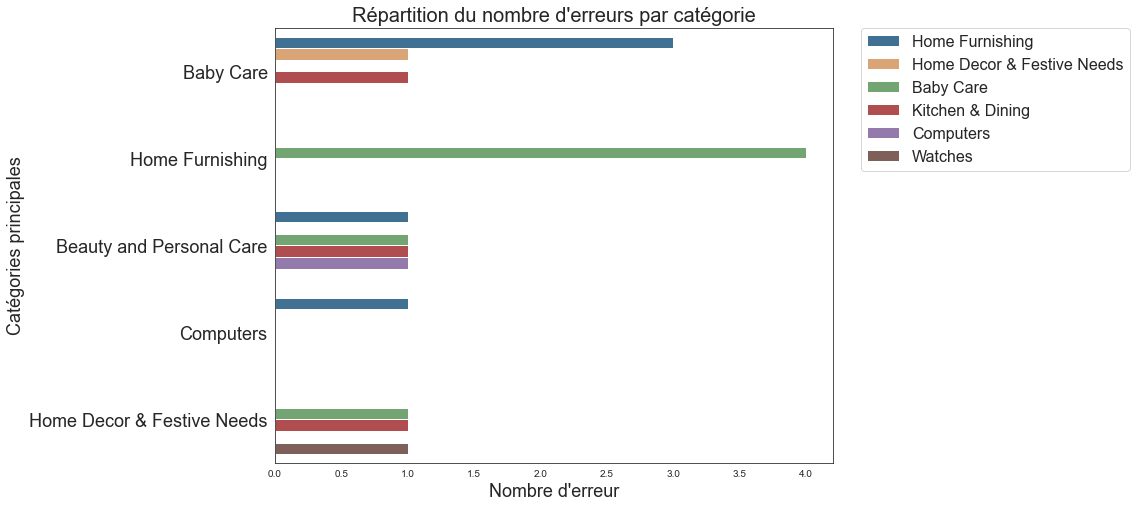

In [253]:
# Répartition des erreurs par catégorie
plt.figure(figsize=(10, 8))
sns.countplot(y='CATEGORIE', hue='Label',
              data=df_erreur, orient='h',
              palette=['#3274a1', '#e9a467', '#6bad6b', '#c03d3e',
                       '#9372b2', '#845b53', '#d684bd'])
plt.title('Répartition du nombre d\'erreurs par catégorie', fontsize=20)
plt.xlabel('Nombre d\'erreur', fontsize=18)
plt.ylabel('Catégories principales', fontsize=18)
plt.yticks(fontsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=16)
plt.show()

**Diagramme SANKEY**

In [239]:
df_sankey = df_erreur.groupby(['CATEGORIE', 'Label']) \
    .count().reset_index()

In [240]:
label = ['Home Furnishing', 'Kitchen & Dining', 'Computers', 'Baby Care',
         'Beauty and Personal Care', 'Home Decor & Festive Needs',
         'Watches', 'Home Furnishing', 'Kitchen & Dining', 'Computers',
         'Baby Care', 'Beauty and Personal Care',
         'Home Decor & Festive Needs', 'Watches']

In [241]:
df_sankey['Source'] = ['0' if row == 'Home Furnishing'
                       else '1' if row == 'Kitchen & Dining'
                       else '2' if row == 'Computers'
                       else '3' if row == 'Baby Care'
                       else '4' if row == 'Beauty and Personal Care'
                       else '5' if row == 'Home Decor & Festive Needs'
                       else '6' if row == 'Watches'
                       else '7'
                       for row in df_sankey['CATEGORIE']]

In [242]:
df_sankey['Target'] = ['7' if row == 'Home Furnishing'
                       else '8' if row == 'Kitchen & Dining'
                       else '9' if row == 'Computers'
                       else '10' if row == 'Baby Care'
                       else '11' if row == 'Beauty and Personal Care'
                       else '12' if row == 'Home Decor & Festive Needs'
                       else '13' if row == 'Watches'
                       else '14'
                       for row in df_sankey['Label']]

In [243]:
source = df_sankey['Source'].to_list()
target = df_sankey['Target'].to_list()
value = df_sankey['VAR1'].to_list()

In [254]:
color_link = ['#73a573', '#73a573', '#73a573',
              '#d684bd', '#d684bd', '#d684bd', '#d684bd',
              '#937aaa',
              '#d9a577', '#d9a577', '#d9a577',
              '#407193']

In [255]:
df_sankey

CATEGORIE                       Label  VAR1  VAR2  Score Source Target
0                    Baby Care  Home Decor & Festive Needs     1     1      1      3     12
1                    Baby Care             Home Furnishing     3     3      3      3      7
2                    Baby Care            Kitchen & Dining     1     1      1      3      8
3     Beauty and Personal Care                   Baby Care     1     1      1      4     10
4     Beauty and Personal Care                   Computers     1     1      1      4      9
5     Beauty and Personal Care             Home Furnishing     1     1      1      4      7
6     Beauty and Personal Care            Kitchen & Dining     1     1      1      4      8
7                    Computers             Home Furnishing     1     1      1      2      7
8   Home Decor & Festive Needs                   Baby Care     1     1      1      5     10
9   Home Decor & Festive Needs            Kitchen & Dining     1     1      1      5      8
10  Home Decor & Festive Needs                     Watches     1     1      1      5     13
11             Home Furnishing                   Baby Care     4     4      4      0     10

In [260]:
# Node data
color_node = ['#808B96', '#808B96', '#808B96',
              '#808B96', '#808B96', '#808B96', '#808B96',
              '#808B96',
              '#808B96', '#808B96', '#808B96',
              '#808B96']

In [261]:
# data to dict, dict to sankey
link = dict(source=source, target=target, value=value, color=color_link)
node = dict(label=label, pad=25, thickness=5, color=color_node)
data_sankey = go.Sankey(link=link, node=node, arrangement='freeform')

In [262]:
# plot comparaison historique sur 1 mois
fig_1 = go.Figure(data_sankey)
fig_1.update_layout(
    hovermode='x',
    title='Répartition des erreurs des catégories',
    font=dict(size=14, color='white'),
    paper_bgcolor='white',
    width=1000,
    height=1000,
)

# Sauvegarde du diagramme Sankey en fichier html
fig_1.write_html('sankey/erreurs_supervisees.html')

fig_1.show()

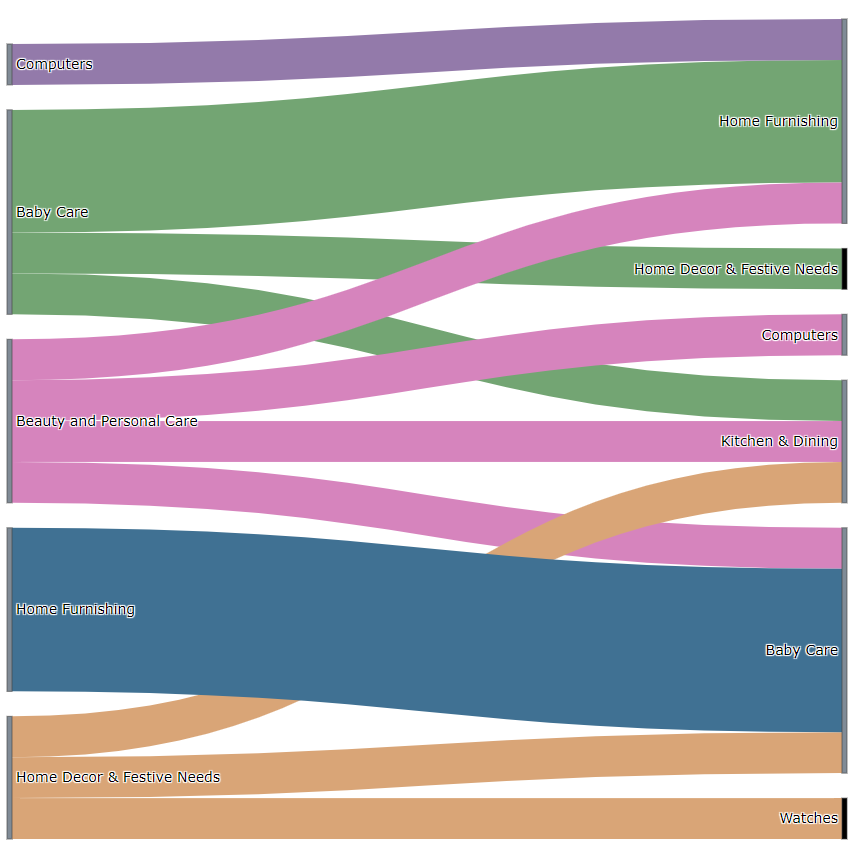

In [264]:
index_erreurs = df_erreur.index.to_list()
df_visu_erreur = data.loc[index_erreurs, :][['product_name', 'brand',
                                             'description',
                                             'product_specifications',
                                             'Categorie_1']]
df_visu_erreur['Cluster_labels'] = df_erreur['Label']
df_visu_erreur

product_name            brand  \
4                                  Jaipur Print Cotton Floral King sized Double Bedsheet     Jaipur Print   
10                                  Calibro SW-125 Analog-Digital Watch  - For Men, Boys              NaN   
18                                      Franck Bella FB74C Analog Watch  - For Boys, Men              NaN   
40                                Mom and Kid Baby Girl's Printed Green Top & Pyjama Set      Mom and Kid   
46                                                            AKUP keep-calm Ceramic Mug             AKUP   
50                                                   AKUP life-is-not-living Ceramic Mug             AKUP   
94                       BeYOUtiful Copper Repouss�� - Man With Dhol Showpiece  -  36 cm       BeYOUtiful   
100                           Goldencollections GC4353 Makeup and Jewellery Vanity Pouch              NaN   
119                                                             FRENEMY MPAD271 Mousepad          FRENEMY   
139                                             Prithish Hop Jump Skip Black Ceramic Mug              NaN   
144                                        Rockmantra Tele PhoneRMMW50000160 Ceramic Mug              NaN   
180                                                        Printland PMR1332 Ceramic Mug              NaN   
211  Lal Haveli Wooden Table Decor Mother & Baby Elephant Painted Showpiece  -  10.16 cm       Lal Haveli   
221                        S C Handicrafts Sandalwood Chinese Queen. Showpiece  -  16 cm  S C Handicrafts   
260                                            Monil Cow With Calf Showpiece  -  10.2 cm            Monil   
279                                             ESIDON AKADA06 Analog Watch  - For Women           ESIDON   
294                                           My Little Lambs Baby Girl's Gathered Dress  My Little Lambs   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 description  \
4    Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print Cotton Floral King sized Double Bedsheet (1 bed sheet 2 pillow cover, White) Price: Rs. 998 This nice bed sheet made up of 100% cotton to give you comfort. This bed sheet is hand printed. This bedsheet gives nice look to your room And its fast colour and good quality gives this bedsheet long life.,Specifications of Jaipur Print Cotton Floral King sized Double Bedsheet (1 bed sheet 2 pillow cover, White) General Machine Washable Yes Brand Jaipur Print Type Flat Model Name jaipur117 Material Cotton Thread Count 140 Model ID jaipur117 Fabric Care machinewash, do not bleach Size King Color White Warranty waranty of the product only for manufacturing defect only and product will exchange onle when it is not used and returne its origional packing Dimensions Flat Sheet Width 86 inch / 220 cm Fitted Sheet Width 0 cm Pillow Cover Width 17 inch / 45 cm Pillow Cover Length 29 inch / 75 cm Weight 900...   
10   Calibro SW-125 Analog-Digital Watch  - For Men, Boys\r\n                         Price: Rs. 